In [1]:
import torch
import numpy as np
from model import make_model
from tools import Batch,CrossEntropyLossWithLabelSmoothing,get_std_opt,LossComputeAndStep,run_epoch,greedy_decode
from torchvision.datasets import CIFAR10      #数据集
from torchvision import transforms            #数据增强
from torch.utils.data import DataLoader       #数据加载器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#为了支持多模态，允许有多个输入，但目前没有多模态的需求，默认列表中只有一条序列或者有一些等长的序列
#生成器的输入序列与输出序列类型完全一样，不支持多模态！
#为了简便，默认0为填充，1为起始标记，剩余的为正常词汇，<UNK>、<END>算作正常词汇，可以在处理数据时自由定义
#生成任务与翻译任务需要在输入序列中手动添加起始标记，使得模型能够输出更长的序列
vocab_size = 10+2
input_vocab_sizes = [vocab_size]
output_vocab_size = vocab_size
setting = {
    #平衡资源消耗与效果
    "enable_affine" : True,                   #加快训练速度(epoch少)，几乎不影响速度，可能影响稳定性
    "enable_layer_norm" : True,               #增强模型稳定性，略微减慢速度
    "enable_talking_head" : False,             #增强模型表达能力，严重减慢速度，消耗显存
    "enable_gated_linear_unit_in_projector" : False,  #增强模型表达能力，输出词表很小时可用，规律十分明显的时候不要用
    "self_attention_block_size" : 0,          #自注意力运算时的分块大小，可以显著降低显存消耗，提供额外的位置信息，但速度较慢
    "head_number" : 8,    #启用talking_head时数量越多效果越好，但平方消耗，否则避免过大导致key_dim过小
    "glu_projector_multivalue" : 64,          #enable_gated...启用后生效，平方复杂度
    "glu_projector_deep" : 1,                 #enable_gated...启用后生效，实验用，不建议设置更大的数值
    #模型类型选择
    # "model_type" : "translator",              #经典编码器-解码器架构，适合机器翻译
    # "model_type" : "classifier",              #分类器，没有解码器，编码完总结到固定长度进行分类
    # "model_type" : "generator",               #生成器，不停的预测下一个词，可以做大模型
    "model_type" : "vit",                     #简单的图像分类 
    "share_embeddings" : False,             #是否进行词表共享，只对"translator"有效
    "summarizer_length" : 4,                #分类器的总结长度，总结时没法分块，注意资源消耗
    "patch_size" : 16,                      #图像分块的大小，只对vit有效
    "cross_attention_block_size" : 0, #在显存不足的时候对query分段计算cross_attention，会减慢速度，逻辑上与不分块一样，只有"translator"可用
    #参数规模设置
    "embedding_dim" : 64,                   #词嵌入维度
    "key_dim" : 64,
    "vocab_in_size_list" : input_vocab_sizes,  #输入词表大小，支持多个输入列表，可以多模态
    "vocab_out_size" : output_vocab_size,      #输出词表大小，共享词表时不支持多模态
    "feed_forward_dim" : 256,               #注意力运算结束后用于混合不同head信息的前馈网络隐藏层维度
    "model_layers_number" : 2,              #模型的层数，注意资源消耗
    #位置信息添加方式选择
    #"position_information_type" : "mask_position_information",      #掩码位置信息，如果能训练好的话可以无限外推，但可能训练有困难
    # "position_information_type" : "no_position_information",        #没有位置信息（分类器可能会用）
    # "position_information_type" : "sinusoidal_position_encoding",   #余弦位置编码（经典，高效）
    # "position_information_type" : "rotary_position_encoding",       #旋转位置编码（更好的表达相对位置）
    # "position_information_type" : "rotary_position_encoding_with_random_start", #只使用相对信息，建议用掩码
    "position_information_type" : "position_encoding_learned",      #可学习位置编码
    #增加泛化能力
    "dropout_rate" : 0.1 #训练时，注意力，前馈，talking都会随机丢弃计算结果，增加泛化能力
}
model_affine = make_model(setting).to(device)
setting["enable_affine"] = False
model_no_affine = make_model(setting).to(device)

criterion = CrossEntropyLossWithLabelSmoothing(output_vocab_size,smoothing=0.0)

optimizer_affine = get_std_opt(model_affine,fast=False,lr_rate=1e-6)
optimizer_no_affine = get_std_opt(model_no_affine,fast=False,lr_rate=1e-6)

weight_updater_affine = LossComputeAndStep(criterion,optimizer_affine)
weight_updater_no_affine = LossComputeAndStep(criterion,optimizer_no_affine)

In [3]:
#加载和预处理数据集
trans_train = transforms.Compose([
    transforms.RandomResizedCrop(224),#将给定图像随机裁剪为不同的大小和宽高比，
    #然后缩放所裁剪得到的图像为制定的大小：
    #（即先随机采集，然后对裁剪得到的图像缩放为同一大小）默认scale=（0.08，1.0）
    transforms.RandomHorizontalFlip(),#以给定的概率随机水平旋转给定的PIL的图像，默认为0.5：
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])
trans_valid = transforms.Compose([
    transforms.Resize(256),      #是按照比例把图像最小的一个边长放缩到256，另一边按照相同比例放缩。
    transforms.CenterCrop(224),  #依据给定的size从中心裁剪
    transforms.ToTensor(),       #将PILImage或者ndarray 转换为tensor，并且归一化至[0-1]
    #归一化至[0-1]是直接除以255，若自己的ndarray数据尺度有变化，则需要自行修改。
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])
#对数据按通道进行标准化，即先减均值，再除以标准差，注意是hwc
trainset=CIFAR10(root="./cifar10",train=True,download=True,transform=trans_train)
testset=CIFAR10(root='./cifar10',train=False,download=False,transform=trans_valid)

trainloader = DataLoader(trainset,batch_size=256,shuffle=True,num_workers=8)
testloader = DataLoader(testset,batch_size=256,shuffle=False,num_workers=8)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified


In [4]:
#数据生成器
def data_generator(train):
    if train:
        dataiter = iter(trainloader)
    else:
        dataiter = iter(testloader)
    for images,labels in dataiter:
        images = images.to(device)
        labels = labels.to(device)+2
        yield Batch([images],labels)

In [5]:
batch = next(data_generator(True))
print(batch.querys[0].size())
print(batch.label.size())

torch.Size([256, 3, 224, 224])
torch.Size([256])


In [6]:
from tqdm import tqdm

In [7]:
#训练时使用的数据格式
num_of_epochs = 250
#用于保存
save_v_affine = 50
save_v_no_affine = 50
affine_acc = []
no_affine_acc = []
#进行训练
for epoch in range(num_of_epochs):
    print("Epoch:",epoch)
    model_affine.train()
    model_no_affine.train()
    run_epoch(model_affine,data_generator(train = True),weight_updater_affine)
    run_epoch(model_no_affine,data_generator(train = True),weight_updater_no_affine)
    model_affine.eval()
    model_no_affine.eval()
    with torch.no_grad():
        run_epoch(model_affine,data_generator(train = False),weight_updater_affine)
        run_epoch(model_no_affine,data_generator(train = False),weight_updater_no_affine)
    with torch.no_grad():
        cerrect = 0
        for images,labels in tqdm(iter(testloader)):
            images = images.to(device)
            labels = labels.to(device)+2
            cerrect += (greedy_decode(model_affine,[images]) == labels).cpu().numpy().sum()
        print(str(cerrect/100)+'%')
        affine_acc += [cerrect/100]
        if cerrect/100 > save_v_affine:
            torch.save(model_affine.state_dict(),'vit_affine_'+str(save_v_affine)+'.weight')
            save_v_affine+=5
    with torch.no_grad():
        cerrect = 0
        for images,labels in tqdm(iter(testloader)):
            images = images.to(device)
            labels = labels.to(device)+2
            cerrect += (greedy_decode(model_no_affine,[images]) == labels).cpu().numpy().sum()
        print(str(cerrect/100)+'%')
        no_affine_acc += [cerrect/100]
        if cerrect/100 > save_v_no_affine:
            torch.save(model_no_affine.state_dict(),'vit_no_affine_'+str(save_v_no_affine)+'.weight')
            save_v_no_affine+=5

Epoch: 0
Step: 0 Loss: 2.738317 Tokens per Sec: 103.659993
total_step: 50 lr: 4.9999999999999996e-05
Step: 50 Loss: 2.375866 Tokens per Sec: 1291.100256
total_step: 100 lr: 9.999999999999999e-05
Step: 100 Loss: 2.077630 Tokens per Sec: 1403.807959
total_step: 150 lr: 0.00015
Step: 150 Loss: 2.046366 Tokens per Sec: 1447.807076
Step: 0 Loss: 2.542060 Tokens per Sec: 193.076251
total_step: 50 lr: 4.9999999999999996e-05
Step: 50 Loss: 2.412229 Tokens per Sec: 1556.412161
total_step: 100 lr: 9.999999999999999e-05
Step: 100 Loss: 2.144546 Tokens per Sec: 1573.246019
total_step: 150 lr: 0.00015
Step: 150 Loss: 2.064231 Tokens per Sec: 1422.247729
Step: 0 Loss: 1.896667 Tokens per Sec: 192.115643
Step: 0 Loss: 1.906719 Tokens per Sec: 187.480359


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]

30.39%



100%|██████████| 40/40 [00:08<00:00,  4.92it/s]

28.52%
Epoch: 1


Step: 0 Loss: 1.953517 Tokens per Sec: 157.232589
total_step: 200 lr: 0.00019999999999999998
Step: 50 Loss: 1.902251 Tokens per Sec: 1278.630769
total_step: 250 lr: 0.00025
Step: 100 Loss: 1.825457 Tokens per Sec: 1368.509524
total_step: 300 lr: 0.0003
Step: 150 Loss: 1.763578 Tokens per Sec: 1312.306109
total_step: 350 lr: 0.00035
Step: 0 Loss: 2.002723 Tokens per Sec: 157.718980
total_step: 200 lr: 0.00019999999999999998
Step: 50 Loss: 1.973162 Tokens per Sec: 1561.100740
total_step: 250 lr: 0.00025
Step: 100 Loss: 1.942677 Tokens per Sec: 1441.560671
total_step: 300 lr: 0.0003
Step: 150 Loss: 1.871039 Tokens per Sec: 1381.534220
total_step: 350 lr: 0.00035
Step: 0 Loss: 1.637677 Tokens per Sec: 172.200677
Step: 0 Loss: 1.677349 Tokens per Sec: 191.171831


100%|██████████| 40/40 [00:08<00:00,  4.93it/s]

38.29%



100%|██████████| 40/40 [00:07<00:00,  5.09it/s]

38.43%
Epoch: 2


Step: 0 Loss: 1.706084 Tokens per Sec: 161.408795
total_step: 400 lr: 0.00039999999999999996
Step: 50 Loss: 1.705922 Tokens per Sec: 1228.239912
total_step: 450 lr: 0.00045
Step: 100 Loss: 1.679162 Tokens per Sec: 1310.307714
total_step: 500 lr: 0.0005
Step: 150 Loss: 1.660002 Tokens per Sec: 1326.637185
total_step: 550 lr: 0.0005499999999999999
Step: 0 Loss: 1.811990 Tokens per Sec: 161.883887
total_step: 400 lr: 0.00039999999999999996
Step: 50 Loss: 1.799467 Tokens per Sec: 1457.453113
total_step: 450 lr: 0.00045
Step: 100 Loss: 1.761681 Tokens per Sec: 1454.973205
total_step: 500 lr: 0.0005
Step: 150 Loss: 1.742596 Tokens per Sec: 1355.705732
total_step: 550 lr: 0.0005499999999999999
Step: 0 Loss: 1.750334 Tokens per Sec: 158.828479
Step: 0 Loss: 1.616872 Tokens per Sec: 168.956625


100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

41.41%



100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

42.4%
Epoch: 3


Step: 0 Loss: 1.556282 Tokens per Sec: 161.377477
total_step: 600 lr: 0.0006
Step: 50 Loss: 1.642287 Tokens per Sec: 1260.254292
total_step: 650 lr: 0.00065
Step: 100 Loss: 1.631896 Tokens per Sec: 1293.826935
total_step: 700 lr: 0.0007
Step: 150 Loss: 1.590753 Tokens per Sec: 1374.609543
total_step: 750 lr: 0.00075
Step: 0 Loss: 1.680283 Tokens per Sec: 169.852159
total_step: 600 lr: 0.0006
Step: 50 Loss: 1.680163 Tokens per Sec: 1502.882497
total_step: 650 lr: 0.00065
Step: 100 Loss: 1.676719 Tokens per Sec: 1358.148048
total_step: 700 lr: 0.0007
Step: 150 Loss: 1.666027 Tokens per Sec: 1496.281813
total_step: 750 lr: 0.00075
Step: 0 Loss: 1.644777 Tokens per Sec: 153.088203
Step: 0 Loss: 1.574278 Tokens per Sec: 145.651024


100%|██████████| 40/40 [00:07<00:00,  5.04it/s]

41.21%



100%|██████████| 40/40 [00:07<00:00,  5.09it/s]

44.18%
Epoch: 4


Step: 0 Loss: 1.653247 Tokens per Sec: 154.509099
total_step: 800 lr: 0.0007999999999999999
Step: 50 Loss: 1.605472 Tokens per Sec: 1301.817046
total_step: 850 lr: 0.00085
Step: 100 Loss: 1.566894 Tokens per Sec: 1284.048777
total_step: 900 lr: 0.0009
Step: 150 Loss: 1.561171 Tokens per Sec: 1324.747609
total_step: 950 lr: 0.00095
Step: 0 Loss: 1.660540 Tokens per Sec: 160.035208
total_step: 800 lr: 0.0007999999999999999
Step: 50 Loss: 1.643059 Tokens per Sec: 1558.796124
total_step: 850 lr: 0.00085
Step: 100 Loss: 1.624694 Tokens per Sec: 1440.404243
total_step: 900 lr: 0.0009
Step: 150 Loss: 1.626644 Tokens per Sec: 1502.086267
total_step: 950 lr: 0.00095
Step: 0 Loss: 1.555793 Tokens per Sec: 136.009914
Step: 0 Loss: 1.556567 Tokens per Sec: 158.811189


100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

45.88%



100%|██████████| 40/40 [00:07<00:00,  5.23it/s]

46.17%
Epoch: 5


Step: 0 Loss: 1.513035 Tokens per Sec: 171.626269
total_step: 1000 lr: 0.001
Step: 50 Loss: 1.539625 Tokens per Sec: 1334.687746
total_step: 1050 lr: 0.00105
Step: 100 Loss: 1.545276 Tokens per Sec: 1416.386739
total_step: 1100 lr: 0.0010999999999999998
Step: 150 Loss: 1.559757 Tokens per Sec: 1384.627287
total_step: 1150 lr: 0.00115
Step: 0 Loss: 1.622600 Tokens per Sec: 173.961802
total_step: 1000 lr: 0.001
Step: 50 Loss: 1.606199 Tokens per Sec: 1375.534508
total_step: 1050 lr: 0.00105
Step: 100 Loss: 1.574002 Tokens per Sec: 1479.524702
total_step: 1100 lr: 0.0010999999999999998
Step: 150 Loss: 1.562495 Tokens per Sec: 1494.496306
total_step: 1150 lr: 0.00115
Step: 0 Loss: 1.336681 Tokens per Sec: 158.113337
Step: 0 Loss: 1.442139 Tokens per Sec: 184.383183


100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


50.62%


100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

48.6%
Epoch: 6


Step: 0 Loss: 1.559296 Tokens per Sec: 160.359971
total_step: 1200 lr: 0.0012
Step: 50 Loss: 1.490568 Tokens per Sec: 1281.901594
total_step: 1250 lr: 0.00125
Step: 100 Loss: 1.486505 Tokens per Sec: 1347.120032
total_step: 1300 lr: 0.0013
Step: 150 Loss: 1.495922 Tokens per Sec: 1218.976457
total_step: 1350 lr: 0.0013499999999999999
Step: 0 Loss: 1.631237 Tokens per Sec: 149.696871
total_step: 1200 lr: 0.0012
Step: 50 Loss: 1.551925 Tokens per Sec: 1430.927404
total_step: 1250 lr: 0.00125
Step: 100 Loss: 1.570334 Tokens per Sec: 1519.163341
total_step: 1300 lr: 0.0013
Step: 150 Loss: 1.543421 Tokens per Sec: 1495.373553
total_step: 1350 lr: 0.0013499999999999999
Step: 0 Loss: 1.250938 Tokens per Sec: 137.340350
Step: 0 Loss: 1.501489 Tokens per Sec: 157.052998


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


53.99%


100%|██████████| 40/40 [00:07<00:00,  5.03it/s]

47.24%
Epoch: 7


Step: 0 Loss: 1.478659 Tokens per Sec: 171.274018
total_step: 1400 lr: 0.0014
Step: 50 Loss: 1.464248 Tokens per Sec: 1390.293928
total_step: 1450 lr: 0.00145
Step: 100 Loss: 1.456352 Tokens per Sec: 1353.285146
total_step: 1500 lr: 0.0015
Step: 150 Loss: 1.434468 Tokens per Sec: 1326.122348
total_step: 1550 lr: 0.00155
Step: 0 Loss: 1.510649 Tokens per Sec: 153.850295
total_step: 1400 lr: 0.0014
Step: 50 Loss: 1.514601 Tokens per Sec: 1462.933398
total_step: 1450 lr: 0.00145
Step: 100 Loss: 1.545522 Tokens per Sec: 1493.385180
total_step: 1500 lr: 0.0015
Step: 150 Loss: 1.512518 Tokens per Sec: 1439.504713
total_step: 1550 lr: 0.00155
Step: 0 Loss: 1.314437 Tokens per Sec: 159.353585
Step: 0 Loss: 1.469807 Tokens per Sec: 146.019101


100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

52.05%



100%|██████████| 40/40 [00:07<00:00,  5.29it/s]

48.16%
Epoch: 8


Step: 0 Loss: 1.523738 Tokens per Sec: 167.662996
total_step: 1600 lr: 0.0015999999999999999
Step: 50 Loss: 1.417566 Tokens per Sec: 1281.396878
total_step: 1650 lr: 0.00165
Step: 100 Loss: 1.440580 Tokens per Sec: 1351.943517
total_step: 1700 lr: 0.0017
Step: 150 Loss: 1.408672 Tokens per Sec: 1341.668218
total_step: 1750 lr: 0.0017499999999999998
Step: 0 Loss: 1.490688 Tokens per Sec: 171.030450
total_step: 1600 lr: 0.0015999999999999999
Step: 50 Loss: 1.533228 Tokens per Sec: 1418.660757
total_step: 1650 lr: 0.00165
Step: 100 Loss: 1.514136 Tokens per Sec: 1441.562684
total_step: 1700 lr: 0.0017
Step: 150 Loss: 1.518048 Tokens per Sec: 1548.712181
total_step: 1750 lr: 0.0017499999999999998
Step: 0 Loss: 1.329431 Tokens per Sec: 164.361178
Step: 0 Loss: 1.548649 Tokens per Sec: 181.464998


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]

52.86%



100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

49.55%
Epoch: 9


Step: 0 Loss: 1.527702 Tokens per Sec: 179.414298
total_step: 1800 lr: 0.0018
Step: 50 Loss: 1.429340 Tokens per Sec: 1359.691121
total_step: 1850 lr: 0.0018499999999999999
Step: 100 Loss: 1.455169 Tokens per Sec: 1340.418483
total_step: 1900 lr: 0.0019
Step: 150 Loss: 1.432954 Tokens per Sec: 1363.711339
total_step: 1950 lr: 0.00195
Step: 0 Loss: 1.563178 Tokens per Sec: 150.968706
total_step: 1800 lr: 0.0018
Step: 50 Loss: 1.481999 Tokens per Sec: 1414.324967
total_step: 1850 lr: 0.0018499999999999999
Step: 100 Loss: 1.484423 Tokens per Sec: 1398.739253
total_step: 1900 lr: 0.0019
Step: 150 Loss: 1.500072 Tokens per Sec: 1442.435838
total_step: 1950 lr: 0.00195
Step: 0 Loss: 1.296813 Tokens per Sec: 181.315799
Step: 0 Loss: 1.389652 Tokens per Sec: 155.871539


100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

52.4%



100%|██████████| 40/40 [00:07<00:00,  5.11it/s]

50.84%
Epoch: 10


Step: 0 Loss: 1.481458 Tokens per Sec: 154.883885
total_step: 2000 lr: 0.002
Step: 50 Loss: 1.403790 Tokens per Sec: 1236.983721
total_step: 2050 lr: 0.0020499999999999997
Step: 100 Loss: 1.431512 Tokens per Sec: 1409.230400
total_step: 2100 lr: 0.0021
Step: 150 Loss: 1.403422 Tokens per Sec: 1319.791537
total_step: 2150 lr: 0.00215
Step: 0 Loss: 1.433710 Tokens per Sec: 142.721807
total_step: 2000 lr: 0.002
Step: 50 Loss: 1.502811 Tokens per Sec: 1435.278331
total_step: 2050 lr: 0.0020499999999999997
Step: 100 Loss: 1.481828 Tokens per Sec: 1393.373877
total_step: 2100 lr: 0.0021
Step: 150 Loss: 1.475314 Tokens per Sec: 1571.121405
total_step: 2150 lr: 0.00215
Step: 0 Loss: 1.209537 Tokens per Sec: 144.309799
Step: 0 Loss: 1.442977 Tokens per Sec: 156.454168


100%|██████████| 40/40 [00:08<00:00,  4.91it/s]


57.39%


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]

51.08%
Epoch: 11


Step: 0 Loss: 1.297324 Tokens per Sec: 146.595601
total_step: 2200 lr: 0.0021999999999999997
Step: 50 Loss: 1.407584 Tokens per Sec: 1331.785095
total_step: 2250 lr: 0.00225
Step: 100 Loss: 1.370198 Tokens per Sec: 1294.145865
total_step: 2300 lr: 0.0023
Step: 150 Loss: 1.420786 Tokens per Sec: 1292.023045
total_step: 2350 lr: 0.00235
Step: 0 Loss: 1.415717 Tokens per Sec: 154.113380
total_step: 2200 lr: 0.0021999999999999997
Step: 50 Loss: 1.468748 Tokens per Sec: 1292.773115
total_step: 2250 lr: 0.00225
Step: 100 Loss: 1.472171 Tokens per Sec: 1498.764526
total_step: 2300 lr: 0.0023
Step: 150 Loss: 1.469068 Tokens per Sec: 1619.229124
total_step: 2350 lr: 0.00235
Step: 0 Loss: 1.310473 Tokens per Sec: 145.341317
Step: 0 Loss: 1.395896 Tokens per Sec: 159.204330


100%|██████████| 40/40 [00:07<00:00,  5.37it/s]

53.34%



100%|██████████| 40/40 [00:07<00:00,  5.48it/s]

51.64%
Epoch: 12


Step: 0 Loss: 1.473692 Tokens per Sec: 154.208753
total_step: 2400 lr: 0.0024
Step: 50 Loss: 1.420639 Tokens per Sec: 1328.046237
total_step: 2450 lr: 0.00245
Step: 100 Loss: 1.378903 Tokens per Sec: 1377.841572
total_step: 2500 lr: 0.0025
Step: 150 Loss: 1.388898 Tokens per Sec: 1304.497997
Step: 0 Loss: 1.529991 Tokens per Sec: 151.764857
total_step: 2400 lr: 0.0024
Step: 50 Loss: 1.470951 Tokens per Sec: 1431.078602
total_step: 2450 lr: 0.00245
Step: 100 Loss: 1.472208 Tokens per Sec: 1531.472137
total_step: 2500 lr: 0.0025
Step: 150 Loss: 1.484424 Tokens per Sec: 1498.060848
Step: 0 Loss: 1.445915 Tokens per Sec: 181.455676
Step: 0 Loss: 1.367351 Tokens per Sec: 186.290870


100%|██████████| 40/40 [00:07<00:00,  5.03it/s]

53.61%



100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

52.38%
Epoch: 13


total_step: 2550 lr: 0.0025499999999999997
Step: 0 Loss: 1.485314 Tokens per Sec: 159.412991
total_step: 2600 lr: 0.0026
Step: 50 Loss: 1.385968 Tokens per Sec: 1294.991731
lr restart at step: 2645, lr: 0.002646, new_loss: 1.493155 > mid_loss: 1.491013
total_step: 2650 lr: 4.9999999999999996e-06
Step: 100 Loss: 1.431830 Tokens per Sec: 1365.585845
total_step: 2700 lr: 5.4999999999999995e-05
Step: 150 Loss: 1.418795 Tokens per Sec: 1300.354750
total_step: 2550 lr: 0.0025499999999999997
Step: 0 Loss: 1.358036 Tokens per Sec: 139.815923
total_step: 2600 lr: 0.0026
Step: 50 Loss: 1.450509 Tokens per Sec: 1463.816916
total_step: 2650 lr: 0.00265
Step: 100 Loss: 1.457195 Tokens per Sec: 1386.139956
total_step: 2700 lr: 0.0026999999999999997
Step: 150 Loss: 1.465273 Tokens per Sec: 1513.875174
Step: 0 Loss: 1.219804 Tokens per Sec: 156.749601
Step: 0 Loss: 1.303261 Tokens per Sec: 161.842064


100%|██████████| 40/40 [00:07<00:00,  5.11it/s]

57.29%



100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

52.69%
Epoch: 14


Step: 0 Loss: 1.292317 Tokens per Sec: 147.195031
total_step: 2750 lr: 0.00010499999999999999
Step: 50 Loss: 1.351814 Tokens per Sec: 1289.505246
total_step: 2800 lr: 0.000155
Step: 100 Loss: 1.322259 Tokens per Sec: 1378.032055
total_step: 2850 lr: 0.000205
Step: 150 Loss: 1.302485 Tokens per Sec: 1441.173815
total_step: 2900 lr: 0.00025499999999999996
Step: 0 Loss: 1.477645 Tokens per Sec: 156.704192
total_step: 2750 lr: 0.00275
Step: 50 Loss: 1.437067 Tokens per Sec: 1383.936134
total_step: 2800 lr: 0.0028
lr restart at step: 2828, lr: 0.002829, new_loss: 1.487572 > mid_loss: 1.486331
Step: 100 Loss: 1.455114 Tokens per Sec: 1491.542427
total_step: 2850 lr: 2.2e-05
Step: 150 Loss: 1.374487 Tokens per Sec: 1448.546435
total_step: 2900 lr: 7.2e-05
Step: 0 Loss: 0.982248 Tokens per Sec: 165.219315
Step: 0 Loss: 1.202984 Tokens per Sec: 167.104083


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

63.77%



100%|██████████| 40/40 [00:07<00:00,  5.32it/s]

57.01%
Epoch: 15


Step: 0 Loss: 1.211740 Tokens per Sec: 163.643062
total_step: 2950 lr: 0.000305
Step: 50 Loss: 1.201990 Tokens per Sec: 1295.004351
total_step: 3000 lr: 0.000355
Step: 100 Loss: 1.202007 Tokens per Sec: 1431.114041
total_step: 3050 lr: 0.000405
Step: 150 Loss: 1.211778 Tokens per Sec: 1404.356094
total_step: 3100 lr: 0.000455
Step: 0 Loss: 1.349370 Tokens per Sec: 153.892830
total_step: 2950 lr: 0.000122
Step: 50 Loss: 1.324166 Tokens per Sec: 1417.081816
total_step: 3000 lr: 0.00017199999999999998
Step: 100 Loss: 1.326335 Tokens per Sec: 1357.432548
total_step: 3050 lr: 0.000222
Step: 150 Loss: 1.305783 Tokens per Sec: 1394.318337
total_step: 3100 lr: 0.000272
Step: 0 Loss: 1.018534 Tokens per Sec: 185.982136
Step: 0 Loss: 1.184531 Tokens per Sec: 150.295999


100%|██████████| 40/40 [00:08<00:00,  4.89it/s]

65.26%



100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

58.35%
Epoch: 16


Step: 0 Loss: 1.177665 Tokens per Sec: 153.813313
total_step: 3150 lr: 0.000505
Step: 50 Loss: 1.178758 Tokens per Sec: 1272.571168
total_step: 3200 lr: 0.0005549999999999999
Step: 100 Loss: 1.187832 Tokens per Sec: 1368.629431
total_step: 3250 lr: 0.000605
Step: 150 Loss: 1.186620 Tokens per Sec: 1348.227214
total_step: 3300 lr: 0.000655
Step: 0 Loss: 1.303348 Tokens per Sec: 151.377397
total_step: 3150 lr: 0.00032199999999999997
Step: 50 Loss: 1.315407 Tokens per Sec: 1505.027712
total_step: 3200 lr: 0.000372
Step: 100 Loss: 1.304875 Tokens per Sec: 1484.401827
total_step: 3250 lr: 0.00042199999999999996
Step: 150 Loss: 1.297644 Tokens per Sec: 1592.536712
total_step: 3300 lr: 0.000472
Step: 0 Loss: 0.986927 Tokens per Sec: 168.761498
Step: 0 Loss: 1.126471 Tokens per Sec: 179.961063


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

64.74%



100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

59.12%
Epoch: 17


Step: 0 Loss: 1.296612 Tokens per Sec: 171.928697
total_step: 3350 lr: 0.000705
Step: 50 Loss: 1.182910 Tokens per Sec: 1354.753046
total_step: 3400 lr: 0.0007549999999999999
Step: 100 Loss: 1.189451 Tokens per Sec: 1359.304861
total_step: 3450 lr: 0.0008049999999999999
Step: 150 Loss: 1.182376 Tokens per Sec: 1360.795928
total_step: 3500 lr: 0.000855
Step: 0 Loss: 1.315446 Tokens per Sec: 149.057440
total_step: 3350 lr: 0.000522
Step: 50 Loss: 1.295317 Tokens per Sec: 1379.484366
total_step: 3400 lr: 0.000572
Step: 100 Loss: 1.309824 Tokens per Sec: 1467.609778
total_step: 3450 lr: 0.0006219999999999999
Step: 150 Loss: 1.304141 Tokens per Sec: 1570.353306
total_step: 3500 lr: 0.000672
Step: 0 Loss: 0.963707 Tokens per Sec: 168.315029
Step: 0 Loss: 1.154323 Tokens per Sec: 182.964534


100%|██████████| 40/40 [00:07<00:00,  5.00it/s]

67.04%



100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

58.61%
Epoch: 18


Step: 0 Loss: 1.154558 Tokens per Sec: 179.109154
total_step: 3550 lr: 0.000905
Step: 50 Loss: 1.177856 Tokens per Sec: 1240.017880
total_step: 3600 lr: 0.0009549999999999999
Step: 100 Loss: 1.187136 Tokens per Sec: 1318.503031
total_step: 3650 lr: 0.001005
Step: 150 Loss: 1.189299 Tokens per Sec: 1391.641038
total_step: 3700 lr: 0.001055
Step: 0 Loss: 1.326560 Tokens per Sec: 155.018408
total_step: 3550 lr: 0.000722
Step: 50 Loss: 1.288957 Tokens per Sec: 1440.100322
total_step: 3600 lr: 0.000772
Step: 100 Loss: 1.290468 Tokens per Sec: 1420.494354
total_step: 3650 lr: 0.0008219999999999999
Step: 150 Loss: 1.307993 Tokens per Sec: 1474.789018
total_step: 3700 lr: 0.0008719999999999999
Step: 0 Loss: 0.954179 Tokens per Sec: 164.348448
Step: 0 Loss: 1.126441 Tokens per Sec: 159.963230


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

65.61%



100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

58.91%
Epoch: 19


Step: 0 Loss: 1.147327 Tokens per Sec: 165.195777
total_step: 3750 lr: 0.0011049999999999999
Step: 50 Loss: 1.170351 Tokens per Sec: 1327.158852
total_step: 3800 lr: 0.001155
Step: 100 Loss: 1.199103 Tokens per Sec: 1351.214643
total_step: 3850 lr: 0.001205
Step: 150 Loss: 1.206655 Tokens per Sec: 1313.089139
total_step: 3900 lr: 0.001255
Step: 0 Loss: 1.284319 Tokens per Sec: 158.342867
total_step: 3750 lr: 0.000922
Step: 50 Loss: 1.293338 Tokens per Sec: 1348.270417
total_step: 3800 lr: 0.000972
Step: 100 Loss: 1.298797 Tokens per Sec: 1571.011250
total_step: 3850 lr: 0.001022
Step: 150 Loss: 1.300734 Tokens per Sec: 1495.177400
total_step: 3900 lr: 0.001072
Step: 0 Loss: 0.949008 Tokens per Sec: 152.206932
Step: 0 Loss: 1.179510 Tokens per Sec: 184.935377


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


66.89%


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

57.23%
Epoch: 20


Step: 0 Loss: 1.212752 Tokens per Sec: 167.577744
total_step: 3950 lr: 0.001305
Step: 50 Loss: 1.176476 Tokens per Sec: 1384.299400
total_step: 4000 lr: 0.0013549999999999999
Step: 100 Loss: 1.198954 Tokens per Sec: 1315.507148
total_step: 4050 lr: 0.001405
Step: 150 Loss: 1.195883 Tokens per Sec: 1324.219571
total_step: 4100 lr: 0.001455
Step: 0 Loss: 1.287873 Tokens per Sec: 170.825397
total_step: 3950 lr: 0.001122
Step: 50 Loss: 1.313702 Tokens per Sec: 1506.455076
total_step: 4000 lr: 0.0011719999999999999
Step: 100 Loss: 1.303146 Tokens per Sec: 1402.494794
total_step: 4050 lr: 0.001222
Step: 150 Loss: 1.312327 Tokens per Sec: 1429.102322
total_step: 4100 lr: 0.001272
Step: 0 Loss: 0.983023 Tokens per Sec: 159.145834
Step: 0 Loss: 1.162086 Tokens per Sec: 187.202981


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

65.01%



100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

59.69%
Epoch: 21


Step: 0 Loss: 1.242988 Tokens per Sec: 157.219213
total_step: 4150 lr: 0.0015049999999999998
Step: 50 Loss: 1.211806 Tokens per Sec: 1274.611101
total_step: 4200 lr: 0.001555
Step: 100 Loss: 1.200849 Tokens per Sec: 1281.574536
total_step: 4250 lr: 0.0016049999999999999
Step: 150 Loss: 1.200619 Tokens per Sec: 1362.850807
total_step: 4300 lr: 0.001655
Step: 0 Loss: 1.301915 Tokens per Sec: 173.991288
total_step: 4150 lr: 0.001322
Step: 50 Loss: 1.304879 Tokens per Sec: 1520.655214
total_step: 4200 lr: 0.001372
Step: 100 Loss: 1.305238 Tokens per Sec: 1395.584339
total_step: 4250 lr: 0.0014219999999999999
Step: 150 Loss: 1.324195 Tokens per Sec: 1456.223261
total_step: 4300 lr: 0.001472
Step: 0 Loss: 1.076599 Tokens per Sec: 160.723120
Step: 0 Loss: 1.126436 Tokens per Sec: 150.854934


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

63.75%



100%|██████████| 40/40 [00:08<00:00,  4.88it/s]


58.39%
Epoch: 22
Step: 0 Loss: 1.151348 Tokens per Sec: 154.529601
total_step: 4350 lr: 0.001705
Step: 50 Loss: 1.217647 Tokens per Sec: 1270.289651
total_step: 4400 lr: 0.0017549999999999998
Step: 100 Loss: 1.229417 Tokens per Sec: 1392.203250
total_step: 4450 lr: 0.001805
Step: 150 Loss: 1.196214 Tokens per Sec: 1401.000968
total_step: 4500 lr: 0.0018549999999999999
Step: 0 Loss: 1.375782 Tokens per Sec: 179.678169
total_step: 4350 lr: 0.001522
Step: 50 Loss: 1.282629 Tokens per Sec: 1537.070917
total_step: 4400 lr: 0.0015719999999999998
Step: 100 Loss: 1.337292 Tokens per Sec: 1481.166705
total_step: 4450 lr: 0.001622
Step: 150 Loss: 1.324873 Tokens per Sec: 1557.154847
total_step: 4500 lr: 0.0016719999999999999
Step: 0 Loss: 1.060982 Tokens per Sec: 173.780034
Step: 0 Loss: 1.150310 Tokens per Sec: 164.355165


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

64.61%



100%|██████████| 40/40 [00:07<00:00,  5.47it/s]

59.7%
Epoch: 23


Step: 0 Loss: 1.227838 Tokens per Sec: 153.635289
total_step: 4550 lr: 0.001905
Step: 50 Loss: 1.236480 Tokens per Sec: 1310.142782
total_step: 4600 lr: 0.0019549999999999997
Step: 100 Loss: 1.219270 Tokens per Sec: 1252.533694
total_step: 4650 lr: 0.002005
Step: 150 Loss: 1.233379 Tokens per Sec: 1278.947156
total_step: 4700 lr: 0.002055
Step: 0 Loss: 1.196593 Tokens per Sec: 148.965581
total_step: 4550 lr: 0.001722
Step: 50 Loss: 1.325294 Tokens per Sec: 1383.045015
total_step: 4600 lr: 0.001772
Step: 100 Loss: 1.332846 Tokens per Sec: 1333.925053
total_step: 4650 lr: 0.0018219999999999998
Step: 150 Loss: 1.324267 Tokens per Sec: 1371.307905
total_step: 4700 lr: 0.001872
Step: 0 Loss: 1.077333 Tokens per Sec: 156.585017
Step: 0 Loss: 1.276085 Tokens per Sec: 191.746905


100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

63.25%



100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

55.65%
Epoch: 24


Step: 0 Loss: 1.283043 Tokens per Sec: 145.923730
total_step: 4750 lr: 0.002105
Step: 50 Loss: 1.213289 Tokens per Sec: 1267.065360
total_step: 4800 lr: 0.002155
Step: 100 Loss: 1.226499 Tokens per Sec: 1419.425541
total_step: 4850 lr: 0.002205
Step: 150 Loss: 1.259942 Tokens per Sec: 1361.010328
total_step: 4900 lr: 0.002255
Step: 0 Loss: 1.222412 Tokens per Sec: 158.709172
total_step: 4750 lr: 0.0019219999999999999
Step: 50 Loss: 1.345520 Tokens per Sec: 1506.419569
total_step: 4800 lr: 0.001972
Step: 100 Loss: 1.333798 Tokens per Sec: 1417.205747
total_step: 4850 lr: 0.002022
Step: 150 Loss: 1.326208 Tokens per Sec: 1458.455329
total_step: 4900 lr: 0.002072
Step: 0 Loss: 1.180693 Tokens per Sec: 168.763699
Step: 0 Loss: 1.209263 Tokens per Sec: 154.651012


100%|██████████| 40/40 [00:08<00:00,  4.98it/s]

62.14%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

57.62%
Epoch: 25


Step: 0 Loss: 1.214301 Tokens per Sec: 182.289682
total_step: 4950 lr: 0.0023049999999999998
Step: 50 Loss: 1.235817 Tokens per Sec: 1444.690884
total_step: 5000 lr: 0.002355
Step: 100 Loss: 1.228049 Tokens per Sec: 1423.334496
lr restart at step: 5025, lr: 0.002381, new_loss: 1.221047 > mid_loss: 1.211883
total_step: 5050 lr: 2.4999999999999998e-05
Step: 150 Loss: 1.200741 Tokens per Sec: 1447.957684
Step: 0 Loss: 1.351064 Tokens per Sec: 174.319293
total_step: 4950 lr: 0.0021219999999999998
Step: 50 Loss: 1.340180 Tokens per Sec: 1493.512430
total_step: 5000 lr: 0.002172
Step: 100 Loss: 1.342940 Tokens per Sec: 1416.862848
total_step: 5050 lr: 0.002222
Step: 150 Loss: 1.324807 Tokens per Sec: 1438.345722
Step: 0 Loss: 0.891185 Tokens per Sec: 173.732459
Step: 0 Loss: 1.308208 Tokens per Sec: 172.902167


100%|██████████| 40/40 [00:08<00:00,  4.77it/s]


69.49%


100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

55.29%
Epoch: 26


Step: 0 Loss: 1.108184 Tokens per Sec: 160.986141
total_step: 5100 lr: 7.5e-05
Step: 50 Loss: 1.098833 Tokens per Sec: 1273.964839
total_step: 5150 lr: 0.000125
Step: 100 Loss: 1.079550 Tokens per Sec: 1476.117730
total_step: 5200 lr: 0.000175
Step: 150 Loss: 1.066681 Tokens per Sec: 1380.768340
total_step: 5250 lr: 0.000225
Step: 0 Loss: 1.379295 Tokens per Sec: 169.429284
total_step: 5100 lr: 0.0022719999999999997
Step: 50 Loss: 1.345906 Tokens per Sec: 1458.708388
total_step: 5150 lr: 0.002322
Step: 100 Loss: 1.342596 Tokens per Sec: 1376.474870
total_step: 5200 lr: 0.002372
Step: 150 Loss: 1.345066 Tokens per Sec: 1593.818748
total_step: 5250 lr: 0.0024219999999999997
Step: 0 Loss: 0.900260 Tokens per Sec: 165.591910
Step: 0 Loss: 1.253196 Tokens per Sec: 170.423281


100%|██████████| 40/40 [00:08<00:00,  4.92it/s]

69.22%



100%|██████████| 40/40 [00:08<00:00,  4.83it/s]

55.76%
Epoch: 27


Step: 0 Loss: 1.145919 Tokens per Sec: 162.627958
total_step: 5300 lr: 0.00027499999999999996
Step: 50 Loss: 1.074372 Tokens per Sec: 1360.791548
total_step: 5350 lr: 0.000325
Step: 100 Loss: 1.045513 Tokens per Sec: 1340.151440
total_step: 5400 lr: 0.000375
Step: 150 Loss: 1.074523 Tokens per Sec: 1327.130146
total_step: 5450 lr: 0.000425
Step: 0 Loss: 1.322871 Tokens per Sec: 149.819458
total_step: 5300 lr: 0.002472
Step: 50 Loss: 1.320901 Tokens per Sec: 1413.067670
total_step: 5350 lr: 0.002522
lr restart at step: 5373, lr: 0.002546, new_loss: 1.325312 > mid_loss: 1.304009
Step: 100 Loss: 1.333006 Tokens per Sec: 1495.025095
total_step: 5400 lr: 2.7e-05
Step: 150 Loss: 1.293655 Tokens per Sec: 1429.475111
total_step: 5450 lr: 7.7e-05
Step: 0 Loss: 0.827250 Tokens per Sec: 179.207263
Step: 0 Loss: 1.072541 Tokens per Sec: 165.995849


100%|██████████| 40/40 [00:08<00:00,  4.86it/s]

70.85%



100%|██████████| 40/40 [00:07<00:00,  5.07it/s]


60.65%
Epoch: 28
Step: 0 Loss: 1.111005 Tokens per Sec: 138.058622
total_step: 5500 lr: 0.000475
Step: 50 Loss: 1.066329 Tokens per Sec: 1290.554146
total_step: 5550 lr: 0.000525
Step: 100 Loss: 1.067190 Tokens per Sec: 1367.358520
total_step: 5600 lr: 0.000575
Step: 150 Loss: 1.074878 Tokens per Sec: 1343.004974
total_step: 5650 lr: 0.000625
Step: 0 Loss: 1.139046 Tokens per Sec: 175.777306
total_step: 5500 lr: 0.000127
Step: 50 Loss: 1.245940 Tokens per Sec: 1394.149500
total_step: 5550 lr: 0.000177
Step: 100 Loss: 1.220105 Tokens per Sec: 1434.352156
total_step: 5600 lr: 0.000227
Step: 150 Loss: 1.213951 Tokens per Sec: 1541.273301
total_step: 5650 lr: 0.000277
Step: 0 Loss: 0.876119 Tokens per Sec: 163.835825
Step: 0 Loss: 1.041288 Tokens per Sec: 150.408888


100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

70.51%



100%|██████████| 40/40 [00:07<00:00,  5.48it/s]

62.19%
Epoch: 29


Step: 0 Loss: 1.158026 Tokens per Sec: 183.312100
total_step: 5700 lr: 0.0006749999999999999
Step: 50 Loss: 1.058490 Tokens per Sec: 1374.764315
total_step: 5750 lr: 0.000725
Step: 100 Loss: 1.055604 Tokens per Sec: 1382.079611
total_step: 5800 lr: 0.000775
Step: 150 Loss: 1.078203 Tokens per Sec: 1340.231063
total_step: 5850 lr: 0.000825
Step: 0 Loss: 1.257339 Tokens per Sec: 160.924833
total_step: 5700 lr: 0.000327
Step: 50 Loss: 1.218726 Tokens per Sec: 1444.667481
total_step: 5750 lr: 0.000377
Step: 100 Loss: 1.205354 Tokens per Sec: 1504.736820
total_step: 5800 lr: 0.00042699999999999997
Step: 150 Loss: 1.198836 Tokens per Sec: 1442.806350
total_step: 5850 lr: 0.000477
Step: 0 Loss: 0.863119 Tokens per Sec: 168.931452
Step: 0 Loss: 1.069688 Tokens per Sec: 182.172250


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

70.95%



100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

62.16%
Epoch: 30


Step: 0 Loss: 1.097586 Tokens per Sec: 170.818467
total_step: 5900 lr: 0.0008749999999999999
Step: 50 Loss: 1.048190 Tokens per Sec: 1300.755281
total_step: 5950 lr: 0.0009249999999999999
Step: 100 Loss: 1.063999 Tokens per Sec: 1442.989854
total_step: 6000 lr: 0.000975
Step: 150 Loss: 1.083219 Tokens per Sec: 1432.975058
total_step: 6050 lr: 0.0010249999999999999
Step: 0 Loss: 1.195399 Tokens per Sec: 160.898814
total_step: 5900 lr: 0.000527
Step: 50 Loss: 1.208109 Tokens per Sec: 1628.853007
total_step: 5950 lr: 0.0005769999999999999
Step: 100 Loss: 1.209286 Tokens per Sec: 1600.884020
total_step: 6000 lr: 0.000627
Step: 150 Loss: 1.190487 Tokens per Sec: 1620.842342
total_step: 6050 lr: 0.000677
Step: 0 Loss: 0.975837 Tokens per Sec: 180.619209
Step: 0 Loss: 1.029184 Tokens per Sec: 196.461421


100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

69.4%



100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

62.66%
Epoch: 31


Step: 0 Loss: 1.126854 Tokens per Sec: 173.587841
total_step: 6100 lr: 0.001075
Step: 50 Loss: 1.079691 Tokens per Sec: 1407.266228
total_step: 6150 lr: 0.001125
Step: 100 Loss: 1.082526 Tokens per Sec: 1445.661722
total_step: 6200 lr: 0.001175
Step: 150 Loss: 1.086905 Tokens per Sec: 1460.350087
total_step: 6250 lr: 0.001225
Step: 0 Loss: 1.311074 Tokens per Sec: 185.492137
total_step: 6100 lr: 0.000727
Step: 50 Loss: 1.225079 Tokens per Sec: 1592.513328
total_step: 6150 lr: 0.0007769999999999999
Step: 100 Loss: 1.215705 Tokens per Sec: 1663.123842
total_step: 6200 lr: 0.0008269999999999999
Step: 150 Loss: 1.210581 Tokens per Sec: 1557.629079
total_step: 6250 lr: 0.000877
Step: 0 Loss: 0.960962 Tokens per Sec: 189.479694
Step: 0 Loss: 1.048671 Tokens per Sec: 170.963623


100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

68.84%



100%|██████████| 40/40 [00:06<00:00,  6.02it/s]

61.29%
Epoch: 32


Step: 0 Loss: 1.196145 Tokens per Sec: 179.344714
total_step: 6300 lr: 0.0012749999999999999
Step: 50 Loss: 1.093301 Tokens per Sec: 1441.893904
total_step: 6350 lr: 0.001325
Step: 100 Loss: 1.121067 Tokens per Sec: 1465.774181
total_step: 6400 lr: 0.001375
Step: 150 Loss: 1.102557 Tokens per Sec: 1533.856764
total_step: 6450 lr: 0.0014249999999999998
Step: 0 Loss: 1.235052 Tokens per Sec: 169.550373
total_step: 6300 lr: 0.000927
Step: 50 Loss: 1.210635 Tokens per Sec: 1607.815732
total_step: 6350 lr: 0.000977
Step: 100 Loss: 1.227940 Tokens per Sec: 1653.174541
total_step: 6400 lr: 0.001027
Step: 150 Loss: 1.223908 Tokens per Sec: 1654.709860
total_step: 6450 lr: 0.001077
Step: 0 Loss: 0.849513 Tokens per Sec: 185.200193
Step: 0 Loss: 1.118318 Tokens per Sec: 187.421814


100%|██████████| 40/40 [00:07<00:00,  5.52it/s]

71.62%



100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

60.47%
Epoch: 33


Step: 0 Loss: 1.210628 Tokens per Sec: 178.483157
total_step: 6500 lr: 0.001475
Step: 50 Loss: 1.092848 Tokens per Sec: 1469.625640
total_step: 6550 lr: 0.0015249999999999999
Step: 100 Loss: 1.117899 Tokens per Sec: 1510.707716
total_step: 6600 lr: 0.001575
Step: 150 Loss: 1.118937 Tokens per Sec: 1442.228221
total_step: 6650 lr: 0.001625
Step: 0 Loss: 1.149366 Tokens per Sec: 186.633421
total_step: 6500 lr: 0.001127
Step: 50 Loss: 1.214351 Tokens per Sec: 1616.932176
total_step: 6550 lr: 0.0011769999999999999
Step: 100 Loss: 1.248169 Tokens per Sec: 1624.769892
total_step: 6600 lr: 0.001227
Step: 150 Loss: 1.219594 Tokens per Sec: 1463.743122
total_step: 6650 lr: 0.001277
Step: 0 Loss: 1.073274 Tokens per Sec: 184.920439
Step: 0 Loss: 1.091420 Tokens per Sec: 183.730252


100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

63.55%



100%|██████████| 40/40 [00:07<00:00,  5.59it/s]

60.51%
Epoch: 34


Step: 0 Loss: 1.286540 Tokens per Sec: 174.295892
total_step: 6700 lr: 0.0016749999999999998
Step: 50 Loss: 1.113148 Tokens per Sec: 1336.556758
total_step: 6750 lr: 0.001725
Step: 100 Loss: 1.123346 Tokens per Sec: 1428.172168
total_step: 6800 lr: 0.0017749999999999999
Step: 150 Loss: 1.131662 Tokens per Sec: 1431.869820
total_step: 6850 lr: 0.001825
Step: 0 Loss: 1.301792 Tokens per Sec: 188.888641
total_step: 6700 lr: 0.0013269999999999998
Step: 50 Loss: 1.231775 Tokens per Sec: 1475.383415
total_step: 6750 lr: 0.001377
Step: 100 Loss: 1.256470 Tokens per Sec: 1557.406994
total_step: 6800 lr: 0.0014269999999999999
Step: 150 Loss: 1.240621 Tokens per Sec: 1571.939779
total_step: 6850 lr: 0.001477
Step: 0 Loss: 0.949912 Tokens per Sec: 164.473742
Step: 0 Loss: 1.040893 Tokens per Sec: 176.745851


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]

67.85%



100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

60.95%
Epoch: 35


Step: 0 Loss: 1.122978 Tokens per Sec: 144.827540
total_step: 6900 lr: 0.001875
Step: 50 Loss: 1.177823 Tokens per Sec: 1349.654772
total_step: 6950 lr: 0.0019249999999999998
Step: 100 Loss: 1.157703 Tokens per Sec: 1376.326698
total_step: 7000 lr: 0.0019749999999999998
Step: 150 Loss: 1.140238 Tokens per Sec: 1309.470504
total_step: 7050 lr: 0.002025
Step: 0 Loss: 1.297473 Tokens per Sec: 166.045238
total_step: 6900 lr: 0.001527
Step: 50 Loss: 1.259031 Tokens per Sec: 1357.815032
total_step: 6950 lr: 0.0015769999999999998
Step: 100 Loss: 1.246805 Tokens per Sec: 1543.658346
total_step: 7000 lr: 0.001627
Step: 150 Loss: 1.255543 Tokens per Sec: 1407.594274
total_step: 7050 lr: 0.0016769999999999999
Step: 0 Loss: 0.912901 Tokens per Sec: 136.930719
Step: 0 Loss: 1.141375 Tokens per Sec: 143.953636


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

68.82%



100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

59.58%
Epoch: 36


Step: 0 Loss: 1.262623 Tokens per Sec: 166.037714
total_step: 7100 lr: 0.002075
Step: 50 Loss: 1.146294 Tokens per Sec: 1290.336185
total_step: 7150 lr: 0.0021249999999999997
Step: 100 Loss: 1.128571 Tokens per Sec: 1317.650695
lr restart at step: 7166, lr: 0.002142, new_loss: 1.114847 > mid_loss: 1.085524
total_step: 7200 lr: 3.4e-05
Step: 150 Loss: 1.118020 Tokens per Sec: 1391.425859
total_step: 7250 lr: 8.4e-05
Step: 0 Loss: 1.201686 Tokens per Sec: 168.687978
total_step: 7100 lr: 0.001727
Step: 50 Loss: 1.246980 Tokens per Sec: 1369.689549
total_step: 7150 lr: 0.001777
Step: 100 Loss: 1.260419 Tokens per Sec: 1357.276781
total_step: 7200 lr: 0.0018269999999999998
Step: 150 Loss: 1.268985 Tokens per Sec: 1388.543454
total_step: 7250 lr: 0.001877
Step: 0 Loss: 0.815372 Tokens per Sec: 188.454579
Step: 0 Loss: 1.115042 Tokens per Sec: 189.048772


100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

71.69%



100%|██████████| 40/40 [00:08<00:00,  4.91it/s]

58.61%
Epoch: 37


Step: 0 Loss: 1.042803 Tokens per Sec: 134.940215
total_step: 7300 lr: 0.000134
Step: 50 Loss: 1.005211 Tokens per Sec: 1282.738850
total_step: 7350 lr: 0.000184
Step: 100 Loss: 1.007741 Tokens per Sec: 1389.022983
total_step: 7400 lr: 0.000234
Step: 150 Loss: 1.000134 Tokens per Sec: 1318.019337
Step: 0 Loss: 1.289704 Tokens per Sec: 140.174075
total_step: 7300 lr: 0.001927
Step: 50 Loss: 1.277244 Tokens per Sec: 1496.059157
total_step: 7350 lr: 0.001977
Step: 100 Loss: 1.285583 Tokens per Sec: 1456.534778
total_step: 7400 lr: 0.0020269999999999997
Step: 150 Loss: 1.274493 Tokens per Sec: 1409.618245
Step: 0 Loss: 0.779041 Tokens per Sec: 172.624944
Step: 0 Loss: 1.098326 Tokens per Sec: 159.264665


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

72.79%



100%|██████████| 40/40 [00:07<00:00,  5.09it/s]

57.79%
Epoch: 38


total_step: 7450 lr: 0.00028399999999999996
Step: 0 Loss: 0.964234 Tokens per Sec: 143.196182
total_step: 7500 lr: 0.000334
Step: 50 Loss: 0.994795 Tokens per Sec: 1347.981418
total_step: 7550 lr: 0.000384
Step: 100 Loss: 0.984265 Tokens per Sec: 1354.250627
total_step: 7600 lr: 0.000434
Step: 150 Loss: 0.986958 Tokens per Sec: 1367.212200
total_step: 7450 lr: 0.002077
Step: 0 Loss: 1.355954 Tokens per Sec: 168.455484
total_step: 7500 lr: 0.002127
Step: 50 Loss: 1.282750 Tokens per Sec: 1355.638773
total_step: 7550 lr: 0.002177
Step: 100 Loss: 1.279679 Tokens per Sec: 1493.832708
total_step: 7600 lr: 0.002227
Step: 150 Loss: 1.272301 Tokens per Sec: 1428.910466
Step: 0 Loss: 0.801116 Tokens per Sec: 153.129182
Step: 0 Loss: 1.234407 Tokens per Sec: 192.860822


100%|██████████| 40/40 [00:07<00:00,  5.60it/s]

73.08%



100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

58.42%
Epoch: 39


Step: 0 Loss: 0.989426 Tokens per Sec: 147.013428
total_step: 7650 lr: 0.000484
Step: 50 Loss: 0.988699 Tokens per Sec: 1333.391397
total_step: 7700 lr: 0.000534
Step: 100 Loss: 0.975068 Tokens per Sec: 1428.639127
total_step: 7750 lr: 0.000584
Step: 150 Loss: 1.006723 Tokens per Sec: 1317.596367
total_step: 7800 lr: 0.000634
Step: 0 Loss: 1.237751 Tokens per Sec: 156.118250
total_step: 7650 lr: 0.002277
lr restart at step: 7663, lr: 0.002291, new_loss: 1.252653 > mid_loss: 1.216042
Step: 50 Loss: 1.261903 Tokens per Sec: 1341.983062
total_step: 7700 lr: 3.7e-05
Step: 100 Loss: 1.209864 Tokens per Sec: 1383.029517
total_step: 7750 lr: 8.7e-05
Step: 150 Loss: 1.202091 Tokens per Sec: 1468.861358
total_step: 7800 lr: 0.000137
Step: 0 Loss: 0.810347 Tokens per Sec: 155.105225
Step: 0 Loss: 0.996594 Tokens per Sec: 172.839879


100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

73.03%



100%|██████████| 40/40 [00:08<00:00,  4.68it/s]

63.15%
Epoch: 40


Step: 0 Loss: 0.875036 Tokens per Sec: 152.295963
total_step: 7850 lr: 0.0006839999999999999
Step: 50 Loss: 0.993198 Tokens per Sec: 1310.323256
total_step: 7900 lr: 0.000734
Step: 100 Loss: 1.019321 Tokens per Sec: 1361.790605
total_step: 7950 lr: 0.000784
Step: 150 Loss: 1.008087 Tokens per Sec: 1390.376164
total_step: 8000 lr: 0.000834
Step: 0 Loss: 1.107163 Tokens per Sec: 141.799799
total_step: 7850 lr: 0.000187
Step: 50 Loss: 1.160257 Tokens per Sec: 1434.110121
total_step: 7900 lr: 0.000237
Step: 100 Loss: 1.174167 Tokens per Sec: 1451.044035
total_step: 7950 lr: 0.000287
Step: 150 Loss: 1.161199 Tokens per Sec: 1483.484808
total_step: 8000 lr: 0.000337
Step: 0 Loss: 0.923796 Tokens per Sec: 169.410492
Step: 0 Loss: 1.018635 Tokens per Sec: 153.924422


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

71.12%



100%|██████████| 40/40 [00:08<00:00,  4.96it/s]


63.65%
Epoch: 41
Step: 0 Loss: 0.931620 Tokens per Sec: 149.006761
total_step: 8050 lr: 0.0008839999999999999
Step: 50 Loss: 1.017026 Tokens per Sec: 1261.928621
total_step: 8100 lr: 0.0009339999999999999
Step: 100 Loss: 1.014367 Tokens per Sec: 1378.348522
total_step: 8150 lr: 0.0009839999999999998
Step: 150 Loss: 1.033383 Tokens per Sec: 1385.938532
total_step: 8200 lr: 0.001034
Step: 0 Loss: 0.956664 Tokens per Sec: 144.693813
total_step: 8050 lr: 0.000387
Step: 50 Loss: 1.168876 Tokens per Sec: 1331.417925
total_step: 8100 lr: 0.000437
Step: 100 Loss: 1.181706 Tokens per Sec: 1416.436925
total_step: 8150 lr: 0.00048699999999999997
Step: 150 Loss: 1.158262 Tokens per Sec: 1408.031401
total_step: 8200 lr: 0.0005369999999999999
Step: 0 Loss: 0.862464 Tokens per Sec: 170.466977
Step: 0 Loss: 0.973081 Tokens per Sec: 154.983570


100%|██████████| 40/40 [00:08<00:00,  4.77it/s]

72.03%



100%|██████████| 40/40 [00:07<00:00,  5.02it/s]

63.86%
Epoch: 42


Step: 0 Loss: 1.078163 Tokens per Sec: 146.919346
total_step: 8250 lr: 0.001084
Step: 50 Loss: 1.031485 Tokens per Sec: 1317.800216
total_step: 8300 lr: 0.001134
Step: 100 Loss: 1.037253 Tokens per Sec: 1272.834890
total_step: 8350 lr: 0.001184
Step: 150 Loss: 1.026576 Tokens per Sec: 1380.459421
total_step: 8400 lr: 0.0012339999999999999
Step: 0 Loss: 1.144540 Tokens per Sec: 135.460562
total_step: 8250 lr: 0.000587
Step: 50 Loss: 1.154768 Tokens per Sec: 1417.451652
total_step: 8300 lr: 0.000637
Step: 100 Loss: 1.152870 Tokens per Sec: 1455.788981
total_step: 8350 lr: 0.000687
Step: 150 Loss: 1.181133 Tokens per Sec: 1474.583607
total_step: 8400 lr: 0.0007369999999999999
Step: 0 Loss: 0.893433 Tokens per Sec: 145.969038
Step: 0 Loss: 0.987964 Tokens per Sec: 164.968444


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

71.22%



100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

62.99%
Epoch: 43


Step: 0 Loss: 1.180438 Tokens per Sec: 145.842447
total_step: 8450 lr: 0.001284
Step: 50 Loss: 1.048154 Tokens per Sec: 1317.845277
total_step: 8500 lr: 0.001334
Step: 100 Loss: 1.049994 Tokens per Sec: 1377.573868
total_step: 8550 lr: 0.001384
Step: 150 Loss: 1.035143 Tokens per Sec: 1330.383200
total_step: 8600 lr: 0.001434
Step: 0 Loss: 1.084018 Tokens per Sec: 156.260475
total_step: 8450 lr: 0.0007869999999999999
Step: 50 Loss: 1.155270 Tokens per Sec: 1332.785706
total_step: 8500 lr: 0.000837
Step: 100 Loss: 1.164980 Tokens per Sec: 1460.696476
total_step: 8550 lr: 0.000887
Step: 150 Loss: 1.179048 Tokens per Sec: 1453.566989
total_step: 8600 lr: 0.000937
Step: 0 Loss: 0.909262 Tokens per Sec: 167.184819
Step: 0 Loss: 0.972609 Tokens per Sec: 180.914282


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


69.93%


100%|██████████| 40/40 [00:07<00:00,  5.43it/s]

63.33%
Epoch: 44


Step: 0 Loss: 1.206440 Tokens per Sec: 167.637474
total_step: 8650 lr: 0.0014839999999999999
Step: 50 Loss: 1.041032 Tokens per Sec: 1355.458742
total_step: 8700 lr: 0.001534
Step: 100 Loss: 1.071168 Tokens per Sec: 1320.088438
total_step: 8750 lr: 0.001584
Step: 150 Loss: 1.056998 Tokens per Sec: 1415.765627
total_step: 8800 lr: 0.0016339999999999998
Step: 0 Loss: 1.112400 Tokens per Sec: 148.714079
total_step: 8650 lr: 0.000987
Step: 50 Loss: 1.182185 Tokens per Sec: 1444.387560
total_step: 8700 lr: 0.001037
Step: 100 Loss: 1.171685 Tokens per Sec: 1597.588032
total_step: 8750 lr: 0.0010869999999999999
Step: 150 Loss: 1.176674 Tokens per Sec: 1398.055969
total_step: 8800 lr: 0.001137
Step: 0 Loss: 0.925338 Tokens per Sec: 178.569059
Step: 0 Loss: 1.087842 Tokens per Sec: 176.573522


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

70.67%



100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

62.2%
Epoch: 45


Step: 0 Loss: 1.140605 Tokens per Sec: 145.456359
total_step: 8850 lr: 0.001684
Step: 50 Loss: 1.091489 Tokens per Sec: 1300.114198
total_step: 8900 lr: 0.0017339999999999999
Step: 100 Loss: 1.070525 Tokens per Sec: 1444.455373
total_step: 8950 lr: 0.001784
Step: 150 Loss: 1.078903 Tokens per Sec: 1357.008226
total_step: 9000 lr: 0.001834
Step: 0 Loss: 1.109006 Tokens per Sec: 175.007603
total_step: 8850 lr: 0.001187
Step: 50 Loss: 1.193536 Tokens per Sec: 1425.176495
total_step: 8900 lr: 0.001237
Step: 100 Loss: 1.201401 Tokens per Sec: 1447.116683
total_step: 8950 lr: 0.001287
Step: 150 Loss: 1.201781 Tokens per Sec: 1415.898402
total_step: 9000 lr: 0.0013369999999999999
Step: 0 Loss: 0.900180 Tokens per Sec: 152.964024
Step: 0 Loss: 1.053645 Tokens per Sec: 182.533533


100%|██████████| 40/40 [00:07<00:00,  5.00it/s]

69.88%



100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


62.16%
Epoch: 46
Step: 0 Loss: 1.095184 Tokens per Sec: 144.979071
total_step: 9050 lr: 0.0018839999999999998
Step: 50 Loss: 1.084881 Tokens per Sec: 1358.802913
lr restart at step: 9092, lr: 0.001927, new_loss: 1.069350 > mid_loss: 1.029667
total_step: 9100 lr: 8e-06
Step: 100 Loss: 1.052982 Tokens per Sec: 1276.378227
total_step: 9150 lr: 5.8e-05
Step: 150 Loss: 0.989987 Tokens per Sec: 1368.335824
total_step: 9200 lr: 0.000108
Step: 0 Loss: 1.100351 Tokens per Sec: 180.689664
total_step: 9050 lr: 0.001387
Step: 50 Loss: 1.189324 Tokens per Sec: 1338.947571
total_step: 9100 lr: 0.001437
Step: 100 Loss: 1.208562 Tokens per Sec: 1465.277835
total_step: 9150 lr: 0.001487
Step: 150 Loss: 1.199540 Tokens per Sec: 1486.241080
total_step: 9200 lr: 0.001537
Step: 0 Loss: 0.768783 Tokens per Sec: 192.011204
Step: 0 Loss: 1.041130 Tokens per Sec: 171.116935


100%|██████████| 40/40 [00:07<00:00,  5.06it/s]

74.28%



100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

60.83%
Epoch: 47


Step: 0 Loss: 0.944017 Tokens per Sec: 174.053563
total_step: 9250 lr: 0.000158
Step: 50 Loss: 0.936493 Tokens per Sec: 1284.164783
total_step: 9300 lr: 0.000208
Step: 100 Loss: 0.954210 Tokens per Sec: 1370.381478
total_step: 9350 lr: 0.000258
Step: 150 Loss: 0.962567 Tokens per Sec: 1381.658233
total_step: 9400 lr: 0.000308
Step: 0 Loss: 1.175299 Tokens per Sec: 168.929698
total_step: 9250 lr: 0.0015869999999999999
Step: 50 Loss: 1.224561 Tokens per Sec: 1375.614902
total_step: 9300 lr: 0.001637
Step: 100 Loss: 1.199360 Tokens per Sec: 1516.487296
total_step: 9350 lr: 0.001687
Step: 150 Loss: 1.219380 Tokens per Sec: 1376.424264
total_step: 9400 lr: 0.0017369999999999998
Step: 0 Loss: 0.789208 Tokens per Sec: 162.371432
Step: 0 Loss: 1.122245 Tokens per Sec: 177.610505


100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


75.06%


100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

61.41%
Epoch: 48


Step: 0 Loss: 0.919488 Tokens per Sec: 173.840019
total_step: 9450 lr: 0.000358
Step: 50 Loss: 0.934404 Tokens per Sec: 1360.248384
total_step: 9500 lr: 0.000408
Step: 100 Loss: 0.942183 Tokens per Sec: 1430.486657
total_step: 9550 lr: 0.00045799999999999997
Step: 150 Loss: 0.943799 Tokens per Sec: 1403.969817
total_step: 9600 lr: 0.000508
Step: 0 Loss: 1.321636 Tokens per Sec: 148.411098
total_step: 9450 lr: 0.001787
Step: 50 Loss: 1.215630 Tokens per Sec: 1395.028710
total_step: 9500 lr: 0.0018369999999999999
Step: 100 Loss: 1.217873 Tokens per Sec: 1471.682709
total_step: 9550 lr: 0.001887
Step: 150 Loss: 1.237729 Tokens per Sec: 1377.774849
total_step: 9600 lr: 0.001937
Step: 0 Loss: 0.783649 Tokens per Sec: 173.338296
Step: 0 Loss: 1.085068 Tokens per Sec: 179.522586


100%|██████████| 40/40 [00:07<00:00,  5.39it/s]

74.28%



100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

62.59%
Epoch: 49


Step: 0 Loss: 1.018484 Tokens per Sec: 168.403489
total_step: 9650 lr: 0.000558
Step: 50 Loss: 0.941603 Tokens per Sec: 1404.756293
total_step: 9700 lr: 0.0006079999999999999
Step: 100 Loss: 0.953492 Tokens per Sec: 1378.222979
total_step: 9750 lr: 0.000658
Step: 150 Loss: 0.968415 Tokens per Sec: 1397.376190
total_step: 9800 lr: 0.000708
Step: 0 Loss: 1.157950 Tokens per Sec: 177.541374
total_step: 9650 lr: 0.001987
Step: 50 Loss: 1.234631 Tokens per Sec: 1585.106970
total_step: 9700 lr: 0.0020369999999999997
Step: 100 Loss: 1.243253 Tokens per Sec: 1413.016570
lr restart at step: 9723, lr: 0.002061, new_loss: 1.233497 > mid_loss: 1.195515
total_step: 9750 lr: 2.7e-05
Step: 150 Loss: 1.222162 Tokens per Sec: 1381.681239
total_step: 9800 lr: 7.7e-05
Step: 0 Loss: 0.795157 Tokens per Sec: 174.939628
Step: 0 Loss: 0.979277 Tokens per Sec: 158.950389


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

74.96%



100%|██████████| 40/40 [00:07<00:00,  5.27it/s]

63.62%
Epoch: 50


Step: 0 Loss: 0.945057 Tokens per Sec: 128.603525
total_step: 9850 lr: 0.000758
Step: 50 Loss: 0.959880 Tokens per Sec: 1300.599646
total_step: 9900 lr: 0.000808
Step: 100 Loss: 0.961513 Tokens per Sec: 1354.342663
total_step: 9950 lr: 0.0008579999999999999
Step: 150 Loss: 0.988161 Tokens per Sec: 1346.188788
Step: 0 Loss: 1.167822 Tokens per Sec: 166.463548
total_step: 9850 lr: 0.000127
Step: 50 Loss: 1.147377 Tokens per Sec: 1405.271769
total_step: 9900 lr: 0.000177
Step: 100 Loss: 1.136825 Tokens per Sec: 1503.930157
total_step: 9950 lr: 0.000227
Step: 150 Loss: 1.137835 Tokens per Sec: 1466.591700
Step: 0 Loss: 0.824419 Tokens per Sec: 153.377381
Step: 0 Loss: 0.968173 Tokens per Sec: 178.671662


100%|██████████| 40/40 [00:08<00:00,  4.96it/s]

74.57%



100%|██████████| 40/40 [00:07<00:00,  5.71it/s]

64.59%
Epoch: 51


Step: 0 Loss: 0.983376 Tokens per Sec: 160.897705
total_step: 10000 lr: 0.000908
Step: 50 Loss: 0.978572 Tokens per Sec: 1435.783970
total_step: 10050 lr: 0.000958
Step: 100 Loss: 0.976706 Tokens per Sec: 1375.714024
total_step: 10100 lr: 0.001008
Step: 150 Loss: 0.979600 Tokens per Sec: 1375.138878
total_step: 10150 lr: 0.001058
Step: 0 Loss: 1.243561 Tokens per Sec: 134.223432
total_step: 10000 lr: 0.000277
Step: 50 Loss: 1.134259 Tokens per Sec: 1446.708400
total_step: 10050 lr: 0.000327
Step: 100 Loss: 1.128566 Tokens per Sec: 1404.104061
total_step: 10100 lr: 0.000377
Step: 150 Loss: 1.116542 Tokens per Sec: 1419.692865
total_step: 10150 lr: 0.00042699999999999997
Step: 0 Loss: 0.785187 Tokens per Sec: 168.341628
Step: 0 Loss: 0.967325 Tokens per Sec: 172.597334


100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

74.46%



100%|██████████| 40/40 [00:06<00:00,  5.73it/s]

64.12%
Epoch: 52


Step: 0 Loss: 0.931663 Tokens per Sec: 166.280211
total_step: 10200 lr: 0.001108
Step: 50 Loss: 0.988760 Tokens per Sec: 1328.507568
total_step: 10250 lr: 0.001158
Step: 100 Loss: 1.007435 Tokens per Sec: 1345.730918
total_step: 10300 lr: 0.0012079999999999999
Step: 150 Loss: 1.005686 Tokens per Sec: 1333.843526
total_step: 10350 lr: 0.001258
Step: 0 Loss: 1.172337 Tokens per Sec: 176.813927
total_step: 10200 lr: 0.000477
Step: 50 Loss: 1.137222 Tokens per Sec: 1454.833159
total_step: 10250 lr: 0.000527
Step: 100 Loss: 1.114278 Tokens per Sec: 1477.788052
total_step: 10300 lr: 0.0005769999999999999
Step: 150 Loss: 1.127745 Tokens per Sec: 1526.238907
total_step: 10350 lr: 0.000627
Step: 0 Loss: 0.793039 Tokens per Sec: 192.193463
Step: 0 Loss: 0.979523 Tokens per Sec: 193.483171


100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

73.29%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

65.11%
Epoch: 53


Step: 0 Loss: 0.963897 Tokens per Sec: 177.640918
total_step: 10400 lr: 0.001308
Step: 50 Loss: 1.002237 Tokens per Sec: 1458.707991
total_step: 10450 lr: 0.0013579999999999998
Step: 100 Loss: 1.002126 Tokens per Sec: 1534.496405
total_step: 10500 lr: 0.001408
Step: 150 Loss: 1.008556 Tokens per Sec: 1495.836151
total_step: 10550 lr: 0.0014579999999999999
Step: 0 Loss: 1.182739 Tokens per Sec: 184.199156
total_step: 10400 lr: 0.000677
Step: 50 Loss: 1.128483 Tokens per Sec: 1645.959519
total_step: 10450 lr: 0.000727
Step: 100 Loss: 1.124822 Tokens per Sec: 1603.769580
total_step: 10500 lr: 0.0007769999999999999
Step: 150 Loss: 1.134703 Tokens per Sec: 1634.047394
total_step: 10550 lr: 0.0008269999999999999
Step: 0 Loss: 0.854696 Tokens per Sec: 152.926204
Step: 0 Loss: 0.998251 Tokens per Sec: 190.857814


100%|██████████| 40/40 [00:07<00:00,  5.59it/s]

73.18%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

63.7%
Epoch: 54


Step: 0 Loss: 0.891147 Tokens per Sec: 189.057626
total_step: 10600 lr: 0.001508
Step: 50 Loss: 0.999827 Tokens per Sec: 1483.570199
total_step: 10650 lr: 0.001558
Step: 100 Loss: 1.019901 Tokens per Sec: 1490.624596
total_step: 10700 lr: 0.0016079999999999998
Step: 150 Loss: 1.013416 Tokens per Sec: 1500.612218
total_step: 10750 lr: 0.001658
Step: 0 Loss: 1.140826 Tokens per Sec: 171.892559
total_step: 10600 lr: 0.000877
Step: 50 Loss: 1.130131 Tokens per Sec: 1574.388389
total_step: 10650 lr: 0.000927
Step: 100 Loss: 1.147115 Tokens per Sec: 1620.600350
total_step: 10700 lr: 0.000977
Step: 150 Loss: 1.149856 Tokens per Sec: 1647.265362
total_step: 10750 lr: 0.001027
Step: 0 Loss: 0.806392 Tokens per Sec: 191.758959
Step: 0 Loss: 1.044936 Tokens per Sec: 168.152079


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

73.15%



100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

64.9%
Epoch: 55


Step: 0 Loss: 1.019297 Tokens per Sec: 178.377215
total_step: 10800 lr: 0.0017079999999999999
lr restart at step: 10825, lr: 0.001734, new_loss: 1.050894 > mid_loss: 0.977960
Step: 50 Loss: 1.030193 Tokens per Sec: 1404.925209
total_step: 10850 lr: 2.4999999999999998e-05
Step: 100 Loss: 1.000584 Tokens per Sec: 1469.376663
total_step: 10900 lr: 7.5e-05
Step: 150 Loss: 0.937054 Tokens per Sec: 1505.640363
total_step: 10950 lr: 0.000125
Step: 0 Loss: 1.183023 Tokens per Sec: 175.578059
total_step: 10800 lr: 0.001077
Step: 50 Loss: 1.158426 Tokens per Sec: 1538.787682
total_step: 10850 lr: 0.001127
Step: 100 Loss: 1.161399 Tokens per Sec: 1557.347541
total_step: 10900 lr: 0.0011769999999999999
Step: 150 Loss: 1.171079 Tokens per Sec: 1500.903154
total_step: 10950 lr: 0.001227
Step: 0 Loss: 0.784987 Tokens per Sec: 179.991019
Step: 0 Loss: 1.005091 Tokens per Sec: 189.631954


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]

76.08%



100%|██████████| 40/40 [00:07<00:00,  5.43it/s]

63.76%
Epoch: 56


Step: 0 Loss: 0.882775 Tokens per Sec: 173.049940
total_step: 11000 lr: 0.000175
Step: 50 Loss: 0.922854 Tokens per Sec: 1413.167614
total_step: 11050 lr: 0.000225
Step: 100 Loss: 0.918413 Tokens per Sec: 1438.916962
total_step: 11100 lr: 0.00027499999999999996
Step: 150 Loss: 0.900441 Tokens per Sec: 1465.419460
total_step: 11150 lr: 0.000325
Step: 0 Loss: 1.129066 Tokens per Sec: 170.365577
total_step: 11000 lr: 0.001277
Step: 50 Loss: 1.163974 Tokens per Sec: 1612.131283
total_step: 11050 lr: 0.0013269999999999998
Step: 100 Loss: 1.166943 Tokens per Sec: 1622.379939
total_step: 11100 lr: 0.001377
Step: 150 Loss: 1.183490 Tokens per Sec: 1592.701596
total_step: 11150 lr: 0.0014269999999999999
Step: 0 Loss: 0.776643 Tokens per Sec: 192.047848
Step: 0 Loss: 1.053654 Tokens per Sec: 183.517848


100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

75.77%



100%|██████████| 40/40 [00:06<00:00,  6.03it/s]

62.77%
Epoch: 57


Step: 0 Loss: 0.853075 Tokens per Sec: 179.236460
total_step: 11200 lr: 0.000375
Step: 50 Loss: 0.887037 Tokens per Sec: 1444.533065
total_step: 11250 lr: 0.000425
Step: 100 Loss: 0.923148 Tokens per Sec: 1483.141869
total_step: 11300 lr: 0.000475
Step: 150 Loss: 0.915870 Tokens per Sec: 1507.765898
total_step: 11350 lr: 0.000525
Step: 0 Loss: 1.346121 Tokens per Sec: 177.615059
total_step: 11200 lr: 0.001477
Step: 50 Loss: 1.187989 Tokens per Sec: 1610.641309
total_step: 11250 lr: 0.001527
Step: 100 Loss: 1.178067 Tokens per Sec: 1703.623762
total_step: 11300 lr: 0.0015769999999999998
Step: 150 Loss: 1.184610 Tokens per Sec: 1637.929535
total_step: 11350 lr: 0.001627
Step: 0 Loss: 0.762784 Tokens per Sec: 179.135748
Step: 0 Loss: 1.034710 Tokens per Sec: 195.249536


100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

74.73%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]

63.8%
Epoch: 58


Step: 0 Loss: 0.867532 Tokens per Sec: 163.997601
total_step: 11400 lr: 0.000575
Step: 50 Loss: 0.918813 Tokens per Sec: 1482.257302
total_step: 11450 lr: 0.000625
Step: 100 Loss: 0.919272 Tokens per Sec: 1486.118769
total_step: 11500 lr: 0.0006749999999999999
Step: 150 Loss: 0.931670 Tokens per Sec: 1459.231703
total_step: 11550 lr: 0.000725
Step: 0 Loss: 1.250800 Tokens per Sec: 161.122000
total_step: 11400 lr: 0.0016769999999999999
Step: 50 Loss: 1.184964 Tokens per Sec: 1617.837594
total_step: 11450 lr: 0.001727
Step: 100 Loss: 1.185016 Tokens per Sec: 1640.649735
total_step: 11500 lr: 0.001777
Step: 150 Loss: 1.191771 Tokens per Sec: 1671.901450
total_step: 11550 lr: 0.0018269999999999998
Step: 0 Loss: 0.909616 Tokens per Sec: 190.915368
Step: 0 Loss: 1.077586 Tokens per Sec: 184.412317


100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

73.63%



100%|██████████| 40/40 [00:06<00:00,  5.96it/s]

62.09%
Epoch: 59


Step: 0 Loss: 0.893332 Tokens per Sec: 172.871602
total_step: 11600 lr: 0.000775
Step: 50 Loss: 0.934378 Tokens per Sec: 1448.703334
total_step: 11650 lr: 0.000825
Step: 100 Loss: 0.939581 Tokens per Sec: 1449.009880
total_step: 11700 lr: 0.0008749999999999999
Step: 150 Loss: 0.936644 Tokens per Sec: 1517.722532
total_step: 11750 lr: 0.0009249999999999999
Step: 0 Loss: 1.127817 Tokens per Sec: 186.402767
lr restart at step: 11576, lr: 0.001854, new_loss: 1.208559 > mid_loss: 1.137661
total_step: 11600 lr: 2.4e-05
Step: 50 Loss: 1.180490 Tokens per Sec: 1551.079542
total_step: 11650 lr: 7.4e-05
Step: 100 Loss: 1.142413 Tokens per Sec: 1661.213756
total_step: 11700 lr: 0.000124
Step: 150 Loss: 1.103724 Tokens per Sec: 1606.183492
total_step: 11750 lr: 0.000174
Step: 0 Loss: 0.772346 Tokens per Sec: 195.348287
Step: 0 Loss: 0.948132 Tokens per Sec: 197.627136


100%|██████████| 40/40 [00:07<00:00,  5.64it/s]

75.65%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

65.4%
Epoch: 60


Step: 0 Loss: 0.902007 Tokens per Sec: 160.698537
total_step: 11800 lr: 0.000975
Step: 50 Loss: 0.925206 Tokens per Sec: 1499.572483
total_step: 11850 lr: 0.0010249999999999999
Step: 100 Loss: 0.948604 Tokens per Sec: 1473.139087
total_step: 11900 lr: 0.001075
Step: 150 Loss: 0.961170 Tokens per Sec: 1461.561854
total_step: 11950 lr: 0.001125
Step: 0 Loss: 1.046570 Tokens per Sec: 155.470823
total_step: 11800 lr: 0.000224
Step: 50 Loss: 1.103677 Tokens per Sec: 1605.992456
total_step: 11850 lr: 0.000274
Step: 100 Loss: 1.098113 Tokens per Sec: 1630.728291
total_step: 11900 lr: 0.00032399999999999996
Step: 150 Loss: 1.090102 Tokens per Sec: 1643.304840
total_step: 11950 lr: 0.000374
Step: 0 Loss: 0.776218 Tokens per Sec: 173.573361
Step: 0 Loss: 0.983053 Tokens per Sec: 189.273046


100%|██████████| 40/40 [00:06<00:00,  5.96it/s]

74.34%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

65.03%
Epoch: 61


Step: 0 Loss: 0.942819 Tokens per Sec: 166.951619
total_step: 12000 lr: 0.001175
Step: 50 Loss: 0.957487 Tokens per Sec: 1426.963908
total_step: 12050 lr: 0.001225
Step: 100 Loss: 0.982424 Tokens per Sec: 1466.354603
total_step: 12100 lr: 0.0012749999999999999
Step: 150 Loss: 0.979536 Tokens per Sec: 1501.430105
total_step: 12150 lr: 0.001325
Step: 0 Loss: 1.081059 Tokens per Sec: 168.471448
total_step: 12000 lr: 0.000424
Step: 50 Loss: 1.093178 Tokens per Sec: 1559.897927
total_step: 12050 lr: 0.000474
Step: 100 Loss: 1.087100 Tokens per Sec: 1687.053166
total_step: 12100 lr: 0.0005239999999999999
Step: 150 Loss: 1.100034 Tokens per Sec: 1636.908309
total_step: 12150 lr: 0.000574
Step: 0 Loss: 0.882920 Tokens per Sec: 168.696909
Step: 0 Loss: 1.003478 Tokens per Sec: 193.606462


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

72.27%



100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

65.08%
Epoch: 62


Step: 0 Loss: 1.081334 Tokens per Sec: 152.922501
total_step: 12200 lr: 0.001375
Step: 50 Loss: 0.979306 Tokens per Sec: 1388.076062
total_step: 12250 lr: 0.0014249999999999998
Step: 100 Loss: 0.998402 Tokens per Sec: 1389.816471
total_step: 12300 lr: 0.001475
Step: 150 Loss: 0.989828 Tokens per Sec: 1469.814622
Step: 0 Loss: 1.230993 Tokens per Sec: 159.960466
total_step: 12200 lr: 0.000624
Step: 50 Loss: 1.095701 Tokens per Sec: 1497.754967
total_step: 12250 lr: 0.000674
Step: 100 Loss: 1.108633 Tokens per Sec: 1518.347968
total_step: 12300 lr: 0.0007239999999999999
Step: 150 Loss: 1.107318 Tokens per Sec: 1526.036786
Step: 0 Loss: 0.857069 Tokens per Sec: 177.510350
Step: 0 Loss: 0.926334 Tokens per Sec: 172.990472


100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

74.16%



100%|██████████| 40/40 [00:07<00:00,  5.18it/s]

65.76%
Epoch: 63


total_step: 12350 lr: 0.0015249999999999999
Step: 0 Loss: 0.978797 Tokens per Sec: 164.030947
lr restart at step: 12384, lr: 0.001560, new_loss: 0.999091 > mid_loss: 0.927864
total_step: 12400 lr: 1.6e-05
Step: 50 Loss: 0.990850 Tokens per Sec: 1221.618110
total_step: 12450 lr: 6.599999999999999e-05
Step: 100 Loss: 0.932602 Tokens per Sec: 1431.342091
total_step: 12500 lr: 0.000116
Step: 150 Loss: 0.905554 Tokens per Sec: 1381.708513
total_step: 12350 lr: 0.000774
Step: 0 Loss: 1.135437 Tokens per Sec: 147.980935
total_step: 12400 lr: 0.000824
Step: 50 Loss: 1.120562 Tokens per Sec: 1412.378122
total_step: 12450 lr: 0.000874
Step: 100 Loss: 1.110570 Tokens per Sec: 1406.348432
total_step: 12500 lr: 0.0009239999999999999
Step: 150 Loss: 1.112607 Tokens per Sec: 1484.916431
Step: 0 Loss: 0.728482 Tokens per Sec: 166.329176
Step: 0 Loss: 0.992147 Tokens per Sec: 187.705813


100%|██████████| 40/40 [00:08<00:00,  4.64it/s]

76.88%



100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

65.24%
Epoch: 64


Step: 0 Loss: 0.868779 Tokens per Sec: 166.559942
total_step: 12550 lr: 0.000166
Step: 50 Loss: 0.886786 Tokens per Sec: 1326.318719
total_step: 12600 lr: 0.000216
Step: 100 Loss: 0.895027 Tokens per Sec: 1341.684580
total_step: 12650 lr: 0.000266
Step: 150 Loss: 0.898855 Tokens per Sec: 1347.300931
total_step: 12700 lr: 0.000316
Step: 0 Loss: 1.133214 Tokens per Sec: 156.411526
total_step: 12550 lr: 0.0009739999999999999
Step: 50 Loss: 1.126191 Tokens per Sec: 1474.565220
total_step: 12600 lr: 0.001024
Step: 100 Loss: 1.121194 Tokens per Sec: 1416.323105
total_step: 12650 lr: 0.0010739999999999999
Step: 150 Loss: 1.119744 Tokens per Sec: 1445.689556
total_step: 12700 lr: 0.001124
Step: 0 Loss: 0.700372 Tokens per Sec: 154.819836
Step: 0 Loss: 1.013005 Tokens per Sec: 170.788444


100%|██████████| 40/40 [00:07<00:00,  5.11it/s]

77.12%



100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

64.6%
Epoch: 65


Step: 0 Loss: 0.861910 Tokens per Sec: 149.642545
total_step: 12750 lr: 0.000366
Step: 50 Loss: 0.875458 Tokens per Sec: 1305.691176
total_step: 12800 lr: 0.000416
Step: 100 Loss: 0.879770 Tokens per Sec: 1331.907111
total_step: 12850 lr: 0.000466
Step: 150 Loss: 0.890809 Tokens per Sec: 1351.391575
total_step: 12900 lr: 0.000516
Step: 0 Loss: 1.188495 Tokens per Sec: 164.292647
total_step: 12750 lr: 0.001174
Step: 50 Loss: 1.145010 Tokens per Sec: 1492.182798
total_step: 12800 lr: 0.001224
Step: 100 Loss: 1.136482 Tokens per Sec: 1448.203479
total_step: 12850 lr: 0.001274
Step: 150 Loss: 1.142661 Tokens per Sec: 1382.374056
total_step: 12900 lr: 0.0013239999999999999
Step: 0 Loss: 0.755678 Tokens per Sec: 182.392020
Step: 0 Loss: 1.030509 Tokens per Sec: 181.387166


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

75.32%



100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


64.51%
Epoch: 66
Step: 0 Loss: 0.888042 Tokens per Sec: 141.889517
total_step: 12950 lr: 0.000566
Step: 50 Loss: 0.884801 Tokens per Sec: 1295.144246
total_step: 13000 lr: 0.000616
Step: 100 Loss: 0.892918 Tokens per Sec: 1371.364336
total_step: 13050 lr: 0.0006659999999999999
Step: 150 Loss: 0.920636 Tokens per Sec: 1353.958820
total_step: 13100 lr: 0.000716
Step: 0 Loss: 1.028325 Tokens per Sec: 161.493252
total_step: 12950 lr: 0.001374
Step: 50 Loss: 1.157735 Tokens per Sec: 1447.358915
total_step: 13000 lr: 0.001424
Step: 100 Loss: 1.145582 Tokens per Sec: 1335.630819
total_step: 13050 lr: 0.0014739999999999998
Step: 150 Loss: 1.174970 Tokens per Sec: 1326.678983
total_step: 13100 lr: 0.001524
Step: 0 Loss: 0.748353 Tokens per Sec: 157.543362
Step: 0 Loss: 1.137145 Tokens per Sec: 158.553980


100%|██████████| 40/40 [00:07<00:00,  5.14it/s]

76.22%



100%|██████████| 40/40 [00:07<00:00,  5.02it/s]

63.42%
Epoch: 67


Step: 0 Loss: 0.910591 Tokens per Sec: 145.855165
total_step: 13150 lr: 0.000766
Step: 50 Loss: 0.903947 Tokens per Sec: 1246.718390
total_step: 13200 lr: 0.000816
Step: 100 Loss: 0.918828 Tokens per Sec: 1275.262866
total_step: 13250 lr: 0.0008659999999999999
Step: 150 Loss: 0.891048 Tokens per Sec: 1352.630749
total_step: 13300 lr: 0.0009159999999999999
Step: 0 Loss: 1.114604 Tokens per Sec: 171.331245
total_step: 13150 lr: 0.0015739999999999999
Step: 50 Loss: 1.185797 Tokens per Sec: 1346.517746
total_step: 13200 lr: 0.001624
Step: 100 Loss: 1.167267 Tokens per Sec: 1385.850523
lr restart at step: 13243, lr: 0.001668, new_loss: 1.171502 > mid_loss: 1.095959
total_step: 13250 lr: 7e-06
Step: 150 Loss: 1.169799 Tokens per Sec: 1358.783139
total_step: 13300 lr: 5.6999999999999996e-05
Step: 0 Loss: 0.774641 Tokens per Sec: 167.870443
Step: 0 Loss: 0.986760 Tokens per Sec: 160.103455


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

75.45%



100%|██████████| 40/40 [00:07<00:00,  5.37it/s]

65.59%
Epoch: 68


Step: 0 Loss: 0.841743 Tokens per Sec: 144.203651
total_step: 13350 lr: 0.000966
Step: 50 Loss: 0.922085 Tokens per Sec: 1245.793969
total_step: 13400 lr: 0.001016
Step: 100 Loss: 0.930983 Tokens per Sec: 1324.531344
total_step: 13450 lr: 0.0010659999999999999
Step: 150 Loss: 0.926302 Tokens per Sec: 1342.115207
total_step: 13500 lr: 0.001116
Step: 0 Loss: 1.170074 Tokens per Sec: 137.985916
total_step: 13350 lr: 0.000107
Step: 50 Loss: 1.094277 Tokens per Sec: 1339.178591
total_step: 13400 lr: 0.000157
Step: 100 Loss: 1.062237 Tokens per Sec: 1369.386895
total_step: 13450 lr: 0.000207
Step: 150 Loss: 1.069688 Tokens per Sec: 1481.234869
total_step: 13500 lr: 0.000257
Step: 0 Loss: 0.818020 Tokens per Sec: 181.919561
Step: 0 Loss: 0.980202 Tokens per Sec: 147.425526


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]

73.57%



100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

65.43%
Epoch: 69


Step: 0 Loss: 1.042187 Tokens per Sec: 177.188219
total_step: 13550 lr: 0.001166
Step: 50 Loss: 0.931643 Tokens per Sec: 1419.783385
total_step: 13600 lr: 0.0012159999999999999
Step: 100 Loss: 0.958209 Tokens per Sec: 1413.226649
total_step: 13650 lr: 0.001266
Step: 150 Loss: 0.963954 Tokens per Sec: 1301.487856
total_step: 13700 lr: 0.001316
Step: 0 Loss: 1.137573 Tokens per Sec: 168.778051
total_step: 13550 lr: 0.000307
Step: 50 Loss: 1.083965 Tokens per Sec: 1297.481068
total_step: 13600 lr: 0.000357
Step: 100 Loss: 1.058329 Tokens per Sec: 1493.157987
total_step: 13650 lr: 0.00040699999999999997
Step: 150 Loss: 1.080322 Tokens per Sec: 1430.581608
total_step: 13700 lr: 0.000457
Step: 0 Loss: 0.772241 Tokens per Sec: 176.075206
Step: 0 Loss: 0.973142 Tokens per Sec: 182.988232


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

75.49%



100%|██████████| 40/40 [00:07<00:00,  5.06it/s]

65.8%
Epoch: 70


Step: 0 Loss: 0.926610 Tokens per Sec: 155.825573
total_step: 13750 lr: 0.001366
Step: 50 Loss: 0.976015 Tokens per Sec: 1336.013980
lr restart at step: 13787, lr: 0.001404, new_loss: 0.976367 > mid_loss: 0.929768
total_step: 13800 lr: 1.3e-05
Step: 100 Loss: 0.970599 Tokens per Sec: 1319.079052
total_step: 13850 lr: 6.3e-05
Step: 150 Loss: 0.892197 Tokens per Sec: 1285.803323
total_step: 13900 lr: 0.000113
Step: 0 Loss: 0.979807 Tokens per Sec: 161.828356
total_step: 13750 lr: 0.000507
Step: 50 Loss: 1.065733 Tokens per Sec: 1388.677062
total_step: 13800 lr: 0.000557
Step: 100 Loss: 1.084353 Tokens per Sec: 1346.518962
total_step: 13850 lr: 0.000607
Step: 150 Loss: 1.088058 Tokens per Sec: 1454.089930
total_step: 13900 lr: 0.0006569999999999999
Step: 0 Loss: 0.674985 Tokens per Sec: 177.076010
Step: 0 Loss: 1.052432 Tokens per Sec: 157.717034


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

77.41%



100%|██████████| 40/40 [00:08<00:00,  4.71it/s]

64.47%
Epoch: 71


Step: 0 Loss: 0.911125 Tokens per Sec: 166.474027
total_step: 13950 lr: 0.000163
Step: 50 Loss: 0.875744 Tokens per Sec: 1263.093303
total_step: 14000 lr: 0.000213
Step: 100 Loss: 0.860320 Tokens per Sec: 1417.070856
total_step: 14050 lr: 0.000263
Step: 150 Loss: 0.860737 Tokens per Sec: 1379.574368
total_step: 14100 lr: 0.00031299999999999996
Step: 0 Loss: 1.160365 Tokens per Sec: 140.216194
total_step: 13950 lr: 0.000707
Step: 50 Loss: 1.080727 Tokens per Sec: 1485.636712
total_step: 14000 lr: 0.000757
Step: 100 Loss: 1.091640 Tokens per Sec: 1487.658202
total_step: 14050 lr: 0.000807
Step: 150 Loss: 1.086113 Tokens per Sec: 1514.774726
total_step: 14100 lr: 0.000857
Step: 0 Loss: 0.714656 Tokens per Sec: 168.648447
Step: 0 Loss: 0.920585 Tokens per Sec: 177.057731


100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

77.07%



100%|██████████| 40/40 [00:07<00:00,  5.03it/s]

65.43%
Epoch: 72


Step: 0 Loss: 0.776261 Tokens per Sec: 147.098137
total_step: 14150 lr: 0.000363
Step: 50 Loss: 0.853262 Tokens per Sec: 1266.971319
total_step: 14200 lr: 0.00041299999999999996
Step: 100 Loss: 0.864852 Tokens per Sec: 1255.981411
total_step: 14250 lr: 0.000463
Step: 150 Loss: 0.870260 Tokens per Sec: 1379.869484
total_step: 14300 lr: 0.000513
Step: 0 Loss: 1.057744 Tokens per Sec: 151.671925
total_step: 14150 lr: 0.0009069999999999999
Step: 50 Loss: 1.101724 Tokens per Sec: 1602.128616
total_step: 14200 lr: 0.000957
Step: 100 Loss: 1.096356 Tokens per Sec: 1488.579027
total_step: 14250 lr: 0.0010069999999999999
Step: 150 Loss: 1.112272 Tokens per Sec: 1397.016535
total_step: 14300 lr: 0.001057
Step: 0 Loss: 0.725270 Tokens per Sec: 160.228311
Step: 0 Loss: 1.021593 Tokens per Sec: 163.339061


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

77.37%



100%|██████████| 40/40 [00:07<00:00,  5.13it/s]

64.67%
Epoch: 73


Step: 0 Loss: 0.968804 Tokens per Sec: 152.598179
total_step: 14350 lr: 0.000563
Step: 50 Loss: 0.888065 Tokens per Sec: 1265.177711
total_step: 14400 lr: 0.0006129999999999999
Step: 100 Loss: 0.882374 Tokens per Sec: 1418.075331
total_step: 14450 lr: 0.000663
Step: 150 Loss: 0.900286 Tokens per Sec: 1310.407818
total_step: 14500 lr: 0.000713
Step: 0 Loss: 1.115702 Tokens per Sec: 149.440628
total_step: 14350 lr: 0.001107
Step: 50 Loss: 1.104276 Tokens per Sec: 1379.232463
total_step: 14400 lr: 0.001157
Step: 100 Loss: 1.142239 Tokens per Sec: 1520.095876
total_step: 14450 lr: 0.001207
Step: 150 Loss: 1.128264 Tokens per Sec: 1323.384558
total_step: 14500 lr: 0.0012569999999999999
Step: 0 Loss: 0.776136 Tokens per Sec: 149.869122
Step: 0 Loss: 1.007386 Tokens per Sec: 173.327020


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

75.75%



100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

65.04%
Epoch: 74


Step: 0 Loss: 0.806195 Tokens per Sec: 140.467992
total_step: 14550 lr: 0.000763
Step: 50 Loss: 0.867947 Tokens per Sec: 1351.850003
total_step: 14600 lr: 0.0008129999999999999
Step: 100 Loss: 0.906323 Tokens per Sec: 1322.484852
total_step: 14650 lr: 0.0008629999999999999
Step: 150 Loss: 0.922188 Tokens per Sec: 1401.876031
total_step: 14700 lr: 0.000913
Step: 0 Loss: 1.157795 Tokens per Sec: 169.451825
total_step: 14550 lr: 0.001307
Step: 50 Loss: 1.130764 Tokens per Sec: 1472.498394
total_step: 14600 lr: 0.001357
Step: 100 Loss: 1.125977 Tokens per Sec: 1394.580345
total_step: 14650 lr: 0.0014069999999999998
Step: 150 Loss: 1.128209 Tokens per Sec: 1392.712479
total_step: 14700 lr: 0.001457
Step: 0 Loss: 0.846933 Tokens per Sec: 178.106423
Step: 0 Loss: 0.994227 Tokens per Sec: 178.319597


100%|██████████| 40/40 [00:07<00:00,  5.08it/s]

74.77%



100%|██████████| 40/40 [00:07<00:00,  5.14it/s]

64.76%
Epoch: 75


Step: 0 Loss: 0.963273 Tokens per Sec: 152.446001
total_step: 14750 lr: 0.000963
Step: 50 Loss: 0.904436 Tokens per Sec: 1277.608329
total_step: 14800 lr: 0.001013
Step: 100 Loss: 0.912822 Tokens per Sec: 1294.738264
total_step: 14850 lr: 0.001063
Step: 150 Loss: 0.925797 Tokens per Sec: 1385.827235
Step: 0 Loss: 1.168956 Tokens per Sec: 165.650156
lr restart at step: 14743, lr: 0.001501, new_loss: 1.134707 > mid_loss: 1.076241
total_step: 14750 lr: 7e-06
Step: 50 Loss: 1.136563 Tokens per Sec: 1382.416308
total_step: 14800 lr: 5.6999999999999996e-05
Step: 100 Loss: 1.125218 Tokens per Sec: 1448.828087
total_step: 14850 lr: 0.000107
Step: 150 Loss: 1.073362 Tokens per Sec: 1443.119056
Step: 0 Loss: 0.730993 Tokens per Sec: 167.861520
Step: 0 Loss: 0.955041 Tokens per Sec: 154.679462


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

76.6%



100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

66.6%
Epoch: 76


Step: 0 Loss: 0.903842 Tokens per Sec: 141.894842
total_step: 14900 lr: 0.001113
Step: 50 Loss: 0.923022 Tokens per Sec: 1414.471670
total_step: 14950 lr: 0.001163
Step: 100 Loss: 0.927492 Tokens per Sec: 1381.232208
total_step: 15000 lr: 0.0012129999999999999
Step: 150 Loss: 0.934703 Tokens per Sec: 1304.648638
lr restart at step: 15049, lr: 0.001263, new_loss: 0.954669 > mid_loss: 0.895662
total_step: 15050 lr: 1e-06
Step: 0 Loss: 1.010970 Tokens per Sec: 150.853557
total_step: 14900 lr: 0.000157
Step: 50 Loss: 1.045142 Tokens per Sec: 1521.734451
total_step: 14950 lr: 0.000207
Step: 100 Loss: 1.044891 Tokens per Sec: 1414.989192
total_step: 15000 lr: 0.000257
Step: 150 Loss: 1.049677 Tokens per Sec: 1454.782225
total_step: 15050 lr: 0.000307
Step: 0 Loss: 0.710914 Tokens per Sec: 186.818869
Step: 0 Loss: 0.965944 Tokens per Sec: 164.872263


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

77.5%



100%|██████████| 40/40 [00:07<00:00,  5.08it/s]

66.08%
Epoch: 77


Step: 0 Loss: 0.911470 Tokens per Sec: 170.407079
total_step: 15100 lr: 5.1e-05
Step: 50 Loss: 0.865213 Tokens per Sec: 1312.560148
total_step: 15150 lr: 0.000101
Step: 100 Loss: 0.851159 Tokens per Sec: 1383.909379
total_step: 15200 lr: 0.00015099999999999998
Step: 150 Loss: 0.837242 Tokens per Sec: 1444.075547
total_step: 15250 lr: 0.00020099999999999998
Step: 0 Loss: 1.077391 Tokens per Sec: 140.575335
total_step: 15100 lr: 0.000357
Step: 50 Loss: 1.049791 Tokens per Sec: 1522.961619
total_step: 15150 lr: 0.00040699999999999997
Step: 100 Loss: 1.060925 Tokens per Sec: 1500.217003
total_step: 15200 lr: 0.000457
Step: 150 Loss: 1.070692 Tokens per Sec: 1443.327978
total_step: 15250 lr: 0.000507
Step: 0 Loss: 0.665983 Tokens per Sec: 191.848897
Step: 0 Loss: 0.967291 Tokens per Sec: 143.742251


100%|██████████| 40/40 [00:07<00:00,  5.01it/s]

77.72%



100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

66.44%
Epoch: 78


Step: 0 Loss: 0.792009 Tokens per Sec: 153.727936
total_step: 15300 lr: 0.000251
Step: 50 Loss: 0.852417 Tokens per Sec: 1369.570610
total_step: 15350 lr: 0.000301
Step: 100 Loss: 0.864201 Tokens per Sec: 1371.781491
total_step: 15400 lr: 0.00035099999999999997
Step: 150 Loss: 0.838340 Tokens per Sec: 1428.054896
total_step: 15450 lr: 0.000401
Step: 0 Loss: 0.907788 Tokens per Sec: 148.729013
total_step: 15300 lr: 0.000557
Step: 50 Loss: 1.054499 Tokens per Sec: 1415.010115
total_step: 15350 lr: 0.000607
Step: 100 Loss: 1.059636 Tokens per Sec: 1439.408342
total_step: 15400 lr: 0.0006569999999999999
Step: 150 Loss: 1.082021 Tokens per Sec: 1374.712110
total_step: 15450 lr: 0.000707
Step: 0 Loss: 0.679964 Tokens per Sec: 174.128249
Step: 0 Loss: 0.991601 Tokens per Sec: 189.240488


100%|██████████| 40/40 [00:08<00:00,  4.78it/s]

77.99%



100%|██████████| 40/40 [00:07<00:00,  5.20it/s]

66.15%
Epoch: 79


Step: 0 Loss: 0.776203 Tokens per Sec: 156.178085
total_step: 15500 lr: 0.00045099999999999996
Step: 50 Loss: 0.865769 Tokens per Sec: 1314.056021
total_step: 15550 lr: 0.0005009999999999999
Step: 100 Loss: 0.860814 Tokens per Sec: 1375.798352
total_step: 15600 lr: 0.000551
Step: 150 Loss: 0.865901 Tokens per Sec: 1367.437787
total_step: 15650 lr: 0.000601
Step: 0 Loss: 1.014415 Tokens per Sec: 124.819027
total_step: 15500 lr: 0.000757
Step: 50 Loss: 1.075373 Tokens per Sec: 1479.823956
total_step: 15550 lr: 0.000807
Step: 100 Loss: 1.073040 Tokens per Sec: 1502.208195
total_step: 15600 lr: 0.000857
Step: 150 Loss: 1.098926 Tokens per Sec: 1379.686861
total_step: 15650 lr: 0.0009069999999999999
Step: 0 Loss: 0.662871 Tokens per Sec: 152.535052
Step: 0 Loss: 1.025833 Tokens per Sec: 153.748187


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

78.08%



100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

65.99%
Epoch: 80


Step: 0 Loss: 0.887004 Tokens per Sec: 136.391242
total_step: 15700 lr: 0.000651
Step: 50 Loss: 0.876170 Tokens per Sec: 1305.153945
total_step: 15750 lr: 0.000701
Step: 100 Loss: 0.879342 Tokens per Sec: 1313.865804
total_step: 15800 lr: 0.0007509999999999999
Step: 150 Loss: 0.869381 Tokens per Sec: 1374.152081
total_step: 15850 lr: 0.000801
Step: 0 Loss: 1.021579 Tokens per Sec: 155.815986
total_step: 15700 lr: 0.000957
Step: 50 Loss: 1.078215 Tokens per Sec: 1385.691527
total_step: 15750 lr: 0.0010069999999999999
Step: 100 Loss: 1.091305 Tokens per Sec: 1583.791761
total_step: 15800 lr: 0.001057
Step: 150 Loss: 1.099357 Tokens per Sec: 1400.597899
total_step: 15850 lr: 0.001107
Step: 0 Loss: 0.769989 Tokens per Sec: 167.273215
Step: 0 Loss: 0.956335 Tokens per Sec: 139.969823


100%|██████████| 40/40 [00:08<00:00,  4.73it/s]


77.11%


100%|██████████| 40/40 [00:08<00:00,  4.89it/s]

65.59%
Epoch: 81


Step: 0 Loss: 0.817533 Tokens per Sec: 136.659752
total_step: 15900 lr: 0.000851
Step: 50 Loss: 0.893886 Tokens per Sec: 1306.174189
total_step: 15950 lr: 0.000901
Step: 100 Loss: 0.883390 Tokens per Sec: 1275.355143
total_step: 16000 lr: 0.0009509999999999999
Step: 150 Loss: 0.922980 Tokens per Sec: 1263.699964
total_step: 16050 lr: 0.001001
Step: 0 Loss: 0.981650 Tokens per Sec: 167.630381
total_step: 15900 lr: 0.001157
Step: 50 Loss: 1.100683 Tokens per Sec: 1459.608712
total_step: 15950 lr: 0.001207
Step: 100 Loss: 1.095020 Tokens per Sec: 1544.279270
total_step: 16000 lr: 0.0012569999999999999
Step: 150 Loss: 1.133471 Tokens per Sec: 1385.111655
total_step: 16050 lr: 0.001307
Step: 0 Loss: 0.684570 Tokens per Sec: 152.541423
Step: 0 Loss: 0.990661 Tokens per Sec: 166.116086


100%|██████████| 40/40 [00:08<00:00,  4.82it/s]

76.36%



100%|██████████| 40/40 [00:07<00:00,  5.35it/s]

64.99%
Epoch: 82


Step: 0 Loss: 0.958662 Tokens per Sec: 150.692972
total_step: 16100 lr: 0.0010509999999999999
Step: 50 Loss: 0.919294 Tokens per Sec: 1271.565981
total_step: 16150 lr: 0.001101
Step: 100 Loss: 0.908942 Tokens per Sec: 1394.868145
lr restart at step: 16184, lr: 0.001136, new_loss: 0.908702 > mid_loss: 0.868593
total_step: 16200 lr: 1.6e-05
Step: 150 Loss: 0.886330 Tokens per Sec: 1357.327326
total_step: 16250 lr: 6.599999999999999e-05
Step: 0 Loss: 1.126990 Tokens per Sec: 131.632950
lr restart at step: 16092, lr: 0.001350, new_loss: 1.136631 > mid_loss: 1.067888
total_step: 16100 lr: 8e-06
Step: 50 Loss: 1.106620 Tokens per Sec: 1287.758536
total_step: 16150 lr: 5.8e-05
Step: 100 Loss: 1.058315 Tokens per Sec: 1418.864606
total_step: 16200 lr: 0.000108
Step: 150 Loss: 1.039588 Tokens per Sec: 1504.665717
total_step: 16250 lr: 0.000158
Step: 0 Loss: 0.686813 Tokens per Sec: 163.751098
Step: 0 Loss: 0.888441 Tokens per Sec: 140.062373


100%|██████████| 40/40 [00:07<00:00,  5.42it/s]

77.78%



100%|██████████| 40/40 [00:07<00:00,  5.24it/s]

67.13%
Epoch: 83


Step: 0 Loss: 0.842008 Tokens per Sec: 166.574903
total_step: 16300 lr: 0.000116
Step: 50 Loss: 0.820139 Tokens per Sec: 1267.395047
total_step: 16350 lr: 0.000166
Step: 100 Loss: 0.834962 Tokens per Sec: 1306.093985
total_step: 16400 lr: 0.000216
Step: 150 Loss: 0.828946 Tokens per Sec: 1330.243763
total_step: 16450 lr: 0.000266
Step: 0 Loss: 1.023891 Tokens per Sec: 150.134563
total_step: 16300 lr: 0.000208
Step: 50 Loss: 1.020236 Tokens per Sec: 1472.074616
total_step: 16350 lr: 0.000258
Step: 100 Loss: 1.031599 Tokens per Sec: 1454.682536
total_step: 16400 lr: 0.000308
Step: 150 Loss: 1.026840 Tokens per Sec: 1576.474589
total_step: 16450 lr: 0.000358
Step: 0 Loss: 0.670937 Tokens per Sec: 169.937052
Step: 0 Loss: 0.959802 Tokens per Sec: 157.779144


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


78.88%


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

66.38%
Epoch: 84


Step: 0 Loss: 0.837540 Tokens per Sec: 171.897815
total_step: 16500 lr: 0.000316
Step: 50 Loss: 0.826798 Tokens per Sec: 1337.201486
total_step: 16550 lr: 0.000366
Step: 100 Loss: 0.842474 Tokens per Sec: 1351.367117
total_step: 16600 lr: 0.000416
Step: 150 Loss: 0.851451 Tokens per Sec: 1332.360084
total_step: 16650 lr: 0.000466
Step: 0 Loss: 1.090805 Tokens per Sec: 171.725221
total_step: 16500 lr: 0.000408
Step: 50 Loss: 1.041500 Tokens per Sec: 1354.709323
total_step: 16550 lr: 0.00045799999999999997
Step: 100 Loss: 1.035950 Tokens per Sec: 1377.785774
total_step: 16600 lr: 0.000508
Step: 150 Loss: 1.040326 Tokens per Sec: 1591.574355
total_step: 16650 lr: 0.000558
Step: 0 Loss: 0.670628 Tokens per Sec: 158.199298
Step: 0 Loss: 0.948462 Tokens per Sec: 173.742579


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]

78.27%



100%|██████████| 40/40 [00:07<00:00,  5.35it/s]

67.0%
Epoch: 85


Step: 0 Loss: 0.870850 Tokens per Sec: 146.903266
total_step: 16700 lr: 0.000516
Step: 50 Loss: 0.830961 Tokens per Sec: 1238.833424
total_step: 16750 lr: 0.000566
Step: 100 Loss: 0.878549 Tokens per Sec: 1350.501060
total_step: 16800 lr: 0.000616
Step: 150 Loss: 0.857483 Tokens per Sec: 1359.456757
total_step: 16850 lr: 0.0006659999999999999
Step: 0 Loss: 1.005050 Tokens per Sec: 177.688159
total_step: 16700 lr: 0.0006079999999999999
Step: 50 Loss: 1.044523 Tokens per Sec: 1439.341889
total_step: 16750 lr: 0.000658
Step: 100 Loss: 1.047003 Tokens per Sec: 1446.861040
total_step: 16800 lr: 0.000708
Step: 150 Loss: 1.059899 Tokens per Sec: 1491.560121
total_step: 16850 lr: 0.000758
Step: 0 Loss: 0.692614 Tokens per Sec: 163.448961
Step: 0 Loss: 0.931704 Tokens per Sec: 143.931484


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


77.96%


100%|██████████| 40/40 [00:08<00:00,  4.89it/s]

66.13%
Epoch: 86


Step: 0 Loss: 0.898389 Tokens per Sec: 165.435385
total_step: 16900 lr: 0.000716
Step: 50 Loss: 0.846414 Tokens per Sec: 1264.167525
total_step: 16950 lr: 0.000766
Step: 100 Loss: 0.872561 Tokens per Sec: 1359.070871
total_step: 17000 lr: 0.000816
Step: 150 Loss: 0.894012 Tokens per Sec: 1403.577479
total_step: 17050 lr: 0.0008659999999999999
Step: 0 Loss: 1.168459 Tokens per Sec: 135.801324
total_step: 16900 lr: 0.000808
Step: 50 Loss: 1.060556 Tokens per Sec: 1383.951082
total_step: 16950 lr: 0.0008579999999999999
Step: 100 Loss: 1.071240 Tokens per Sec: 1439.598008
total_step: 17000 lr: 0.000908
Step: 150 Loss: 1.070380 Tokens per Sec: 1431.994136
total_step: 17050 lr: 0.000958
Step: 0 Loss: 0.736030 Tokens per Sec: 154.509299
Step: 0 Loss: 0.965972 Tokens per Sec: 145.254098


100%|██████████| 40/40 [00:08<00:00,  4.79it/s]


76.93%


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


65.6%
Epoch: 87
Step: 0 Loss: 0.822725 Tokens per Sec: 137.332269
total_step: 17100 lr: 0.0009159999999999999
Step: 50 Loss: 0.871752 Tokens per Sec: 1275.924274
total_step: 17150 lr: 0.000966
Step: 100 Loss: 0.892197 Tokens per Sec: 1338.491376
total_step: 17200 lr: 0.001016
Step: 150 Loss: 0.885489 Tokens per Sec: 1288.822014
lr restart at step: 17205, lr: 0.001022, new_loss: 0.890140 > mid_loss: 0.819318
Step: 0 Loss: 1.000179 Tokens per Sec: 156.717869
total_step: 17100 lr: 0.001008
Step: 50 Loss: 1.085267 Tokens per Sec: 1328.537123
total_step: 17150 lr: 0.001058
Step: 100 Loss: 1.069412 Tokens per Sec: 1449.441338
total_step: 17200 lr: 0.001108
Step: 150 Loss: 1.093478 Tokens per Sec: 1403.106844
Step: 0 Loss: 0.673396 Tokens per Sec: 161.069166
Step: 0 Loss: 1.019092 Tokens per Sec: 158.653313


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]


78.41%


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

65.69%
Epoch: 88


total_step: 17250 lr: 4.4999999999999996e-05
Step: 0 Loss: 0.844204 Tokens per Sec: 156.364149
total_step: 17300 lr: 9.499999999999999e-05
Step: 50 Loss: 0.816744 Tokens per Sec: 1322.308146
total_step: 17350 lr: 0.000145
Step: 100 Loss: 0.813589 Tokens per Sec: 1355.960174
total_step: 17400 lr: 0.000195
Step: 150 Loss: 0.816931 Tokens per Sec: 1350.309112
total_step: 17250 lr: 0.001158
Step: 0 Loss: 1.046248 Tokens per Sec: 173.829184
total_step: 17300 lr: 0.0012079999999999999
Step: 50 Loss: 1.079863 Tokens per Sec: 1399.895496
lr restart at step: 17306, lr: 0.001215, new_loss: 1.069254 > mid_loss: 1.038915
total_step: 17350 lr: 4.4e-05
Step: 100 Loss: 1.061428 Tokens per Sec: 1388.997647
total_step: 17400 lr: 9.4e-05
Step: 150 Loss: 1.056735 Tokens per Sec: 1407.320049
Step: 0 Loss: 0.686010 Tokens per Sec: 162.798612
Step: 0 Loss: 0.948893 Tokens per Sec: 163.134526


100%|██████████| 40/40 [00:08<00:00,  4.77it/s]

78.61%



100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

67.09%
Epoch: 89


Step: 0 Loss: 0.862523 Tokens per Sec: 164.506500
total_step: 17450 lr: 0.000245
Step: 50 Loss: 0.823359 Tokens per Sec: 1312.747836
total_step: 17500 lr: 0.00029499999999999996
Step: 100 Loss: 0.824873 Tokens per Sec: 1254.648837
total_step: 17550 lr: 0.000345
Step: 150 Loss: 0.836836 Tokens per Sec: 1366.412067
total_step: 17600 lr: 0.000395
Step: 0 Loss: 1.082237 Tokens per Sec: 138.559150
total_step: 17450 lr: 0.000144
Step: 50 Loss: 1.026251 Tokens per Sec: 1434.618195
total_step: 17500 lr: 0.000194
Step: 100 Loss: 1.006636 Tokens per Sec: 1481.390917
total_step: 17550 lr: 0.000244
Step: 150 Loss: 1.023582 Tokens per Sec: 1444.696715
total_step: 17600 lr: 0.000294
Step: 0 Loss: 0.652053 Tokens per Sec: 150.442121
Step: 0 Loss: 0.940595 Tokens per Sec: 156.445619


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

79.29%



100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

67.8%
Epoch: 90


Step: 0 Loss: 0.766380 Tokens per Sec: 172.423361
total_step: 17650 lr: 0.000445
Step: 50 Loss: 0.834621 Tokens per Sec: 1338.064571
total_step: 17700 lr: 0.000495
Step: 100 Loss: 0.839134 Tokens per Sec: 1321.476060
total_step: 17750 lr: 0.000545
Step: 150 Loss: 0.842582 Tokens per Sec: 1341.012879
total_step: 17800 lr: 0.0005949999999999999
Step: 0 Loss: 1.080939 Tokens per Sec: 167.956072
total_step: 17650 lr: 0.00034399999999999996
Step: 50 Loss: 1.018013 Tokens per Sec: 1292.436380
total_step: 17700 lr: 0.000394
Step: 100 Loss: 1.008730 Tokens per Sec: 1403.162035
total_step: 17750 lr: 0.000444
Step: 150 Loss: 1.028460 Tokens per Sec: 1334.006358
total_step: 17800 lr: 0.000494
Step: 0 Loss: 0.660525 Tokens per Sec: 189.694032
Step: 0 Loss: 0.928723 Tokens per Sec: 173.530863


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

78.21%



100%|██████████| 40/40 [00:07<00:00,  5.07it/s]

67.02%
Epoch: 91


Step: 0 Loss: 1.020873 Tokens per Sec: 168.206685
total_step: 17850 lr: 0.000645
Step: 50 Loss: 0.828741 Tokens per Sec: 1297.402117
total_step: 17900 lr: 0.000695
Step: 100 Loss: 0.859824 Tokens per Sec: 1323.778349
total_step: 17950 lr: 0.000745
Step: 150 Loss: 0.841795 Tokens per Sec: 1338.936184
total_step: 18000 lr: 0.0007949999999999999
Step: 0 Loss: 0.991229 Tokens per Sec: 173.528171
total_step: 17850 lr: 0.000544
Step: 50 Loss: 1.014380 Tokens per Sec: 1321.940291
total_step: 17900 lr: 0.000594
Step: 100 Loss: 1.043069 Tokens per Sec: 1419.243253
total_step: 17950 lr: 0.0006439999999999999
Step: 150 Loss: 1.056768 Tokens per Sec: 1465.307830
total_step: 18000 lr: 0.000694
Step: 0 Loss: 0.695279 Tokens per Sec: 185.058376
Step: 0 Loss: 0.960269 Tokens per Sec: 170.249881


100%|██████████| 40/40 [00:07<00:00,  5.53it/s]

78.04%



100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

66.28%
Epoch: 92


Step: 0 Loss: 0.791696 Tokens per Sec: 160.696925
total_step: 18050 lr: 0.0008449999999999999
Step: 50 Loss: 0.866762 Tokens per Sec: 1464.970483
total_step: 18100 lr: 0.000895
lr restart at step: 18123, lr: 0.000919, new_loss: 0.843930 > mid_loss: 0.830463
Step: 100 Loss: 0.867390 Tokens per Sec: 1438.260256
total_step: 18150 lr: 2.7e-05
Step: 150 Loss: 0.842115 Tokens per Sec: 1319.455368
total_step: 18200 lr: 7.7e-05
Step: 0 Loss: 1.018449 Tokens per Sec: 177.869005
total_step: 18050 lr: 0.000744
Step: 50 Loss: 1.054970 Tokens per Sec: 1324.807334
total_step: 18100 lr: 0.000794
Step: 100 Loss: 1.057005 Tokens per Sec: 1346.089285
total_step: 18150 lr: 0.0008439999999999999
Step: 150 Loss: 1.049196 Tokens per Sec: 1431.442194
total_step: 18200 lr: 0.0008939999999999999
Step: 0 Loss: 0.669792 Tokens per Sec: 157.315728
Step: 0 Loss: 0.979438 Tokens per Sec: 171.819420


100%|██████████| 40/40 [00:08<00:00,  4.95it/s]

79.9%



100%|██████████| 40/40 [00:07<00:00,  5.14it/s]

66.12%
Epoch: 93


Step: 0 Loss: 0.771330 Tokens per Sec: 154.023803
total_step: 18250 lr: 0.000127
Step: 50 Loss: 0.811096 Tokens per Sec: 1268.608096
total_step: 18300 lr: 0.000177
Step: 100 Loss: 0.803225 Tokens per Sec: 1354.726689
total_step: 18350 lr: 0.000227
Step: 150 Loss: 0.825272 Tokens per Sec: 1341.353052
total_step: 18400 lr: 0.000277
Step: 0 Loss: 1.018116 Tokens per Sec: 138.172750
total_step: 18250 lr: 0.000944
Step: 50 Loss: 1.058188 Tokens per Sec: 1521.393907
total_step: 18300 lr: 0.0009939999999999999
Step: 100 Loss: 1.079287 Tokens per Sec: 1447.268200
total_step: 18350 lr: 0.001044
Step: 150 Loss: 1.092225 Tokens per Sec: 1496.329438
lr restart at step: 18398, lr: 0.001093, new_loss: 1.061032 > mid_loss: 1.031750
total_step: 18400 lr: 2e-06
Step: 0 Loss: 0.639581 Tokens per Sec: 181.997944
Step: 0 Loss: 0.907793 Tokens per Sec: 148.895058


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

79.28%



100%|██████████| 40/40 [00:07<00:00,  5.54it/s]

67.22%
Epoch: 94


Step: 0 Loss: 0.864823 Tokens per Sec: 176.240661
total_step: 18450 lr: 0.000327
Step: 50 Loss: 0.821419 Tokens per Sec: 1253.845963
total_step: 18500 lr: 0.000377
Step: 100 Loss: 0.799634 Tokens per Sec: 1316.697924
total_step: 18550 lr: 0.00042699999999999997
Step: 150 Loss: 0.828793 Tokens per Sec: 1316.420783
total_step: 18600 lr: 0.000477
Step: 0 Loss: 1.061218 Tokens per Sec: 157.830886
total_step: 18450 lr: 5.2e-05
Step: 50 Loss: 1.033493 Tokens per Sec: 1358.329413
total_step: 18500 lr: 0.000102
Step: 100 Loss: 1.023801 Tokens per Sec: 1392.649582
total_step: 18550 lr: 0.00015199999999999998
Step: 150 Loss: 1.010441 Tokens per Sec: 1472.091408
total_step: 18600 lr: 0.000202
Step: 0 Loss: 0.666258 Tokens per Sec: 174.778085
Step: 0 Loss: 0.921819 Tokens per Sec: 183.566352


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

78.25%



100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

68.01%
Epoch: 95


Step: 0 Loss: 0.761593 Tokens per Sec: 185.740010
total_step: 18650 lr: 0.000527
Step: 50 Loss: 0.823918 Tokens per Sec: 1365.167069
total_step: 18700 lr: 0.0005769999999999999
Step: 100 Loss: 0.846830 Tokens per Sec: 1320.885692
total_step: 18750 lr: 0.000627
Step: 150 Loss: 0.837379 Tokens per Sec: 1360.155992
total_step: 18800 lr: 0.000677
Step: 0 Loss: 1.059629 Tokens per Sec: 163.844250
total_step: 18650 lr: 0.000252
Step: 50 Loss: 1.002733 Tokens per Sec: 1375.514455
total_step: 18700 lr: 0.00030199999999999997
Step: 100 Loss: 1.012880 Tokens per Sec: 1392.199567
total_step: 18750 lr: 0.000352
Step: 150 Loss: 1.013105 Tokens per Sec: 1503.775432
total_step: 18800 lr: 0.00040199999999999996
Step: 0 Loss: 0.680876 Tokens per Sec: 168.289835
Step: 0 Loss: 0.946641 Tokens per Sec: 174.087934


100%|██████████| 40/40 [00:07<00:00,  5.43it/s]

77.52%



100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

67.96%
Epoch: 96


Step: 0 Loss: 0.804877 Tokens per Sec: 169.314883
total_step: 18850 lr: 0.000727
Step: 50 Loss: 0.865500 Tokens per Sec: 1293.984946
total_step: 18900 lr: 0.0007769999999999999
Step: 100 Loss: 0.848186 Tokens per Sec: 1302.365434
lr restart at step: 18949, lr: 0.000827, new_loss: 0.873128 > mid_loss: 0.792863
total_step: 18950 lr: 1e-06
Step: 150 Loss: 0.864792 Tokens per Sec: 1247.289918
total_step: 19000 lr: 5.1e-05
Step: 0 Loss: 0.985371 Tokens per Sec: 150.778652
total_step: 18850 lr: 0.000452
Step: 50 Loss: 1.018466 Tokens per Sec: 1415.560167
total_step: 18900 lr: 0.000502
Step: 100 Loss: 1.027145 Tokens per Sec: 1437.913334
total_step: 18950 lr: 0.000552
Step: 150 Loss: 1.022326 Tokens per Sec: 1376.312338
total_step: 19000 lr: 0.000602
Step: 0 Loss: 0.643844 Tokens per Sec: 177.663051
Step: 0 Loss: 0.922283 Tokens per Sec: 191.911372


100%|██████████| 40/40 [00:08<00:00,  4.86it/s]

79.39%



100%|██████████| 40/40 [00:07<00:00,  5.37it/s]

67.36%
Epoch: 97


Step: 0 Loss: 0.828035 Tokens per Sec: 167.672473
total_step: 19050 lr: 0.000101
Step: 50 Loss: 0.795768 Tokens per Sec: 1300.981978
total_step: 19100 lr: 0.00015099999999999998
Step: 100 Loss: 0.787043 Tokens per Sec: 1322.749040
total_step: 19150 lr: 0.00020099999999999998
Step: 150 Loss: 0.815735 Tokens per Sec: 1355.989114
total_step: 19200 lr: 0.000251
Step: 0 Loss: 1.040074 Tokens per Sec: 168.645215
total_step: 19050 lr: 0.000652
Step: 50 Loss: 1.013347 Tokens per Sec: 1425.742697
total_step: 19100 lr: 0.0007019999999999999
Step: 100 Loss: 1.025476 Tokens per Sec: 1452.681883
total_step: 19150 lr: 0.000752
Step: 150 Loss: 1.060286 Tokens per Sec: 1465.031008
total_step: 19200 lr: 0.000802
Step: 0 Loss: 0.695175 Tokens per Sec: 153.844365
Step: 0 Loss: 0.909465 Tokens per Sec: 147.087619


100%|██████████| 40/40 [00:07<00:00,  5.13it/s]

78.38%



100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

67.28%
Epoch: 98


Step: 0 Loss: 0.854406 Tokens per Sec: 152.285509
total_step: 19250 lr: 0.000301
Step: 50 Loss: 0.800014 Tokens per Sec: 1241.540893
total_step: 19300 lr: 0.00035099999999999997
Step: 100 Loss: 0.791676 Tokens per Sec: 1343.832512
total_step: 19350 lr: 0.000401
Step: 150 Loss: 0.818961 Tokens per Sec: 1262.321200
total_step: 19400 lr: 0.00045099999999999996
Step: 0 Loss: 0.976902 Tokens per Sec: 164.029619
total_step: 19250 lr: 0.000852
Step: 50 Loss: 1.025180 Tokens per Sec: 1422.024413
total_step: 19300 lr: 0.0009019999999999999
Step: 100 Loss: 1.051645 Tokens per Sec: 1421.519272
total_step: 19350 lr: 0.0009519999999999999
Step: 150 Loss: 1.086121 Tokens per Sec: 1360.219400
lr restart at step: 19380, lr: 0.000983, new_loss: 1.083569 > mid_loss: 1.029959
total_step: 19400 lr: 1.9999999999999998e-05
Step: 0 Loss: 0.699451 Tokens per Sec: 153.128308
Step: 0 Loss: 0.904662 Tokens per Sec: 182.644937


100%|██████████| 40/40 [00:07<00:00,  5.10it/s]

79.05%



100%|██████████| 40/40 [00:07<00:00,  5.12it/s]

67.83%
Epoch: 99


Step: 0 Loss: 0.902479 Tokens per Sec: 184.959205
total_step: 19450 lr: 0.0005009999999999999
Step: 50 Loss: 0.818391 Tokens per Sec: 1269.162009
total_step: 19500 lr: 0.000551
Step: 100 Loss: 0.833769 Tokens per Sec: 1376.024066
total_step: 19550 lr: 0.000601
Step: 150 Loss: 0.833698 Tokens per Sec: 1421.819693
total_step: 19600 lr: 0.000651
Step: 0 Loss: 1.013978 Tokens per Sec: 163.704487
total_step: 19450 lr: 7e-05
Step: 50 Loss: 1.011772 Tokens per Sec: 1363.946757
total_step: 19500 lr: 0.00011999999999999999
Step: 100 Loss: 1.005231 Tokens per Sec: 1419.843425
total_step: 19550 lr: 0.00016999999999999999
Step: 150 Loss: 1.002875 Tokens per Sec: 1390.348295
total_step: 19600 lr: 0.00021999999999999998
Step: 0 Loss: 0.694093 Tokens per Sec: 155.469495
Step: 0 Loss: 0.935543 Tokens per Sec: 149.225049


100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

78.58%



100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

68.62%
Epoch: 100


Step: 0 Loss: 0.677712 Tokens per Sec: 164.381635
total_step: 19650 lr: 0.000701
Step: 50 Loss: 0.836678 Tokens per Sec: 1352.131299
lr restart at step: 19692, lr: 0.000744, new_loss: 0.837708 > mid_loss: 0.794719
total_step: 19700 lr: 8e-06
Step: 100 Loss: 0.828407 Tokens per Sec: 1318.074961
total_step: 19750 lr: 5.8e-05
Step: 150 Loss: 0.800444 Tokens per Sec: 1421.861227
Step: 0 Loss: 1.050390 Tokens per Sec: 172.217829
total_step: 19650 lr: 0.00027
Step: 50 Loss: 0.985234 Tokens per Sec: 1303.542053
total_step: 19700 lr: 0.00031999999999999997
Step: 100 Loss: 1.008139 Tokens per Sec: 1488.071245
total_step: 19750 lr: 0.00037
Step: 150 Loss: 1.014033 Tokens per Sec: 1535.138818
Step: 0 Loss: 0.661265 Tokens per Sec: 157.549858
Step: 0 Loss: 0.938232 Tokens per Sec: 167.670798


100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

79.4%



100%|██████████| 40/40 [00:07<00:00,  5.32it/s]

68.27%
Epoch: 101


Step: 0 Loss: 0.762428 Tokens per Sec: 153.139534
total_step: 19800 lr: 0.000108
Step: 50 Loss: 0.807156 Tokens per Sec: 1358.268620
total_step: 19850 lr: 0.000158
Step: 100 Loss: 0.795333 Tokens per Sec: 1319.306119
total_step: 19900 lr: 0.000208
Step: 150 Loss: 0.806033 Tokens per Sec: 1336.731503
total_step: 19950 lr: 0.000258
Step: 0 Loss: 0.965301 Tokens per Sec: 153.862045
total_step: 19800 lr: 0.00041999999999999996
Step: 50 Loss: 1.012133 Tokens per Sec: 1404.250965
total_step: 19850 lr: 0.00047
Step: 100 Loss: 1.000944 Tokens per Sec: 1479.161665
total_step: 19900 lr: 0.00052
Step: 150 Loss: 1.016302 Tokens per Sec: 1427.362487
total_step: 19950 lr: 0.00057
Step: 0 Loss: 0.646509 Tokens per Sec: 142.106673
Step: 0 Loss: 0.952067 Tokens per Sec: 149.248778


100%|██████████| 40/40 [00:08<00:00,  4.82it/s]

79.33%



100%|██████████| 40/40 [00:08<00:00,  4.85it/s]

67.43%
Epoch: 102


Step: 0 Loss: 0.857062 Tokens per Sec: 165.281980
total_step: 20000 lr: 0.000308
Step: 50 Loss: 0.792322 Tokens per Sec: 1236.894177
total_step: 20050 lr: 0.000358
Step: 100 Loss: 0.816978 Tokens per Sec: 1284.143466
total_step: 20100 lr: 0.000408
Step: 150 Loss: 0.822100 Tokens per Sec: 1294.487924
total_step: 20150 lr: 0.00045799999999999997
Step: 0 Loss: 1.022860 Tokens per Sec: 147.834017
total_step: 20000 lr: 0.00062
Step: 50 Loss: 1.021700 Tokens per Sec: 1327.499516
total_step: 20050 lr: 0.00067
Step: 100 Loss: 1.027464 Tokens per Sec: 1585.292086
total_step: 20100 lr: 0.0007199999999999999
Step: 150 Loss: 1.035253 Tokens per Sec: 1468.356896
total_step: 20150 lr: 0.00077
Step: 0 Loss: 0.683150 Tokens per Sec: 155.352527
Step: 0 Loss: 0.957742 Tokens per Sec: 183.615479


100%|██████████| 40/40 [00:07<00:00,  5.04it/s]

77.7%



100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

67.08%
Epoch: 103


Step: 0 Loss: 0.783591 Tokens per Sec: 165.135640
total_step: 20200 lr: 0.000508
Step: 50 Loss: 0.818316 Tokens per Sec: 1304.035101
total_step: 20250 lr: 0.000558
Step: 100 Loss: 0.833986 Tokens per Sec: 1275.843922
total_step: 20300 lr: 0.0006079999999999999
Step: 150 Loss: 0.837379 Tokens per Sec: 1329.232746
total_step: 20350 lr: 0.000658
lr restart at step: 20360, lr: 0.000669, new_loss: 0.852547 > mid_loss: 0.782318
Step: 0 Loss: 1.001197 Tokens per Sec: 138.809781
total_step: 20200 lr: 0.00082
Step: 50 Loss: 1.034679 Tokens per Sec: 1404.983153
total_step: 20250 lr: 0.00087
lr restart at step: 20263, lr: 0.000884, new_loss: 1.057820 > mid_loss: 1.032716
Step: 100 Loss: 1.037673 Tokens per Sec: 1550.888844
total_step: 20300 lr: 3.7e-05
Step: 150 Loss: 1.005654 Tokens per Sec: 1512.591128
total_step: 20350 lr: 8.7e-05
Step: 0 Loss: 0.669000 Tokens per Sec: 174.004766
Step: 0 Loss: 0.915382 Tokens per Sec: 158.194590


100%|██████████| 40/40 [00:07<00:00,  5.61it/s]

78.99%



100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

69.1%
Epoch: 104


Step: 0 Loss: 0.931091 Tokens per Sec: 147.912218
total_step: 20400 lr: 3.9999999999999996e-05
Step: 50 Loss: 0.796629 Tokens per Sec: 1355.711381
total_step: 20450 lr: 8.999999999999999e-05
Step: 100 Loss: 0.776811 Tokens per Sec: 1422.502889
total_step: 20500 lr: 0.00014
Step: 150 Loss: 0.804463 Tokens per Sec: 1365.777158
total_step: 20550 lr: 0.00018999999999999998
Step: 0 Loss: 1.028434 Tokens per Sec: 162.036107
total_step: 20400 lr: 0.000137
Step: 50 Loss: 0.985575 Tokens per Sec: 1389.961012
total_step: 20450 lr: 0.000187
Step: 100 Loss: 0.993734 Tokens per Sec: 1469.479421
total_step: 20500 lr: 0.000237
Step: 150 Loss: 0.987439 Tokens per Sec: 1510.872715
total_step: 20550 lr: 0.000287
Step: 0 Loss: 0.666447 Tokens per Sec: 171.945134
Step: 0 Loss: 0.919609 Tokens per Sec: 165.646041


100%|██████████| 40/40 [00:07<00:00,  5.57it/s]

79.57%



100%|██████████| 40/40 [00:07<00:00,  5.09it/s]

68.71%
Epoch: 105


Step: 0 Loss: 0.670865 Tokens per Sec: 149.372855
total_step: 20600 lr: 0.00023999999999999998
Step: 50 Loss: 0.797774 Tokens per Sec: 1344.908385
total_step: 20650 lr: 0.00029
Step: 100 Loss: 0.807270 Tokens per Sec: 1377.862754
total_step: 20700 lr: 0.00033999999999999997
Step: 150 Loss: 0.796757 Tokens per Sec: 1401.035664
total_step: 20750 lr: 0.00039
Step: 0 Loss: 1.002141 Tokens per Sec: 164.190197
total_step: 20600 lr: 0.000337
Step: 50 Loss: 0.990612 Tokens per Sec: 1306.190491
total_step: 20650 lr: 0.000387
Step: 100 Loss: 1.019895 Tokens per Sec: 1525.090885
total_step: 20700 lr: 0.000437
Step: 150 Loss: 0.979634 Tokens per Sec: 1473.613147
total_step: 20750 lr: 0.00048699999999999997
Step: 0 Loss: 0.620391 Tokens per Sec: 166.939912
Step: 0 Loss: 0.971922 Tokens per Sec: 190.598031


100%|██████████| 40/40 [00:07<00:00,  5.13it/s]

79.77%



100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

67.15%
Epoch: 106


Step: 0 Loss: 0.730244 Tokens per Sec: 158.451849
total_step: 20800 lr: 0.00043999999999999996
Step: 50 Loss: 0.806356 Tokens per Sec: 1293.366283
total_step: 20850 lr: 0.00049
Step: 100 Loss: 0.809472 Tokens per Sec: 1362.300225
total_step: 20900 lr: 0.00054
Step: 150 Loss: 0.824598 Tokens per Sec: 1341.758182
total_step: 20950 lr: 0.0005899999999999999
lr restart at step: 20961, lr: 0.000602, new_loss: 0.855303 > mid_loss: 0.805484
Step: 0 Loss: 0.960175 Tokens per Sec: 172.858661
total_step: 20800 lr: 0.0005369999999999999
Step: 50 Loss: 1.017415 Tokens per Sec: 1415.994190
total_step: 20850 lr: 0.000587
Step: 100 Loss: 1.034245 Tokens per Sec: 1461.347661
total_step: 20900 lr: 0.000637
Step: 150 Loss: 1.013940 Tokens per Sec: 1483.142114
total_step: 20950 lr: 0.000687
Step: 0 Loss: 0.651749 Tokens per Sec: 146.742694
Step: 0 Loss: 0.905449 Tokens per Sec: 181.427867


100%|██████████| 40/40 [00:07<00:00,  5.42it/s]


78.99%


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

67.54%
Epoch: 107


Step: 0 Loss: 0.873493 Tokens per Sec: 167.221062
total_step: 21000 lr: 3.9e-05
Step: 50 Loss: 0.791686 Tokens per Sec: 1316.158730
total_step: 21050 lr: 8.9e-05
Step: 100 Loss: 0.787999 Tokens per Sec: 1308.257276
total_step: 21100 lr: 0.000139
Step: 150 Loss: 0.769659 Tokens per Sec: 1310.559860
total_step: 21150 lr: 0.00018899999999999999
Step: 0 Loss: 0.926804 Tokens per Sec: 178.131657
total_step: 21000 lr: 0.0007369999999999999
Step: 50 Loss: 1.018646 Tokens per Sec: 1370.647199
total_step: 21050 lr: 0.0007869999999999999
lr restart at step: 21061, lr: 0.000799, new_loss: 1.018823 > mid_loss: 1.006094
Step: 100 Loss: 1.022757 Tokens per Sec: 1415.257050
total_step: 21100 lr: 3.9e-05
Step: 150 Loss: 1.025128 Tokens per Sec: 1429.479678
total_step: 21150 lr: 8.9e-05
Step: 0 Loss: 0.659391 Tokens per Sec: 155.646699
Step: 0 Loss: 0.918784 Tokens per Sec: 168.357016


100%|██████████| 40/40 [00:07<00:00,  5.49it/s]

79.3%



100%|██████████| 40/40 [00:07<00:00,  5.10it/s]

68.1%
Epoch: 108


Step: 0 Loss: 0.660298 Tokens per Sec: 161.356524
total_step: 21200 lr: 0.00023899999999999998
Step: 50 Loss: 0.783837 Tokens per Sec: 1365.762183
total_step: 21250 lr: 0.000289
Step: 100 Loss: 0.788523 Tokens per Sec: 1378.276619
total_step: 21300 lr: 0.000339
Step: 150 Loss: 0.818306 Tokens per Sec: 1300.188757
total_step: 21350 lr: 0.00038899999999999997
Step: 0 Loss: 1.011290 Tokens per Sec: 174.830191
total_step: 21200 lr: 0.000139
Step: 50 Loss: 0.978532 Tokens per Sec: 1361.521056
total_step: 21250 lr: 0.00018899999999999999
Step: 100 Loss: 0.982550 Tokens per Sec: 1472.239520
total_step: 21300 lr: 0.00023899999999999998
Step: 150 Loss: 0.979037 Tokens per Sec: 1489.799997
total_step: 21350 lr: 0.000289
Step: 0 Loss: 0.664911 Tokens per Sec: 141.590692
Step: 0 Loss: 0.894825 Tokens per Sec: 180.371171


100%|██████████| 40/40 [00:08<00:00,  4.92it/s]

79.77%



100%|██████████| 40/40 [00:08<00:00,  4.91it/s]

67.99%
Epoch: 109


Step: 0 Loss: 0.784109 Tokens per Sec: 130.355285
total_step: 21400 lr: 0.000439
Step: 50 Loss: 0.792576 Tokens per Sec: 1344.093521
total_step: 21450 lr: 0.000489
Step: 100 Loss: 0.806473 Tokens per Sec: 1312.584569
total_step: 21500 lr: 0.000539
lr restart at step: 21506, lr: 0.000546, new_loss: 0.811214 > mid_loss: 0.808849
Step: 150 Loss: 0.824036 Tokens per Sec: 1331.274178
total_step: 21550 lr: 4.4e-05
Step: 0 Loss: 0.964702 Tokens per Sec: 153.675132
total_step: 21400 lr: 0.000339
Step: 50 Loss: 0.997671 Tokens per Sec: 1384.285765
total_step: 21450 lr: 0.00038899999999999997
Step: 100 Loss: 0.984538 Tokens per Sec: 1459.367599
total_step: 21500 lr: 0.000439
Step: 150 Loss: 0.995915 Tokens per Sec: 1468.703116
total_step: 21550 lr: 0.000489
Step: 0 Loss: 0.667536 Tokens per Sec: 167.854225
Step: 0 Loss: 0.934191 Tokens per Sec: 136.028402


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]

79.93%



100%|██████████| 40/40 [00:08<00:00,  4.88it/s]

68.59%
Epoch: 110


Step: 0 Loss: 0.840239 Tokens per Sec: 162.149034
total_step: 21600 lr: 9.4e-05
Step: 50 Loss: 0.771841 Tokens per Sec: 1375.593789
total_step: 21650 lr: 0.000144
Step: 100 Loss: 0.796827 Tokens per Sec: 1317.372344
total_step: 21700 lr: 0.000194
Step: 150 Loss: 0.781337 Tokens per Sec: 1286.219466
total_step: 21750 lr: 0.000244
Step: 0 Loss: 0.978845 Tokens per Sec: 152.383974
total_step: 21600 lr: 0.000539
Step: 50 Loss: 1.005838 Tokens per Sec: 1306.015792
total_step: 21650 lr: 0.000589
Step: 100 Loss: 1.005972 Tokens per Sec: 1447.881302
total_step: 21700 lr: 0.0006389999999999999
Step: 150 Loss: 1.019176 Tokens per Sec: 1390.920237
total_step: 21750 lr: 0.0006889999999999999
Step: 0 Loss: 0.623646 Tokens per Sec: 146.844160
Step: 0 Loss: 1.046637 Tokens per Sec: 172.463490


100%|██████████| 40/40 [00:08<00:00,  4.92it/s]

80.28%



100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

66.6%
Epoch: 111


Step: 0 Loss: 0.879688 Tokens per Sec: 167.269515
total_step: 21800 lr: 0.000294
Step: 50 Loss: 0.790948 Tokens per Sec: 1343.937166
total_step: 21850 lr: 0.00034399999999999996
Step: 100 Loss: 0.798309 Tokens per Sec: 1342.047001
total_step: 21900 lr: 0.000394
Step: 150 Loss: 0.788661 Tokens per Sec: 1291.401908
total_step: 21950 lr: 0.000444
Step: 0 Loss: 0.945505 Tokens per Sec: 145.357333
lr restart at step: 21779, lr: 0.000719, new_loss: 1.028943 > mid_loss: 0.999415
total_step: 21800 lr: 2.1e-05
Step: 50 Loss: 1.018273 Tokens per Sec: 1387.446862
total_step: 21850 lr: 7.099999999999999e-05
Step: 100 Loss: 0.995132 Tokens per Sec: 1543.010868
total_step: 21900 lr: 0.000121
Step: 150 Loss: 0.963198 Tokens per Sec: 1487.529846
total_step: 21950 lr: 0.00017099999999999998
Step: 0 Loss: 0.681869 Tokens per Sec: 142.141005
Step: 0 Loss: 0.957266 Tokens per Sec: 140.994098


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]

79.47%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

68.3%
Epoch: 112


Step: 0 Loss: 0.804767 Tokens per Sec: 154.421793
lr restart at step: 21996, lr: 0.000491, new_loss: 0.794320 > mid_loss: 0.782563
total_step: 22000 lr: 4e-06
Step: 50 Loss: 0.792277 Tokens per Sec: 1289.509861
total_step: 22050 lr: 5.4e-05
Step: 100 Loss: 0.783246 Tokens per Sec: 1317.703313
total_step: 22100 lr: 0.000104
Step: 150 Loss: 0.774267 Tokens per Sec: 1344.427987
Step: 0 Loss: 0.899167 Tokens per Sec: 161.491552
total_step: 22000 lr: 0.00022099999999999998
Step: 50 Loss: 0.966767 Tokens per Sec: 1514.541919
total_step: 22050 lr: 0.000271
Step: 100 Loss: 0.986655 Tokens per Sec: 1471.546325
total_step: 22100 lr: 0.000321
Step: 150 Loss: 0.988541 Tokens per Sec: 1404.150847
Step: 0 Loss: 0.606571 Tokens per Sec: 152.727716
Step: 0 Loss: 0.932263 Tokens per Sec: 168.782322


100%|██████████| 40/40 [00:08<00:00,  4.68it/s]

80.56%



100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

68.77%
Epoch: 113


total_step: 22150 lr: 0.000154
Step: 0 Loss: 0.757196 Tokens per Sec: 147.142404
total_step: 22200 lr: 0.000204
Step: 50 Loss: 0.763066 Tokens per Sec: 1358.285837
total_step: 22250 lr: 0.000254
Step: 100 Loss: 0.782428 Tokens per Sec: 1326.209256
total_step: 22300 lr: 0.00030399999999999996
Step: 150 Loss: 0.780958 Tokens per Sec: 1367.268085
total_step: 22150 lr: 0.00037099999999999996
Step: 0 Loss: 0.889418 Tokens per Sec: 141.663434
total_step: 22200 lr: 0.000421
Step: 50 Loss: 0.973672 Tokens per Sec: 1259.328011
total_step: 22250 lr: 0.00047099999999999996
Step: 100 Loss: 0.994011 Tokens per Sec: 1574.472699
total_step: 22300 lr: 0.000521
Step: 150 Loss: 0.991615 Tokens per Sec: 1385.914561
Step: 0 Loss: 0.627313 Tokens per Sec: 159.951887
Step: 0 Loss: 0.968421 Tokens per Sec: 178.102701


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

79.69%



100%|██████████| 40/40 [00:07<00:00,  5.15it/s]

68.24%
Epoch: 114


Step: 0 Loss: 0.781049 Tokens per Sec: 144.693560
total_step: 22350 lr: 0.000354
Step: 50 Loss: 0.802463 Tokens per Sec: 1187.932264
total_step: 22400 lr: 0.000404
lr restart at step: 22436, lr: 0.000441, new_loss: 0.794163 > mid_loss: 0.777770
Step: 100 Loss: 0.790692 Tokens per Sec: 1347.253631
total_step: 22450 lr: 1.4e-05
Step: 150 Loss: 0.780754 Tokens per Sec: 1375.375474
total_step: 22500 lr: 6.4e-05
Step: 0 Loss: 0.918743 Tokens per Sec: 186.198994
total_step: 22350 lr: 0.000571
Step: 50 Loss: 1.007167 Tokens per Sec: 1390.031909
total_step: 22400 lr: 0.000621
lr restart at step: 22425, lr: 0.000647, new_loss: 1.051926 > mid_loss: 0.975706
Step: 100 Loss: 1.017124 Tokens per Sec: 1447.975375
total_step: 22450 lr: 2.4999999999999998e-05
Step: 150 Loss: 0.984630 Tokens per Sec: 1487.604450
total_step: 22500 lr: 7.5e-05
Step: 0 Loss: 0.614825 Tokens per Sec: 159.110059
Step: 0 Loss: 0.943251 Tokens per Sec: 174.303050


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]

79.9%



100%|██████████| 40/40 [00:08<00:00,  4.93it/s]

68.29%
Epoch: 115


Step: 0 Loss: 0.803268 Tokens per Sec: 170.508014
total_step: 22550 lr: 0.00011399999999999999
Step: 50 Loss: 0.769976 Tokens per Sec: 1264.319713
total_step: 22600 lr: 0.000164
Step: 100 Loss: 0.766244 Tokens per Sec: 1401.328549
total_step: 22650 lr: 0.000214
Step: 150 Loss: 0.758556 Tokens per Sec: 1357.612829
total_step: 22700 lr: 0.00026399999999999997
Step: 0 Loss: 1.110685 Tokens per Sec: 160.801322
total_step: 22550 lr: 0.000125
Step: 50 Loss: 0.952116 Tokens per Sec: 1355.441940
total_step: 22600 lr: 0.000175
Step: 100 Loss: 0.978743 Tokens per Sec: 1410.105555
total_step: 22650 lr: 0.000225
Step: 150 Loss: 0.963845 Tokens per Sec: 1432.153506
total_step: 22700 lr: 0.00027499999999999996
Step: 0 Loss: 0.631048 Tokens per Sec: 173.931200
Step: 0 Loss: 0.953157 Tokens per Sec: 164.647056


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]

80.23%



100%|██████████| 40/40 [00:07<00:00,  5.05it/s]

68.75%
Epoch: 116


Step: 0 Loss: 0.828877 Tokens per Sec: 150.826581
total_step: 22750 lr: 0.000314
Step: 50 Loss: 0.778029 Tokens per Sec: 1289.395922
total_step: 22800 lr: 0.00036399999999999996
lr restart at step: 22831, lr: 0.000396, new_loss: 0.797483 > mid_loss: 0.753609
Step: 100 Loss: 0.797654 Tokens per Sec: 1327.624294
total_step: 22850 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.777894 Tokens per Sec: 1359.330949
total_step: 22900 lr: 6.9e-05
Step: 0 Loss: 0.990692 Tokens per Sec: 161.289191
total_step: 22750 lr: 0.000325
Step: 50 Loss: 0.975548 Tokens per Sec: 1389.564666
total_step: 22800 lr: 0.000375
Step: 100 Loss: 0.997875 Tokens per Sec: 1394.644975
total_step: 22850 lr: 0.000425
Step: 150 Loss: 0.992228 Tokens per Sec: 1370.764960
total_step: 22900 lr: 0.000475
Step: 0 Loss: 0.625791 Tokens per Sec: 182.127600
Step: 0 Loss: 0.911476 Tokens per Sec: 162.771440


100%|██████████| 40/40 [00:08<00:00,  4.84it/s]

79.99%



100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

68.5%
Epoch: 117


Step: 0 Loss: 0.679009 Tokens per Sec: 124.928600
total_step: 22950 lr: 0.00011899999999999999
Step: 50 Loss: 0.755467 Tokens per Sec: 1219.904401
total_step: 23000 lr: 0.000169
Step: 100 Loss: 0.770623 Tokens per Sec: 1294.003035
total_step: 23050 lr: 0.00021899999999999998
Step: 150 Loss: 0.781780 Tokens per Sec: 1228.976922
total_step: 23100 lr: 0.000269
Step: 0 Loss: 0.979010 Tokens per Sec: 153.791459
total_step: 22950 lr: 0.000525
Step: 50 Loss: 0.990876 Tokens per Sec: 1436.113692
total_step: 23000 lr: 0.000575
lr restart at step: 23006, lr: 0.000582, new_loss: 1.012534 > mid_loss: 0.968680
Step: 100 Loss: 1.001273 Tokens per Sec: 1312.043158
total_step: 23050 lr: 4.4e-05
Step: 150 Loss: 0.978801 Tokens per Sec: 1325.590203
total_step: 23100 lr: 9.4e-05
Step: 0 Loss: 0.609400 Tokens per Sec: 169.643487
Step: 0 Loss: 0.948483 Tokens per Sec: 143.699506


100%|██████████| 40/40 [00:08<00:00,  4.67it/s]

80.29%



100%|██████████| 40/40 [00:08<00:00,  4.93it/s]

69.02%
Epoch: 118


Step: 0 Loss: 0.811358 Tokens per Sec: 164.476866
total_step: 23150 lr: 0.000319
Step: 50 Loss: 0.788891 Tokens per Sec: 1325.910447
lr restart at step: 23186, lr: 0.000356, new_loss: 0.781785 > mid_loss: 0.768377
total_step: 23200 lr: 1.4e-05
Step: 100 Loss: 0.776980 Tokens per Sec: 1322.113644
total_step: 23250 lr: 6.4e-05
Step: 150 Loss: 0.762049 Tokens per Sec: 1309.308562
total_step: 23300 lr: 0.00011399999999999999
Step: 0 Loss: 1.049213 Tokens per Sec: 182.593969
total_step: 23150 lr: 0.000144
Step: 50 Loss: 0.961982 Tokens per Sec: 1477.675466
total_step: 23200 lr: 0.000194
Step: 100 Loss: 0.973053 Tokens per Sec: 1471.534628
total_step: 23250 lr: 0.000244
Step: 150 Loss: 0.959152 Tokens per Sec: 1524.807127
total_step: 23300 lr: 0.000294
Step: 0 Loss: 0.619461 Tokens per Sec: 168.225185
Step: 0 Loss: 0.985094 Tokens per Sec: 147.562466


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]

79.79%



100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

68.85%
Epoch: 119


Step: 0 Loss: 0.898083 Tokens per Sec: 156.110079
total_step: 23350 lr: 0.000164
Step: 50 Loss: 0.751987 Tokens per Sec: 1261.448458
total_step: 23400 lr: 0.000214
Step: 100 Loss: 0.761378 Tokens per Sec: 1379.268251
total_step: 23450 lr: 0.00026399999999999997
Step: 150 Loss: 0.795135 Tokens per Sec: 1342.032374
total_step: 23500 lr: 0.000314
lr restart at step: 23505, lr: 0.000320, new_loss: 0.760540 > mid_loss: 0.748620
Step: 0 Loss: 0.967348 Tokens per Sec: 167.327174
total_step: 23350 lr: 0.00034399999999999996
Step: 50 Loss: 0.970117 Tokens per Sec: 1409.520357
total_step: 23400 lr: 0.000394
Step: 100 Loss: 0.974409 Tokens per Sec: 1375.233528
total_step: 23450 lr: 0.000444
Step: 150 Loss: 0.975289 Tokens per Sec: 1285.755069
total_step: 23500 lr: 0.000494
Step: 0 Loss: 0.618825 Tokens per Sec: 175.773939
Step: 0 Loss: 0.922227 Tokens per Sec: 186.540657


100%|██████████| 40/40 [00:08<00:00,  4.86it/s]

80.23%



100%|██████████| 40/40 [00:08<00:00,  4.91it/s]

68.42%
Epoch: 120


Step: 0 Loss: 0.776962 Tokens per Sec: 171.297981
total_step: 23550 lr: 4.4999999999999996e-05
Step: 50 Loss: 0.747532 Tokens per Sec: 1352.704704
total_step: 23600 lr: 9.499999999999999e-05
Step: 100 Loss: 0.752313 Tokens per Sec: 1370.922089
total_step: 23650 lr: 0.000145
Step: 150 Loss: 0.755887 Tokens per Sec: 1275.844346
total_step: 23700 lr: 0.000195
Step: 0 Loss: 0.917938 Tokens per Sec: 159.178015
lr restart at step: 23528, lr: 0.000523, new_loss: 0.977854 > mid_loss: 0.951601
total_step: 23550 lr: 2.2e-05
Step: 50 Loss: 0.981397 Tokens per Sec: 1284.670791
total_step: 23600 lr: 7.2e-05
Step: 100 Loss: 0.968587 Tokens per Sec: 1312.150808
total_step: 23650 lr: 0.000122
Step: 150 Loss: 0.969074 Tokens per Sec: 1413.800520
total_step: 23700 lr: 0.00017199999999999998
Step: 0 Loss: 0.636955 Tokens per Sec: 146.287050
Step: 0 Loss: 0.953782 Tokens per Sec: 179.733870


100%|██████████| 40/40 [00:08<00:00,  4.65it/s]

80.5%



100%|██████████| 40/40 [00:07<00:00,  5.11it/s]

68.68%
Epoch: 121


Step: 0 Loss: 0.814715 Tokens per Sec: 168.358336
total_step: 23750 lr: 0.000245
Step: 50 Loss: 0.775930 Tokens per Sec: 1277.507001
lr restart at step: 23792, lr: 0.000288, new_loss: 0.772073 > mid_loss: 0.756368
total_step: 23800 lr: 8e-06
Step: 100 Loss: 0.750142 Tokens per Sec: 1315.820830
total_step: 23850 lr: 5.8e-05
Step: 150 Loss: 0.771406 Tokens per Sec: 1369.579938
total_step: 23900 lr: 0.000108
Step: 0 Loss: 0.912760 Tokens per Sec: 153.711189
total_step: 23750 lr: 0.000222
Step: 50 Loss: 0.953991 Tokens per Sec: 1478.126730
total_step: 23800 lr: 0.000272
Step: 100 Loss: 0.969695 Tokens per Sec: 1515.734102
total_step: 23850 lr: 0.00032199999999999997
Step: 150 Loss: 0.980378 Tokens per Sec: 1421.616650
total_step: 23900 lr: 0.000372
Step: 0 Loss: 0.615460 Tokens per Sec: 172.055840
Step: 0 Loss: 0.919150 Tokens per Sec: 163.237722


100%|██████████| 40/40 [00:07<00:00,  5.64it/s]

80.92%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

67.93%
Epoch: 122


Step: 0 Loss: 0.839711 Tokens per Sec: 163.353623
total_step: 23950 lr: 0.000158
Step: 50 Loss: 0.786033 Tokens per Sec: 1308.280166
total_step: 24000 lr: 0.000208
Step: 100 Loss: 0.770191 Tokens per Sec: 1356.828209
total_step: 24050 lr: 0.000258
lr restart at step: 24058, lr: 0.000267, new_loss: 0.768429 > mid_loss: 0.765243
Step: 150 Loss: 0.769139 Tokens per Sec: 1378.799540
total_step: 24100 lr: 4.2e-05
Step: 0 Loss: 1.072765 Tokens per Sec: 179.424341
total_step: 23950 lr: 0.00042199999999999996
Step: 50 Loss: 0.979086 Tokens per Sec: 1452.386746
lr restart at step: 23997, lr: 0.000470, new_loss: 0.988788 > mid_loss: 0.972037
total_step: 24000 lr: 3e-06
Step: 100 Loss: 0.969814 Tokens per Sec: 1355.162686
total_step: 24050 lr: 5.3e-05
Step: 150 Loss: 0.964705 Tokens per Sec: 1392.983244
total_step: 24100 lr: 0.000103
Step: 0 Loss: 0.606479 Tokens per Sec: 189.743778
Step: 0 Loss: 0.917761 Tokens per Sec: 162.673046


100%|██████████| 40/40 [00:08<00:00,  4.97it/s]

80.65%



100%|██████████| 40/40 [00:07<00:00,  5.34it/s]

69.03%
Epoch: 123


Step: 0 Loss: 0.668071 Tokens per Sec: 185.393301
total_step: 24150 lr: 9.2e-05
Step: 50 Loss: 0.750482 Tokens per Sec: 1508.267679
total_step: 24200 lr: 0.00014199999999999998
Step: 100 Loss: 0.754820 Tokens per Sec: 1510.757880
total_step: 24250 lr: 0.000192
Step: 150 Loss: 0.756856 Tokens per Sec: 1470.839720
lr restart at step: 24297, lr: 0.000240, new_loss: 0.762676 > mid_loss: 0.757983
total_step: 24300 lr: 3e-06
Step: 0 Loss: 0.852717 Tokens per Sec: 164.059719
total_step: 24150 lr: 0.000153
Step: 50 Loss: 0.956888 Tokens per Sec: 1606.076581
total_step: 24200 lr: 0.000203
Step: 100 Loss: 0.944647 Tokens per Sec: 1690.437493
total_step: 24250 lr: 0.00025299999999999997
Step: 150 Loss: 0.965019 Tokens per Sec: 1655.617043
total_step: 24300 lr: 0.000303
Step: 0 Loss: 0.622985 Tokens per Sec: 174.404915
Step: 0 Loss: 0.930697 Tokens per Sec: 191.149574


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

80.51%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

68.62%
Epoch: 124


Step: 0 Loss: 0.747347 Tokens per Sec: 156.306834
total_step: 24350 lr: 5.3e-05
Step: 50 Loss: 0.743083 Tokens per Sec: 1424.145430
total_step: 24400 lr: 0.000103
Step: 100 Loss: 0.753734 Tokens per Sec: 1490.632129
total_step: 24450 lr: 0.000153
Step: 150 Loss: 0.749677 Tokens per Sec: 1486.153243
total_step: 24500 lr: 0.000203
Step: 0 Loss: 1.054209 Tokens per Sec: 171.552343
total_step: 24350 lr: 0.00035299999999999996
Step: 50 Loss: 0.967086 Tokens per Sec: 1569.050900
total_step: 24400 lr: 0.000403
Step: 100 Loss: 0.975552 Tokens per Sec: 1637.037584
lr restart at step: 24419, lr: 0.000423, new_loss: 1.009270 > mid_loss: 0.963924
total_step: 24450 lr: 3.1e-05
Step: 150 Loss: 0.980694 Tokens per Sec: 1645.756433
total_step: 24500 lr: 8.099999999999999e-05
Step: 0 Loss: 0.622749 Tokens per Sec: 190.367335
Step: 0 Loss: 0.912435 Tokens per Sec: 168.754681


100%|██████████| 40/40 [00:07<00:00,  5.65it/s]

80.06%



100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

69.03%
Epoch: 125


Step: 0 Loss: 0.787819 Tokens per Sec: 175.096815
lr restart at step: 24512, lr: 0.000216, new_loss: 0.763875 > mid_loss: 0.750229
total_step: 24550 lr: 3.7999999999999995e-05
Step: 50 Loss: 0.753423 Tokens per Sec: 1446.468724
total_step: 24600 lr: 8.8e-05
Step: 100 Loss: 0.756185 Tokens per Sec: 1487.059313
total_step: 24650 lr: 0.000138
Step: 150 Loss: 0.738700 Tokens per Sec: 1491.026823
Step: 0 Loss: 0.838102 Tokens per Sec: 153.648062
total_step: 24550 lr: 0.00013099999999999999
Step: 50 Loss: 0.957268 Tokens per Sec: 1541.543745
total_step: 24600 lr: 0.00018099999999999998
Step: 100 Loss: 0.958986 Tokens per Sec: 1649.043902
total_step: 24650 lr: 0.00023099999999999998
Step: 150 Loss: 0.944260 Tokens per Sec: 1650.266630
Step: 0 Loss: 0.616714 Tokens per Sec: 196.670420
Step: 0 Loss: 0.892935 Tokens per Sec: 175.874650


100%|██████████| 40/40 [00:07<00:00,  5.42it/s]

80.73%



100%|██████████| 40/40 [00:06<00:00,  5.79it/s]

68.86%
Epoch: 126


Step: 0 Loss: 0.882386 Tokens per Sec: 172.011849
total_step: 24700 lr: 0.000188
lr restart at step: 24705, lr: 0.000194, new_loss: 0.770099 > mid_loss: 0.743568
Step: 50 Loss: 0.763056 Tokens per Sec: 1463.744000
total_step: 24750 lr: 4.4999999999999996e-05
Step: 100 Loss: 0.754747 Tokens per Sec: 1533.152505
total_step: 24800 lr: 9.499999999999999e-05
Step: 150 Loss: 0.745858 Tokens per Sec: 1529.318275
total_step: 24850 lr: 0.000145
lr restart at step: 24879, lr: 0.000175, new_loss: 0.767280 > mid_loss: 0.760248
Step: 0 Loss: 0.955330 Tokens per Sec: 176.943851
total_step: 24700 lr: 0.000281
Step: 50 Loss: 0.958696 Tokens per Sec: 1589.672567
total_step: 24750 lr: 0.00033099999999999997
Step: 100 Loss: 0.984731 Tokens per Sec: 1608.976278
lr restart at step: 24798, lr: 0.000380, new_loss: 0.966279 > mid_loss: 0.960876
total_step: 24800 lr: 2e-06
Step: 150 Loss: 0.951331 Tokens per Sec: 1644.552165
total_step: 24850 lr: 5.2e-05
Step: 0 Loss: 0.614449 Tokens per Sec: 178.191105
Step: 

100%|██████████| 40/40 [00:06<00:00,  6.05it/s]

81.07%



100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

69.15%
Epoch: 127


Step: 0 Loss: 0.811236 Tokens per Sec: 169.627058
total_step: 24900 lr: 2.1e-05
Step: 50 Loss: 0.739245 Tokens per Sec: 1519.810445
total_step: 24950 lr: 7.099999999999999e-05
Step: 100 Loss: 0.755580 Tokens per Sec: 1512.529679
total_step: 25000 lr: 0.000121
lr restart at step: 25035, lr: 0.000157, new_loss: 0.750715 > mid_loss: 0.750030
Step: 150 Loss: 0.759192 Tokens per Sec: 1493.689611
total_step: 25050 lr: 1.4999999999999999e-05
Step: 0 Loss: 1.134872 Tokens per Sec: 179.326742
total_step: 24900 lr: 0.000102
Step: 50 Loss: 0.943064 Tokens per Sec: 1624.374305
total_step: 24950 lr: 0.00015199999999999998
Step: 100 Loss: 0.955513 Tokens per Sec: 1644.459125
total_step: 25000 lr: 0.000202
Step: 150 Loss: 0.956622 Tokens per Sec: 1650.424000
total_step: 25050 lr: 0.000252
Step: 0 Loss: 0.615451 Tokens per Sec: 191.967539
Step: 0 Loss: 0.924154 Tokens per Sec: 187.874431


100%|██████████| 40/40 [00:06<00:00,  5.96it/s]

81.23%



100%|██████████| 40/40 [00:06<00:00,  6.12it/s]

68.8%
Epoch: 128


Step: 0 Loss: 0.788279 Tokens per Sec: 181.563005
total_step: 25100 lr: 6.5e-05
Step: 50 Loss: 0.738672 Tokens per Sec: 1496.287651
total_step: 25150 lr: 0.00011499999999999999
lr restart at step: 25175, lr: 0.000141, new_loss: 0.742078 > mid_loss: 0.735996
Step: 100 Loss: 0.755889 Tokens per Sec: 1522.275399
total_step: 25200 lr: 2.4999999999999998e-05
Step: 150 Loss: 0.740986 Tokens per Sec: 1493.730131
total_step: 25250 lr: 7.5e-05
Step: 0 Loss: 1.031536 Tokens per Sec: 181.814612
total_step: 25100 lr: 0.00030199999999999997
lr restart at step: 25139, lr: 0.000342, new_loss: 0.963330 > mid_loss: 0.960523
Step: 50 Loss: 0.962380 Tokens per Sec: 1642.942157
total_step: 25150 lr: 1.1e-05
Step: 100 Loss: 0.948919 Tokens per Sec: 1698.011081
total_step: 25200 lr: 6.1e-05
Step: 150 Loss: 0.936930 Tokens per Sec: 1689.663295
total_step: 25250 lr: 0.000111
Step: 0 Loss: 0.624358 Tokens per Sec: 186.028922
Step: 0 Loss: 0.956801 Tokens per Sec: 186.828621


100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

80.73%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

68.91%
Epoch: 129


Step: 0 Loss: 0.775769 Tokens per Sec: 161.828015
total_step: 25300 lr: 0.000125
lr restart at step: 25300, lr: 0.000126, new_loss: 0.746580 > mid_loss: 0.739272
Step: 50 Loss: 0.746224 Tokens per Sec: 1414.663730
total_step: 25350 lr: 4.9999999999999996e-05
Step: 100 Loss: 0.747988 Tokens per Sec: 1436.154298
total_step: 25400 lr: 9.999999999999999e-05
lr restart at step: 25413, lr: 0.000114, new_loss: 0.760795 > mid_loss: 0.750047
Step: 150 Loss: 0.753766 Tokens per Sec: 1496.607368
total_step: 25450 lr: 3.7e-05
Step: 0 Loss: 0.941632 Tokens per Sec: 150.602657
total_step: 25300 lr: 0.00016099999999999998
Step: 50 Loss: 0.954732 Tokens per Sec: 1535.887127
total_step: 25350 lr: 0.00021099999999999998
Step: 100 Loss: 0.942697 Tokens per Sec: 1654.725110
total_step: 25400 lr: 0.000261
Step: 150 Loss: 0.947400 Tokens per Sec: 1672.351835
lr restart at step: 25448, lr: 0.000310, new_loss: 0.964003 > mid_loss: 0.963253
total_step: 25450 lr: 2e-06
Step: 0 Loss: 0.608404 Tokens per Sec: 187

100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

80.81%



100%|██████████| 40/40 [00:06<00:00,  6.22it/s]

69.11%
Epoch: 130


Step: 0 Loss: 0.627861 Tokens per Sec: 173.039956
total_step: 25500 lr: 8.7e-05
lr restart at step: 25514, lr: 0.000102, new_loss: 0.735878 > mid_loss: 0.710606
Step: 50 Loss: 0.738886 Tokens per Sec: 1414.094931
total_step: 25550 lr: 3.6e-05
Step: 100 Loss: 0.755503 Tokens per Sec: 1454.966068
total_step: 25600 lr: 8.599999999999999e-05
lr restart at step: 25616, lr: 0.000103, new_loss: 0.757729 > mid_loss: 0.754763
Step: 150 Loss: 0.748274 Tokens per Sec: 1506.668617
total_step: 25650 lr: 3.4e-05
Step: 0 Loss: 0.808649 Tokens per Sec: 170.810016
total_step: 25500 lr: 5.2e-05
Step: 50 Loss: 0.949533 Tokens per Sec: 1480.262779
total_step: 25550 lr: 0.000102
Step: 100 Loss: 0.931640 Tokens per Sec: 1596.913866
total_step: 25600 lr: 0.00015199999999999998
Step: 150 Loss: 0.929424 Tokens per Sec: 1546.982841
total_step: 25650 lr: 0.000202
Step: 0 Loss: 0.605948 Tokens per Sec: 178.413197
Step: 0 Loss: 0.915201 Tokens per Sec: 190.069074


100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

80.54%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]

69.07%
Epoch: 131


Step: 0 Loss: 0.777565 Tokens per Sec: 161.079894
total_step: 25700 lr: 8.4e-05
Step: 50 Loss: 0.749132 Tokens per Sec: 1384.918175
lr restart at step: 25732, lr: 0.000117, new_loss: 0.756156 > mid_loss: 0.754860
total_step: 25750 lr: 1.8e-05
Step: 100 Loss: 0.749957 Tokens per Sec: 1517.168093
total_step: 25800 lr: 6.8e-05
Step: 150 Loss: 0.747055 Tokens per Sec: 1519.032671
lr restart at step: 25838, lr: 0.000107, new_loss: 0.741800 > mid_loss: 0.739568
total_step: 25850 lr: 1.2e-05
Step: 0 Loss: 0.931187 Tokens per Sec: 174.998305
total_step: 25700 lr: 0.000252
lr restart at step: 25726, lr: 0.000279, new_loss: 0.954247 > mid_loss: 0.908251
Step: 50 Loss: 0.958466 Tokens per Sec: 1587.921465
total_step: 25750 lr: 2.4e-05
Step: 100 Loss: 0.944753 Tokens per Sec: 1713.093337
total_step: 25800 lr: 7.4e-05
Step: 150 Loss: 0.939461 Tokens per Sec: 1650.139924
total_step: 25850 lr: 0.000124
Step: 0 Loss: 0.604428 Tokens per Sec: 185.439215
Step: 0 Loss: 0.959698 Tokens per Sec: 179.619016

100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

81.03%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

69.42%
Epoch: 132


Step: 0 Loss: 0.840990 Tokens per Sec: 157.765698
total_step: 25900 lr: 6.2e-05
Step: 50 Loss: 0.739621 Tokens per Sec: 1463.917302
lr restart at step: 25937, lr: 0.000100, new_loss: 0.761760 > mid_loss: 0.739733
total_step: 25950 lr: 1.3e-05
Step: 100 Loss: 0.740729 Tokens per Sec: 1469.239540
total_step: 26000 lr: 6.3e-05
Step: 150 Loss: 0.755752 Tokens per Sec: 1439.116143
lr restart at step: 26036, lr: 0.000100, new_loss: 0.770255 > mid_loss: 0.752610
total_step: 26050 lr: 1.4e-05
Step: 0 Loss: 0.980617 Tokens per Sec: 190.944294
total_step: 25900 lr: 0.000174
Step: 50 Loss: 0.950714 Tokens per Sec: 1642.987962
total_step: 25950 lr: 0.000224
Step: 100 Loss: 0.952227 Tokens per Sec: 1620.539643
lr restart at step: 25979, lr: 0.000254, new_loss: 0.959676 > mid_loss: 0.959167
total_step: 26000 lr: 2.1e-05
Step: 150 Loss: 0.942088 Tokens per Sec: 1633.543687
total_step: 26050 lr: 7.099999999999999e-05
Step: 0 Loss: 0.598240 Tokens per Sec: 188.396383
Step: 0 Loss: 0.932300 Tokens per S

100%|██████████| 40/40 [00:07<00:00,  5.54it/s]

81.09%



100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

68.77%
Epoch: 133


Step: 0 Loss: 0.835956 Tokens per Sec: 172.726329
total_step: 26100 lr: 6.4e-05
Step: 50 Loss: 0.751358 Tokens per Sec: 1514.025922
lr restart at step: 26137, lr: 0.000102, new_loss: 0.747989 > mid_loss: 0.741304
total_step: 26150 lr: 1.3e-05
Step: 100 Loss: 0.729929 Tokens per Sec: 1487.298992
total_step: 26200 lr: 6.3e-05
Step: 150 Loss: 0.753997 Tokens per Sec: 1443.664009
lr restart at step: 26239, lr: 0.000103, new_loss: 0.749877 > mid_loss: 0.743100
total_step: 26250 lr: 1.1e-05
Step: 0 Loss: 0.935917 Tokens per Sec: 182.265794
total_step: 26100 lr: 0.000121
Step: 50 Loss: 0.949890 Tokens per Sec: 1629.502384
total_step: 26150 lr: 0.00017099999999999998
Step: 100 Loss: 0.938493 Tokens per Sec: 1644.487686
total_step: 26200 lr: 0.00022099999999999998
lr restart at step: 26217, lr: 0.000239, new_loss: 0.943414 > mid_loss: 0.936492
Step: 150 Loss: 0.937765 Tokens per Sec: 1623.830718
total_step: 26250 lr: 3.2999999999999996e-05
Step: 0 Loss: 0.606118 Tokens per Sec: 200.270677
Step:

100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

80.76%



100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

69.22%
Epoch: 134


Step: 0 Loss: 0.847863 Tokens per Sec: 179.224613
total_step: 26300 lr: 6.1e-05
Step: 50 Loss: 0.741281 Tokens per Sec: 1467.739736
lr restart at step: 26338, lr: 0.000100, new_loss: 0.763196 > mid_loss: 0.734652
total_step: 26350 lr: 1.2e-05
Step: 100 Loss: 0.753009 Tokens per Sec: 1533.910230
total_step: 26400 lr: 6.2e-05
Step: 150 Loss: 0.747386 Tokens per Sec: 1496.031226
lr restart at step: 26441, lr: 0.000104, new_loss: 0.756502 > mid_loss: 0.749066
total_step: 26450 lr: 9e-06
Step: 0 Loss: 0.941100 Tokens per Sec: 185.095094
total_step: 26300 lr: 8.3e-05
Step: 50 Loss: 0.929250 Tokens per Sec: 1614.023798
total_step: 26350 lr: 0.000133
Step: 100 Loss: 0.948339 Tokens per Sec: 1686.189168
total_step: 26400 lr: 0.000183
Step: 150 Loss: 0.947554 Tokens per Sec: 1633.400155
lr restart at step: 26431, lr: 0.000215, new_loss: 0.949688 > mid_loss: 0.928278
total_step: 26450 lr: 1.8999999999999998e-05
Step: 0 Loss: 0.595468 Tokens per Sec: 176.383419
Step: 0 Loss: 0.926817 Tokens per Se

100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

80.9%



100%|██████████| 40/40 [00:06<00:00,  6.04it/s]

69.33%
Epoch: 135


Step: 0 Loss: 0.676564 Tokens per Sec: 183.402557
total_step: 26500 lr: 5.9e-05
Step: 50 Loss: 0.743252 Tokens per Sec: 1469.530866
total_step: 26550 lr: 0.00010899999999999999
lr restart at step: 26555, lr: 0.000115, new_loss: 0.767211 > mid_loss: 0.747612
Step: 100 Loss: 0.738072 Tokens per Sec: 1479.371574
total_step: 26600 lr: 4.4999999999999996e-05
Step: 150 Loss: 0.743295 Tokens per Sec: 1481.453665
total_step: 26650 lr: 9.499999999999999e-05
Step: 0 Loss: 0.904336 Tokens per Sec: 170.564406
total_step: 26500 lr: 6.9e-05
Step: 50 Loss: 0.937528 Tokens per Sec: 1646.474549
total_step: 26550 lr: 0.00011899999999999999
Step: 100 Loss: 0.925986 Tokens per Sec: 1691.542134
total_step: 26600 lr: 0.000169
Step: 150 Loss: 0.955804 Tokens per Sec: 1664.053739
lr restart at step: 26623, lr: 0.000193, new_loss: 0.927634 > mid_loss: 0.907059
total_step: 26650 lr: 2.7e-05
Step: 0 Loss: 0.603076 Tokens per Sec: 170.487222
Step: 0 Loss: 0.951395 Tokens per Sec: 183.913280


100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

80.67%



100%|██████████| 40/40 [00:06<00:00,  6.07it/s]

69.41%
Epoch: 136


lr restart at step: 26657, lr: 0.000103, new_loss: 0.760118 > mid_loss: 0.737863
Step: 0 Loss: 0.869832 Tokens per Sec: 174.900560
total_step: 26700 lr: 4.2999999999999995e-05
Step: 50 Loss: 0.736384 Tokens per Sec: 1495.056736
total_step: 26750 lr: 9.3e-05
Step: 100 Loss: 0.738009 Tokens per Sec: 1515.215453
lr restart at step: 26761, lr: 0.000105, new_loss: 0.744336 > mid_loss: 0.728913
total_step: 26800 lr: 3.9e-05
Step: 150 Loss: 0.750993 Tokens per Sec: 1466.846709
total_step: 26850 lr: 8.9e-05
Step: 0 Loss: 0.949177 Tokens per Sec: 168.337643
total_step: 26700 lr: 7.7e-05
Step: 50 Loss: 0.925429 Tokens per Sec: 1636.489880
total_step: 26750 lr: 0.000127
Step: 100 Loss: 0.932276 Tokens per Sec: 1683.080528
lr restart at step: 26795, lr: 0.000173, new_loss: 0.938239 > mid_loss: 0.935425
total_step: 26800 lr: 4.9999999999999996e-06
Step: 150 Loss: 0.936511 Tokens per Sec: 1692.974613
total_step: 26850 lr: 5.4999999999999995e-05
Step: 0 Loss: 0.607672 Tokens per Sec: 166.585550
Step:

100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

81.02%



100%|██████████| 40/40 [00:06<00:00,  5.99it/s]

69.43%
Epoch: 137


Step: 0 Loss: 0.717321 Tokens per Sec: 156.261271
lr restart at step: 26862, lr: 0.000102, new_loss: 0.748654 > mid_loss: 0.738356
total_step: 26900 lr: 3.7999999999999995e-05
Step: 50 Loss: 0.743053 Tokens per Sec: 1507.843901
total_step: 26950 lr: 8.8e-05
Step: 100 Loss: 0.752951 Tokens per Sec: 1522.996268
lr restart at step: 26967, lr: 0.000106, new_loss: 0.761773 > mid_loss: 0.756650
total_step: 27000 lr: 3.2999999999999996e-05
Step: 150 Loss: 0.751769 Tokens per Sec: 1523.440669
Step: 0 Loss: 0.864648 Tokens per Sec: 170.752322
total_step: 26900 lr: 0.00010499999999999999
Step: 50 Loss: 0.935155 Tokens per Sec: 1637.036536
total_step: 26950 lr: 0.000155
lr restart at step: 26950, lr: 0.000156, new_loss: 0.948810 > mid_loss: 0.947800
Step: 100 Loss: 0.927597 Tokens per Sec: 1672.625476
total_step: 27000 lr: 4.9999999999999996e-05
Step: 150 Loss: 0.946714 Tokens per Sec: 1677.547345
Step: 0 Loss: 0.604977 Tokens per Sec: 171.549355
Step: 0 Loss: 0.933451 Tokens per Sec: 188.931649


100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

80.5%



100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

69.2%
Epoch: 138


total_step: 27050 lr: 8.3e-05
Step: 0 Loss: 0.862777 Tokens per Sec: 172.717244
lr restart at step: 27073, lr: 0.000107, new_loss: 0.743447 > mid_loss: 0.740941
total_step: 27100 lr: 2.7e-05
Step: 50 Loss: 0.740537 Tokens per Sec: 1481.622394
total_step: 27150 lr: 7.7e-05
Step: 100 Loss: 0.732933 Tokens per Sec: 1542.793331
lr restart at step: 27173, lr: 0.000101, new_loss: 0.729060 > mid_loss: 0.724648
total_step: 27200 lr: 2.7e-05
Step: 150 Loss: 0.754283 Tokens per Sec: 1500.429450
total_step: 27050 lr: 9.999999999999999e-05
Step: 0 Loss: 0.860804 Tokens per Sec: 162.164732
lr restart at step: 27096, lr: 0.000147, new_loss: 0.931055 > mid_loss: 0.930757
total_step: 27100 lr: 4e-06
Step: 50 Loss: 0.928837 Tokens per Sec: 1673.535930
total_step: 27150 lr: 5.4e-05
Step: 100 Loss: 0.937786 Tokens per Sec: 1670.746234
total_step: 27200 lr: 0.000104
Step: 150 Loss: 0.936699 Tokens per Sec: 1696.239500
lr restart at step: 27227, lr: 0.000132, new_loss: 0.925098 > mid_loss: 0.922296
Step: 0

100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

80.45%



100%|██████████| 40/40 [00:06<00:00,  6.14it/s]

69.07%
Epoch: 139


Step: 0 Loss: 0.611339 Tokens per Sec: 162.775684
total_step: 27250 lr: 7.7e-05
lr restart at step: 27272, lr: 0.000100, new_loss: 0.761430 > mid_loss: 0.755091
Step: 50 Loss: 0.752653 Tokens per Sec: 1479.782597
total_step: 27300 lr: 2.8e-05
Step: 100 Loss: 0.747321 Tokens per Sec: 1492.912721
total_step: 27350 lr: 7.8e-05
lr restart at step: 27371, lr: 0.000100, new_loss: 0.763212 > mid_loss: 0.743751
Step: 150 Loss: 0.748390 Tokens per Sec: 1532.169911
total_step: 27400 lr: 2.9e-05
Step: 0 Loss: 0.946919 Tokens per Sec: 169.322226
total_step: 27250 lr: 2.3e-05
Step: 50 Loss: 0.921948 Tokens per Sec: 1652.672711
total_step: 27300 lr: 7.3e-05
lr restart at step: 27344, lr: 0.000118, new_loss: 0.945516 > mid_loss: 0.917237
Step: 100 Loss: 0.939650 Tokens per Sec: 1659.964031
total_step: 27350 lr: 6e-06
Step: 150 Loss: 0.935914 Tokens per Sec: 1614.883214
total_step: 27400 lr: 5.6e-05
Step: 0 Loss: 0.625510 Tokens per Sec: 166.583121
Step: 0 Loss: 0.918924 Tokens per Sec: 162.222650


100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

80.6%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

69.53%
Epoch: 140


Step: 0 Loss: 0.745120 Tokens per Sec: 186.716472
total_step: 27450 lr: 7.9e-05
lr restart at step: 27470, lr: 0.000100, new_loss: 0.746513 > mid_loss: 0.723845
Step: 50 Loss: 0.745340 Tokens per Sec: 1447.613953
total_step: 27500 lr: 2.9999999999999997e-05
Step: 100 Loss: 0.740634 Tokens per Sec: 1474.008551
total_step: 27550 lr: 7.999999999999999e-05
lr restart at step: 27574, lr: 0.000105, new_loss: 0.756804 > mid_loss: 0.752649
Step: 150 Loss: 0.742083 Tokens per Sec: 1418.111402
total_step: 27600 lr: 2.6e-05
Step: 0 Loss: 0.899155 Tokens per Sec: 164.321888
lr restart at step: 27449, lr: 0.000106, new_loss: 0.937107 > mid_loss: 0.928757
total_step: 27450 lr: 1e-06
Step: 50 Loss: 0.926713 Tokens per Sec: 1585.415443
total_step: 27500 lr: 5.1e-05
Step: 100 Loss: 0.927003 Tokens per Sec: 1611.775939
lr restart at step: 27548, lr: 0.000100, new_loss: 0.943583 > mid_loss: 0.915425
total_step: 27550 lr: 2e-06
Step: 150 Loss: 0.950754 Tokens per Sec: 1671.758125
total_step: 27600 lr: 5.2

100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

81.27%



100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

69.47%
Epoch: 141


Step: 0 Loss: 0.698809 Tokens per Sec: 164.768861
total_step: 27650 lr: 7.599999999999999e-05
Step: 50 Loss: 0.734898 Tokens per Sec: 1431.228305
total_step: 27700 lr: 0.000126
lr restart at step: 27729, lr: 0.000156, new_loss: 0.743480 > mid_loss: 0.738784
Step: 100 Loss: 0.730025 Tokens per Sec: 1434.530258
total_step: 27750 lr: 2.1e-05
Step: 150 Loss: 0.738292 Tokens per Sec: 1473.381457
total_step: 27800 lr: 7.099999999999999e-05
Step: 0 Loss: 0.943720 Tokens per Sec: 151.620480
lr restart at step: 27647, lr: 0.000100, new_loss: 0.951428 > mid_loss: 0.941345
total_step: 27650 lr: 3e-06
Step: 50 Loss: 0.932733 Tokens per Sec: 1503.750159
total_step: 27700 lr: 5.3e-05
Step: 100 Loss: 0.927553 Tokens per Sec: 1623.100711
lr restart at step: 27746, lr: 0.000100, new_loss: 0.940080 > mid_loss: 0.917858
total_step: 27750 lr: 4e-06
Step: 150 Loss: 0.932580 Tokens per Sec: 1659.502749
total_step: 27800 lr: 5.4e-05
Step: 0 Loss: 0.592670 Tokens per Sec: 174.428176
Step: 0 Loss: 0.927241 Tok

100%|██████████| 40/40 [00:07<00:00,  5.58it/s]

81.43%



100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

69.44%
Epoch: 142


Step: 0 Loss: 0.763804 Tokens per Sec: 183.305090
total_step: 27850 lr: 0.000121
lr restart at step: 27868, lr: 0.000140, new_loss: 0.752777 > mid_loss: 0.724242
Step: 50 Loss: 0.747330 Tokens per Sec: 1458.385165
total_step: 27900 lr: 3.2e-05
Step: 100 Loss: 0.744348 Tokens per Sec: 1462.206324
total_step: 27950 lr: 8.2e-05
Step: 150 Loss: 0.747445 Tokens per Sec: 1468.631440
lr restart at step: 27993, lr: 0.000126, new_loss: 0.754804 > mid_loss: 0.736958
total_step: 28000 lr: 7e-06
Step: 0 Loss: 0.827150 Tokens per Sec: 167.589069
lr restart at step: 27846, lr: 0.000101, new_loss: 0.927659 > mid_loss: 0.921359
total_step: 27850 lr: 4e-06
Step: 50 Loss: 0.926167 Tokens per Sec: 1623.730874
total_step: 27900 lr: 5.4e-05
Step: 100 Loss: 0.909599 Tokens per Sec: 1624.981751
lr restart at step: 27945, lr: 0.000100, new_loss: 0.906351 > mid_loss: 0.896423
total_step: 27950 lr: 4.9999999999999996e-06
Step: 150 Loss: 0.922421 Tokens per Sec: 1661.244135
total_step: 28000 lr: 5.49999999999999

100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

80.79%



100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


69.41%
Epoch: 143
Step: 0 Loss: 0.793806 Tokens per Sec: 160.754305
total_step: 28050 lr: 5.6999999999999996e-05
Step: 50 Loss: 0.738661 Tokens per Sec: 1429.881111
total_step: 28100 lr: 0.000107
lr restart at step: 28106, lr: 0.000114, new_loss: 0.762933 > mid_loss: 0.754429
Step: 100 Loss: 0.754426 Tokens per Sec: 1447.772250
total_step: 28150 lr: 4.4e-05
Step: 150 Loss: 0.764479 Tokens per Sec: 1430.595141
total_step: 28200 lr: 9.4e-05
Step: 0 Loss: 0.870154 Tokens per Sec: 152.389965
total_step: 28050 lr: 0.00010499999999999999
lr restart at step: 28059, lr: 0.000115, new_loss: 0.950264 > mid_loss: 0.940761
Step: 50 Loss: 0.928219 Tokens per Sec: 1602.516311
total_step: 28100 lr: 4.1e-05
Step: 100 Loss: 0.921278 Tokens per Sec: 1655.538624
total_step: 28150 lr: 9.099999999999999e-05
lr restart at step: 28171, lr: 0.000113, new_loss: 0.918941 > mid_loss: 0.913194
Step: 150 Loss: 0.928360 Tokens per Sec: 1646.433347
total_step: 28200 lr: 2.9e-05
Step: 0 Loss: 0.610371 Tokens per Sec:

100%|██████████| 40/40 [00:06<00:00,  6.10it/s]

81.12%



100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

69.0%
Epoch: 144


Step: 0 Loss: 0.783447 Tokens per Sec: 152.307305
total_step: 28250 lr: 0.000144
lr restart at step: 28254, lr: 0.000149, new_loss: 0.756940 > mid_loss: 0.735381
Step: 50 Loss: 0.727782 Tokens per Sec: 1416.386215
total_step: 28300 lr: 4.6e-05
Step: 100 Loss: 0.742196 Tokens per Sec: 1486.061137
total_step: 28350 lr: 9.6e-05
Step: 150 Loss: 0.751147 Tokens per Sec: 1485.875933
lr restart at step: 28395, lr: 0.000142, new_loss: 0.760095 > mid_loss: 0.752576
total_step: 28400 lr: 4.9999999999999996e-06
Step: 0 Loss: 0.942406 Tokens per Sec: 164.193134
total_step: 28250 lr: 7.9e-05
lr restart at step: 28271, lr: 0.000101, new_loss: 0.931359 > mid_loss: 0.900882
Step: 50 Loss: 0.907772 Tokens per Sec: 1567.465169
total_step: 28300 lr: 2.9e-05
Step: 100 Loss: 0.913607 Tokens per Sec: 1679.541173
total_step: 28350 lr: 7.9e-05
lr restart at step: 28370, lr: 0.000100, new_loss: 0.934128 > mid_loss: 0.925190
Step: 150 Loss: 0.947385 Tokens per Sec: 1610.096056
total_step: 28400 lr: 2.9999999999

100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

80.33%



100%|██████████| 40/40 [00:06<00:00,  6.04it/s]

69.42%
Epoch: 145


Step: 0 Loss: 0.769811 Tokens per Sec: 168.373886
total_step: 28450 lr: 5.4999999999999995e-05
Step: 50 Loss: 0.739834 Tokens per Sec: 1492.786943
total_step: 28500 lr: 0.00010499999999999999
Step: 100 Loss: 0.729359 Tokens per Sec: 1503.882468
lr restart at step: 28527, lr: 0.000133, new_loss: 0.735882 > mid_loss: 0.733954
total_step: 28550 lr: 2.3e-05
Step: 150 Loss: 0.759559 Tokens per Sec: 1491.793626
total_step: 28600 lr: 7.3e-05
Step: 0 Loss: 0.961266 Tokens per Sec: 181.172377
total_step: 28450 lr: 7.999999999999999e-05
lr restart at step: 28471, lr: 0.000102, new_loss: 0.937742 > mid_loss: 0.933813
Step: 50 Loss: 0.930586 Tokens per Sec: 1595.077305
total_step: 28500 lr: 2.9e-05
Step: 100 Loss: 0.922047 Tokens per Sec: 1642.285041
total_step: 28550 lr: 7.9e-05
Step: 150 Loss: 0.927290 Tokens per Sec: 1625.280798
lr restart at step: 28577, lr: 0.000107, new_loss: 0.945574 > mid_loss: 0.942747
total_step: 28600 lr: 2.3e-05
Step: 0 Loss: 0.612693 Tokens per Sec: 176.943093
Step: 0

100%|██████████| 40/40 [00:06<00:00,  5.97it/s]

80.47%



100%|██████████| 40/40 [00:06<00:00,  6.05it/s]

69.46%
Epoch: 146


Step: 0 Loss: 0.683692 Tokens per Sec: 176.101398
lr restart at step: 28645, lr: 0.000119, new_loss: 0.749068 > mid_loss: 0.739361
total_step: 28650 lr: 4.9999999999999996e-06
Step: 50 Loss: 0.745720 Tokens per Sec: 1415.102127
total_step: 28700 lr: 5.4999999999999995e-05
Step: 100 Loss: 0.728604 Tokens per Sec: 1500.830273
total_step: 28750 lr: 0.00010499999999999999
lr restart at step: 28751, lr: 0.000107, new_loss: 0.720447 > mid_loss: 0.705910
Step: 150 Loss: 0.731424 Tokens per Sec: 1491.972141
total_step: 28800 lr: 4.9e-05
Step: 0 Loss: 0.940614 Tokens per Sec: 180.783730
total_step: 28650 lr: 7.3e-05
Step: 50 Loss: 0.929628 Tokens per Sec: 1593.477010
lr restart at step: 28676, lr: 0.000100, new_loss: 0.942504 > mid_loss: 0.927947
total_step: 28700 lr: 2.4e-05
Step: 100 Loss: 0.920356 Tokens per Sec: 1597.260501
total_step: 28750 lr: 7.4e-05
Step: 150 Loss: 0.924105 Tokens per Sec: 1527.844626
lr restart at step: 28775, lr: 0.000100, new_loss: 0.940072 > mid_loss: 0.916675
total

100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

80.75%



100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

69.62%
Epoch: 147


Step: 0 Loss: 0.792343 Tokens per Sec: 179.262434
total_step: 28850 lr: 9.9e-05
lr restart at step: 28850, lr: 0.000100, new_loss: 0.747481 > mid_loss: 0.735471
Step: 50 Loss: 0.724081 Tokens per Sec: 1475.146547
total_step: 28900 lr: 4.9999999999999996e-05
Step: 100 Loss: 0.743691 Tokens per Sec: 1452.702087
total_step: 28950 lr: 9.999999999999999e-05
lr restart at step: 28950, lr: 0.000101, new_loss: 0.756769 > mid_loss: 0.748059
Step: 150 Loss: 0.749983 Tokens per Sec: 1429.322653
total_step: 29000 lr: 4.9999999999999996e-05
Step: 0 Loss: 1.001350 Tokens per Sec: 171.744283
total_step: 28850 lr: 7.5e-05
Step: 50 Loss: 0.930152 Tokens per Sec: 1484.925754
lr restart at step: 28885, lr: 0.000111, new_loss: 0.937631 > mid_loss: 0.937576
total_step: 28900 lr: 1.4999999999999999e-05
Step: 100 Loss: 0.934294 Tokens per Sec: 1632.356426
total_step: 28950 lr: 6.5e-05
Step: 150 Loss: 0.919071 Tokens per Sec: 1623.841572
lr restart at step: 28988, lr: 0.000104, new_loss: 0.911905 > mid_loss: 

100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

81.27%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

69.3%
Epoch: 148


Step: 0 Loss: 0.758635 Tokens per Sec: 176.622812
total_step: 29050 lr: 9.999999999999999e-05
lr restart at step: 29050, lr: 0.000101, new_loss: 0.750198 > mid_loss: 0.745691
Step: 50 Loss: 0.751505 Tokens per Sec: 1377.407613
total_step: 29100 lr: 4.9999999999999996e-05
Step: 100 Loss: 0.747661 Tokens per Sec: 1471.911807
total_step: 29150 lr: 9.999999999999999e-05
Step: 150 Loss: 0.734589 Tokens per Sec: 1438.907013
lr restart at step: 29162, lr: 0.000113, new_loss: 0.748393 > mid_loss: 0.747280
total_step: 29200 lr: 3.7999999999999995e-05
Step: 0 Loss: 0.928968 Tokens per Sec: 142.562726
total_step: 29050 lr: 6.2e-05
Step: 50 Loss: 0.928956 Tokens per Sec: 1570.636763
lr restart at step: 29087, lr: 0.000100, new_loss: 0.954699 > mid_loss: 0.913507
total_step: 29100 lr: 1.3e-05
Step: 100 Loss: 0.934056 Tokens per Sec: 1549.197199
total_step: 29150 lr: 6.3e-05
Step: 150 Loss: 0.907238 Tokens per Sec: 1602.676474
lr restart at step: 29186, lr: 0.000100, new_loss: 0.950186 > mid_loss: 0

100%|██████████| 40/40 [00:07<00:00,  5.51it/s]

81.02%



100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

69.59%
Epoch: 149


Step: 0 Loss: 0.666175 Tokens per Sec: 169.955423
total_step: 29250 lr: 8.8e-05
Step: 50 Loss: 0.727671 Tokens per Sec: 1471.894939
lr restart at step: 29262, lr: 0.000101, new_loss: 0.742142 > mid_loss: 0.727330
total_step: 29300 lr: 3.7999999999999995e-05
Step: 100 Loss: 0.747513 Tokens per Sec: 1447.716774
total_step: 29350 lr: 8.8e-05
Step: 150 Loss: 0.739837 Tokens per Sec: 1441.769722
lr restart at step: 29378, lr: 0.000117, new_loss: 0.763303 > mid_loss: 0.756776
total_step: 29400 lr: 2.2e-05
Step: 0 Loss: 0.898124 Tokens per Sec: 164.698449
total_step: 29250 lr: 6.4e-05
Step: 50 Loss: 0.909339 Tokens per Sec: 1571.081314
lr restart at step: 29285, lr: 0.000100, new_loss: 0.936217 > mid_loss: 0.918591
total_step: 29300 lr: 1.4999999999999999e-05
Step: 100 Loss: 0.938088 Tokens per Sec: 1564.517559
total_step: 29350 lr: 6.5e-05
Step: 150 Loss: 0.934480 Tokens per Sec: 1701.532258
lr restart at step: 29384, lr: 0.000100, new_loss: 0.929010 > mid_loss: 0.916435
total_step: 29400 lr

100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

81.21%



100%|██████████| 40/40 [00:07<00:00,  5.47it/s]

69.81%
Epoch: 150


Step: 0 Loss: 0.691667 Tokens per Sec: 169.988330
total_step: 29450 lr: 7.2e-05
Step: 50 Loss: 0.742599 Tokens per Sec: 1446.582842
lr restart at step: 29482, lr: 0.000105, new_loss: 0.757848 > mid_loss: 0.734035
total_step: 29500 lr: 1.8e-05
Step: 100 Loss: 0.751219 Tokens per Sec: 1452.904553
total_step: 29550 lr: 6.8e-05
Step: 150 Loss: 0.749592 Tokens per Sec: 1500.817477
lr restart at step: 29581, lr: 0.000100, new_loss: 0.736143 > mid_loss: 0.732674
Step: 0 Loss: 0.999021 Tokens per Sec: 187.313134
total_step: 29450 lr: 6.599999999999999e-05
Step: 50 Loss: 0.937721 Tokens per Sec: 1626.100678
lr restart at step: 29483, lr: 0.000100, new_loss: 0.937937 > mid_loss: 0.922581
total_step: 29500 lr: 1.7e-05
Step: 100 Loss: 0.927381 Tokens per Sec: 1554.189158
total_step: 29550 lr: 6.7e-05
Step: 150 Loss: 0.920729 Tokens per Sec: 1604.379593
lr restart at step: 29582, lr: 0.000100, new_loss: 0.922807 > mid_loss: 0.910071
Step: 0 Loss: 0.610690 Tokens per Sec: 149.858685
Step: 0 Loss: 0.

100%|██████████| 40/40 [00:06<00:00,  5.99it/s]

81.08%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

69.38%
Epoch: 151


Step: 0 Loss: 0.719524 Tokens per Sec: 140.049037
total_step: 29600 lr: 1.8999999999999998e-05
Step: 50 Loss: 0.738256 Tokens per Sec: 1411.542452
total_step: 29650 lr: 6.9e-05
lr restart at step: 29680, lr: 0.000100, new_loss: 0.747180 > mid_loss: 0.726439
Step: 100 Loss: 0.740259 Tokens per Sec: 1453.077066
total_step: 29700 lr: 1.9999999999999998e-05
Step: 150 Loss: 0.732249 Tokens per Sec: 1474.540758
total_step: 29750 lr: 7e-05
lr restart at step: 29792, lr: 0.000113, new_loss: 0.760027 > mid_loss: 0.753640
Step: 0 Loss: 0.799040 Tokens per Sec: 185.404185
total_step: 29600 lr: 1.8e-05
Step: 50 Loss: 0.914316 Tokens per Sec: 1641.021839
total_step: 29650 lr: 6.8e-05
lr restart at step: 29681, lr: 0.000100, new_loss: 0.918102 > mid_loss: 0.905510
Step: 100 Loss: 0.926001 Tokens per Sec: 1607.831621
total_step: 29700 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.932466 Tokens per Sec: 1593.989671
total_step: 29750 lr: 6.9e-05
lr restart at step: 29782, lr: 0.000102, new_loss: 0.92656

100%|██████████| 40/40 [00:08<00:00,  4.94it/s]

80.79%



100%|██████████| 40/40 [00:07<00:00,  5.39it/s]

69.19%
Epoch: 152


Step: 0 Loss: 0.700551 Tokens per Sec: 149.646487
total_step: 29800 lr: 8e-06
Step: 50 Loss: 0.719084 Tokens per Sec: 1372.055995
total_step: 29850 lr: 5.8e-05
lr restart at step: 29892, lr: 0.000101, new_loss: 0.734602 > mid_loss: 0.710900
Step: 100 Loss: 0.750710 Tokens per Sec: 1489.444463
total_step: 29900 lr: 8e-06
Step: 150 Loss: 0.740762 Tokens per Sec: 1481.720902
total_step: 29950 lr: 5.8e-05
Step: 0 Loss: 0.899551 Tokens per Sec: 188.470688
total_step: 29800 lr: 1.8e-05
Step: 50 Loss: 0.934174 Tokens per Sec: 1573.873492
total_step: 29850 lr: 6.8e-05
Step: 100 Loss: 0.927166 Tokens per Sec: 1629.768860
total_step: 29900 lr: 0.000118
lr restart at step: 29900, lr: 0.000119, new_loss: 0.937301 > mid_loss: 0.929574
Step: 150 Loss: 0.949092 Tokens per Sec: 1549.829254
total_step: 29950 lr: 4.9999999999999996e-05
Step: 0 Loss: 0.631169 Tokens per Sec: 163.187683
Step: 0 Loss: 0.917489 Tokens per Sec: 181.838690


100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

80.81%



100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

69.26%
Epoch: 153


Step: 0 Loss: 0.646260 Tokens per Sec: 176.358649
lr restart at step: 29993, lr: 0.000102, new_loss: 0.713866 > mid_loss: 0.712178
total_step: 30000 lr: 7e-06
Step: 50 Loss: 0.735253 Tokens per Sec: 1423.002468
total_step: 30050 lr: 5.6999999999999996e-05
Step: 100 Loss: 0.746093 Tokens per Sec: 1474.814622
lr restart at step: 30097, lr: 0.000105, new_loss: 0.756112 > mid_loss: 0.751577
total_step: 30100 lr: 3e-06
Step: 150 Loss: 0.749203 Tokens per Sec: 1477.655130
total_step: 30150 lr: 5.3e-05
Step: 0 Loss: 0.769416 Tokens per Sec: 177.416581
total_step: 30000 lr: 9.999999999999999e-05
lr restart at step: 30037, lr: 0.000138, new_loss: 0.929190 > mid_loss: 0.928176
Step: 50 Loss: 0.912744 Tokens per Sec: 1537.724297
total_step: 30050 lr: 1.3e-05
Step: 100 Loss: 0.927654 Tokens per Sec: 1512.247508
total_step: 30100 lr: 6.3e-05
Step: 150 Loss: 0.938026 Tokens per Sec: 1605.575372
total_step: 30150 lr: 0.000113
lr restart at step: 30160, lr: 0.000124, new_loss: 0.949564 > mid_loss: 0.9

100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

81.02%



100%|██████████| 40/40 [00:06<00:00,  6.16it/s]

69.86%
Epoch: 154


Step: 0 Loss: 0.752291 Tokens per Sec: 187.965762
lr restart at step: 30196, lr: 0.000100, new_loss: 0.742009 > mid_loss: 0.734032
total_step: 30200 lr: 4e-06
Step: 50 Loss: 0.738271 Tokens per Sec: 1430.918404
total_step: 30250 lr: 5.4e-05
Step: 100 Loss: 0.741606 Tokens per Sec: 1438.960157
total_step: 30300 lr: 0.000104
lr restart at step: 30307, lr: 0.000112, new_loss: 0.752827 > mid_loss: 0.751123
Step: 150 Loss: 0.732527 Tokens per Sec: 1470.650756
total_step: 30350 lr: 4.2999999999999995e-05
Step: 0 Loss: 0.936415 Tokens per Sec: 161.725107
total_step: 30200 lr: 3.9999999999999996e-05
Step: 50 Loss: 0.919706 Tokens per Sec: 1377.583200
total_step: 30250 lr: 8.999999999999999e-05
Step: 100 Loss: 0.910065 Tokens per Sec: 1584.411591
lr restart at step: 30286, lr: 0.000127, new_loss: 0.916861 > mid_loss: 0.910513
total_step: 30300 lr: 1.4e-05
Step: 150 Loss: 0.917948 Tokens per Sec: 1660.028292
total_step: 30350 lr: 6.4e-05
Step: 0 Loss: 0.629235 Tokens per Sec: 149.349772
Step: 0 

100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

81.07%



100%|██████████| 40/40 [00:07<00:00,  5.64it/s]

69.49%
Epoch: 155


Step: 0 Loss: 0.699404 Tokens per Sec: 174.223295
total_step: 30400 lr: 9.3e-05
lr restart at step: 30409, lr: 0.000103, new_loss: 0.729452 > mid_loss: 0.726284
Step: 50 Loss: 0.747894 Tokens per Sec: 1365.359688
total_step: 30450 lr: 4.1e-05
Step: 100 Loss: 0.749270 Tokens per Sec: 1398.982656
total_step: 30500 lr: 9.099999999999999e-05
lr restart at step: 30508, lr: 0.000100, new_loss: 0.754588 > mid_loss: 0.735607
Step: 150 Loss: 0.739159 Tokens per Sec: 1390.983879
total_step: 30550 lr: 4.2e-05
Step: 0 Loss: 1.004225 Tokens per Sec: 180.663002
total_step: 30400 lr: 0.00011399999999999999
lr restart at step: 30412, lr: 0.000127, new_loss: 0.921740 > mid_loss: 0.920333
Step: 50 Loss: 0.919464 Tokens per Sec: 1480.066491
total_step: 30450 lr: 3.7999999999999995e-05
Step: 100 Loss: 0.918887 Tokens per Sec: 1619.606866
total_step: 30500 lr: 8.8e-05
lr restart at step: 30525, lr: 0.000114, new_loss: 0.955797 > mid_loss: 0.911632
Step: 150 Loss: 0.918493 Tokens per Sec: 1634.643781
total_

100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

80.95%



100%|██████████| 40/40 [00:06<00:00,  5.88it/s]

69.39%
Epoch: 156


Step: 0 Loss: 0.635042 Tokens per Sec: 173.815874
total_step: 30600 lr: 9.2e-05
lr restart at step: 30607, lr: 0.000100, new_loss: 0.749158 > mid_loss: 0.727424
Step: 50 Loss: 0.739394 Tokens per Sec: 1443.192027
total_step: 30650 lr: 4.2999999999999995e-05
Step: 100 Loss: 0.723994 Tokens per Sec: 1488.408751
total_step: 30700 lr: 9.3e-05
lr restart at step: 30708, lr: 0.000102, new_loss: 0.723614 > mid_loss: 0.722064
Step: 150 Loss: 0.731136 Tokens per Sec: 1452.209958
total_step: 30750 lr: 4.2e-05
Step: 0 Loss: 0.866986 Tokens per Sec: 161.031072
total_step: 30600 lr: 7.5e-05
Step: 50 Loss: 0.915895 Tokens per Sec: 1573.335232
lr restart at step: 30638, lr: 0.000114, new_loss: 0.931302 > mid_loss: 0.920532
total_step: 30650 lr: 1.2e-05
Step: 100 Loss: 0.919917 Tokens per Sec: 1572.248029
total_step: 30700 lr: 6.2e-05
Step: 150 Loss: 0.923850 Tokens per Sec: 1560.670984
total_step: 30750 lr: 0.000112
lr restart at step: 30752, lr: 0.000115, new_loss: 0.954141 > mid_loss: 0.935100
Step

100%|██████████| 40/40 [00:06<00:00,  5.79it/s]

80.39%



100%|██████████| 40/40 [00:07<00:00,  5.53it/s]

69.45%
Epoch: 157


Step: 0 Loss: 0.702646 Tokens per Sec: 164.060221
total_step: 30800 lr: 9.2e-05
Step: 50 Loss: 0.729014 Tokens per Sec: 1434.261072
lr restart at step: 30830, lr: 0.000123, new_loss: 0.743638 > mid_loss: 0.733693
total_step: 30850 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.721606 Tokens per Sec: 1421.498947
total_step: 30900 lr: 7e-05
Step: 150 Loss: 0.741571 Tokens per Sec: 1427.998642
lr restart at step: 30944, lr: 0.000115, new_loss: 0.746495 > mid_loss: 0.746210
total_step: 30950 lr: 6e-06
Step: 0 Loss: 0.950990 Tokens per Sec: 182.980841
total_step: 30800 lr: 4.8e-05
Step: 50 Loss: 0.926697 Tokens per Sec: 1448.725655
total_step: 30850 lr: 9.8e-05
lr restart at step: 30855, lr: 0.000104, new_loss: 0.918426 > mid_loss: 0.915297
Step: 100 Loss: 0.935148 Tokens per Sec: 1488.658979
total_step: 30900 lr: 4.4999999999999996e-05
Step: 150 Loss: 0.914154 Tokens per Sec: 1564.422277
total_step: 30950 lr: 9.499999999999999e-05
Step: 0 Loss: 0.615543 Tokens per Sec: 173.732684
Step: 0 Los

100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

81.22%



100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

69.48%
Epoch: 158


Step: 0 Loss: 0.725676 Tokens per Sec: 184.074234
total_step: 31000 lr: 5.6e-05
Step: 50 Loss: 0.747477 Tokens per Sec: 1451.702382
total_step: 31050 lr: 0.000106
lr restart at step: 31052, lr: 0.000109, new_loss: 0.745600 > mid_loss: 0.744282
Step: 100 Loss: 0.730348 Tokens per Sec: 1474.910809
total_step: 31100 lr: 4.8e-05
Step: 150 Loss: 0.733884 Tokens per Sec: 1392.640478
total_step: 31150 lr: 9.8e-05
lr restart at step: 31152, lr: 0.000101, new_loss: 0.735761 > mid_loss: 0.730562
Step: 0 Loss: 0.893587 Tokens per Sec: 162.924915
lr restart at step: 30971, lr: 0.000117, new_loss: 0.924039 > mid_loss: 0.916785
total_step: 31000 lr: 2.9e-05
Step: 50 Loss: 0.912683 Tokens per Sec: 1623.340947
total_step: 31050 lr: 7.9e-05
Step: 100 Loss: 0.928706 Tokens per Sec: 1635.150358
lr restart at step: 31075, lr: 0.000105, new_loss: 0.960446 > mid_loss: 0.932803
total_step: 31100 lr: 2.4999999999999998e-05
Step: 150 Loss: 0.912491 Tokens per Sec: 1606.298972
total_step: 31150 lr: 7.5e-05
Step

100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

81.31%



100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

69.41%
Epoch: 159


Step: 0 Loss: 0.786980 Tokens per Sec: 184.187528
total_step: 31200 lr: 4.8e-05
Step: 50 Loss: 0.724681 Tokens per Sec: 1481.807235
total_step: 31250 lr: 9.8e-05
lr restart at step: 31252, lr: 0.000101, new_loss: 0.731480 > mid_loss: 0.726711
Step: 100 Loss: 0.732118 Tokens per Sec: 1488.007193
total_step: 31300 lr: 4.8e-05
Step: 150 Loss: 0.740820 Tokens per Sec: 1442.092322
total_step: 31350 lr: 9.8e-05
lr restart at step: 31351, lr: 0.000100, new_loss: 0.741898 > mid_loss: 0.735244
Step: 0 Loss: 0.800613 Tokens per Sec: 180.417571
lr restart at step: 31174, lr: 0.000100, new_loss: 0.951931 > mid_loss: 0.895181
total_step: 31200 lr: 2.6e-05
Step: 50 Loss: 0.943300 Tokens per Sec: 1582.144312
total_step: 31250 lr: 7.599999999999999e-05
Step: 100 Loss: 0.920287 Tokens per Sec: 1640.341648
lr restart at step: 31278, lr: 0.000105, new_loss: 0.934806 > mid_loss: 0.929452
total_step: 31300 lr: 2.2e-05
Step: 150 Loss: 0.919239 Tokens per Sec: 1566.516731
total_step: 31350 lr: 7.2e-05
Step: 

100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

81.14%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

69.89%
Epoch: 160


Step: 0 Loss: 0.739381 Tokens per Sec: 185.465864
total_step: 31400 lr: 4.9e-05
Step: 50 Loss: 0.724313 Tokens per Sec: 1443.295385
total_step: 31450 lr: 9.9e-05
lr restart at step: 31456, lr: 0.000106, new_loss: 0.740867 > mid_loss: 0.734337
Step: 100 Loss: 0.738303 Tokens per Sec: 1479.035545
total_step: 31500 lr: 4.4e-05
Step: 150 Loss: 0.747117 Tokens per Sec: 1504.050067
total_step: 31550 lr: 9.4e-05
Step: 0 Loss: 0.960967 Tokens per Sec: 170.538183
lr restart at step: 31377, lr: 0.000100, new_loss: 0.959401 > mid_loss: 0.905458
total_step: 31400 lr: 2.3e-05
Step: 50 Loss: 0.934204 Tokens per Sec: 1582.516050
total_step: 31450 lr: 7.3e-05
Step: 100 Loss: 0.914671 Tokens per Sec: 1568.655713
lr restart at step: 31476, lr: 0.000100, new_loss: 0.934962 > mid_loss: 0.883934
total_step: 31500 lr: 2.4e-05
Step: 150 Loss: 0.923690 Tokens per Sec: 1645.176865
total_step: 31550 lr: 7.4e-05
Step: 0 Loss: 0.626300 Tokens per Sec: 186.929905
Step: 0 Loss: 0.937868 Tokens per Sec: 188.018227


100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

80.21%



100%|██████████| 40/40 [00:06<00:00,  5.84it/s]

69.82%
Epoch: 161


Step: 0 Loss: 0.761788 Tokens per Sec: 173.480649
lr restart at step: 31572, lr: 0.000117, new_loss: 0.734505 > mid_loss: 0.729477
total_step: 31600 lr: 2.8e-05
Step: 50 Loss: 0.735380 Tokens per Sec: 1422.547818
total_step: 31650 lr: 7.8e-05
Step: 100 Loss: 0.735745 Tokens per Sec: 1442.224734
lr restart at step: 31676, lr: 0.000105, new_loss: 0.745590 > mid_loss: 0.728294
total_step: 31700 lr: 2.4e-05
Step: 150 Loss: 0.741319 Tokens per Sec: 1477.615966
total_step: 31750 lr: 7.4e-05
Step: 0 Loss: 0.925464 Tokens per Sec: 180.395565
lr restart at step: 31578, lr: 0.000103, new_loss: 0.909591 > mid_loss: 0.883090
total_step: 31600 lr: 2.2e-05
Step: 50 Loss: 0.916631 Tokens per Sec: 1560.485540
total_step: 31650 lr: 7.2e-05
Step: 100 Loss: 0.927357 Tokens per Sec: 1595.260112
lr restart at step: 31693, lr: 0.000116, new_loss: 0.932242 > mid_loss: 0.930515
total_step: 31700 lr: 7e-06
Step: 150 Loss: 0.927651 Tokens per Sec: 1531.329208
total_step: 31750 lr: 5.6999999999999996e-05
Step: 0

100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

81.42%



100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

69.83%
Epoch: 162


Step: 0 Loss: 0.693231 Tokens per Sec: 169.266172
lr restart at step: 31792, lr: 0.000117, new_loss: 0.740511 > mid_loss: 0.740296
total_step: 31800 lr: 8e-06
Step: 50 Loss: 0.746004 Tokens per Sec: 1383.066607
total_step: 31850 lr: 5.8e-05
Step: 100 Loss: 0.744645 Tokens per Sec: 1460.513367
lr restart at step: 31896, lr: 0.000105, new_loss: 0.738123 > mid_loss: 0.726669
total_step: 31900 lr: 4e-06
Step: 150 Loss: 0.732154 Tokens per Sec: 1493.319590
Step: 0 Loss: 0.848710 Tokens per Sec: 139.171106
total_step: 31800 lr: 0.000107
Step: 50 Loss: 0.917788 Tokens per Sec: 1638.420000
lr restart at step: 31808, lr: 0.000116, new_loss: 0.952545 > mid_loss: 0.946977
total_step: 31850 lr: 4.2e-05
Step: 100 Loss: 0.911681 Tokens per Sec: 1645.345166
total_step: 31900 lr: 9.2e-05
Step: 150 Loss: 0.932647 Tokens per Sec: 1460.632494
lr restart at step: 31911, lr: 0.000104, new_loss: 0.947371 > mid_loss: 0.917537
Step: 0 Loss: 0.601747 Tokens per Sec: 182.131647
Step: 0 Loss: 0.923355 Tokens per

100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

81.07%



100%|██████████| 40/40 [00:07<00:00,  5.19it/s]

69.66%
Epoch: 163


total_step: 31950 lr: 5.4e-05
Step: 0 Loss: 0.567926 Tokens per Sec: 158.087591
lr restart at step: 31995, lr: 0.000100, new_loss: 0.760546 > mid_loss: 0.721201
total_step: 32000 lr: 4.9999999999999996e-06
Step: 50 Loss: 0.750252 Tokens per Sec: 1362.506594
total_step: 32050 lr: 5.4999999999999995e-05
Step: 100 Loss: 0.725542 Tokens per Sec: 1480.007859
lr restart at step: 32094, lr: 0.000100, new_loss: 0.748554 > mid_loss: 0.732787
total_step: 32100 lr: 6e-06
Step: 150 Loss: 0.731893 Tokens per Sec: 1387.244770
total_step: 31950 lr: 3.9e-05
Step: 0 Loss: 0.998977 Tokens per Sec: 180.944068
total_step: 32000 lr: 8.9e-05
Step: 50 Loss: 0.925347 Tokens per Sec: 1475.280275
lr restart at step: 32017, lr: 0.000107, new_loss: 0.942685 > mid_loss: 0.928122
total_step: 32050 lr: 3.2999999999999996e-05
Step: 100 Loss: 0.927622 Tokens per Sec: 1620.103823
total_step: 32100 lr: 8.3e-05
Step: 150 Loss: 0.919042 Tokens per Sec: 1581.199640
lr restart at step: 32121, lr: 0.000105, new_loss: 0.91788

100%|██████████| 40/40 [00:07<00:00,  5.16it/s]

81.1%



100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

69.86%
Epoch: 164


Step: 0 Loss: 0.787434 Tokens per Sec: 149.948340
total_step: 32150 lr: 5.6e-05
lr restart at step: 32193, lr: 0.000100, new_loss: 0.740673 > mid_loss: 0.718276
Step: 50 Loss: 0.717120 Tokens per Sec: 1368.280759
total_step: 32200 lr: 7e-06
Step: 100 Loss: 0.728321 Tokens per Sec: 1365.152767
total_step: 32250 lr: 5.6999999999999996e-05
lr restart at step: 32292, lr: 0.000100, new_loss: 0.776355 > mid_loss: 0.721107
Step: 150 Loss: 0.737971 Tokens per Sec: 1347.318344
total_step: 32300 lr: 8e-06
Step: 0 Loss: 1.000870 Tokens per Sec: 173.165117
total_step: 32150 lr: 2.9e-05
Step: 50 Loss: 0.921098 Tokens per Sec: 1561.262902
total_step: 32200 lr: 7.9e-05
lr restart at step: 32235, lr: 0.000115, new_loss: 0.923525 > mid_loss: 0.919589
Step: 100 Loss: 0.917128 Tokens per Sec: 1586.910310
total_step: 32250 lr: 1.4999999999999999e-05
Step: 150 Loss: 0.922968 Tokens per Sec: 1395.679793
total_step: 32300 lr: 6.5e-05
lr restart at step: 32339, lr: 0.000105, new_loss: 0.932734 > mid_loss: 0.9

100%|██████████| 40/40 [00:07<00:00,  5.40it/s]

81.25%



100%|██████████| 40/40 [00:07<00:00,  5.21it/s]

69.83%
Epoch: 165


Step: 0 Loss: 0.710748 Tokens per Sec: 163.813004
total_step: 32350 lr: 5.8e-05
Step: 50 Loss: 0.734364 Tokens per Sec: 1205.732086
total_step: 32400 lr: 0.000108
lr restart at step: 32400, lr: 0.000109, new_loss: 0.750072 > mid_loss: 0.728134
Step: 100 Loss: 0.741600 Tokens per Sec: 1290.920879
total_step: 32450 lr: 4.9999999999999996e-05
Step: 150 Loss: 0.736693 Tokens per Sec: 1378.045779
lr restart at step: 32499, lr: 0.000100, new_loss: 0.742520 > mid_loss: 0.710513
total_step: 32500 lr: 1e-06
Step: 0 Loss: 0.791710 Tokens per Sec: 176.950295
total_step: 32350 lr: 1.1e-05
Step: 50 Loss: 0.910751 Tokens per Sec: 1395.304873
total_step: 32400 lr: 6.1e-05
lr restart at step: 32438, lr: 0.000100, new_loss: 0.909440 > mid_loss: 0.904389
Step: 100 Loss: 0.906406 Tokens per Sec: 1475.588521
total_step: 32450 lr: 1.2e-05
Step: 150 Loss: 0.932866 Tokens per Sec: 1466.015013
total_step: 32500 lr: 6.2e-05
Step: 0 Loss: 0.604710 Tokens per Sec: 172.818682
Step: 0 Loss: 0.923583 Tokens per Sec

100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

81.37%



100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

69.64%
Epoch: 166


Step: 0 Loss: 0.701980 Tokens per Sec: 179.640112
total_step: 32550 lr: 5.1e-05
Step: 50 Loss: 0.730993 Tokens per Sec: 1292.183757
lr restart at step: 32598, lr: 0.000100, new_loss: 0.752364 > mid_loss: 0.740728
total_step: 32600 lr: 2e-06
Step: 100 Loss: 0.740200 Tokens per Sec: 1308.147650
total_step: 32650 lr: 5.2e-05
Step: 150 Loss: 0.727190 Tokens per Sec: 1300.002470
lr restart at step: 32698, lr: 0.000101, new_loss: 0.729653 > mid_loss: 0.724243
total_step: 32700 lr: 2e-06
Step: 0 Loss: 0.832806 Tokens per Sec: 150.392350
total_step: 32550 lr: 0.000112
lr restart at step: 32556, lr: 0.000119, new_loss: 0.950939 > mid_loss: 0.941514
Step: 50 Loss: 0.931081 Tokens per Sec: 1407.656646
total_step: 32600 lr: 4.4e-05
Step: 100 Loss: 0.904639 Tokens per Sec: 1445.418851
total_step: 32650 lr: 9.4e-05
lr restart at step: 32662, lr: 0.000107, new_loss: 0.938892 > mid_loss: 0.893780
Step: 150 Loss: 0.925333 Tokens per Sec: 1476.268846
total_step: 32700 lr: 3.7999999999999995e-05
Step: 0 

100%|██████████| 40/40 [00:08<00:00,  4.64it/s]

81.08%



100%|██████████| 40/40 [00:08<00:00,  4.95it/s]

69.83%
Epoch: 167


Step: 0 Loss: 0.733232 Tokens per Sec: 169.718325
total_step: 32750 lr: 5.2e-05
Step: 50 Loss: 0.733575 Tokens per Sec: 1312.198498
total_step: 32800 lr: 0.000102
lr restart at step: 32800, lr: 0.000103, new_loss: 0.719116 > mid_loss: 0.717561
Step: 100 Loss: 0.739704 Tokens per Sec: 1372.302897
total_step: 32850 lr: 4.9999999999999996e-05
Step: 150 Loss: 0.741780 Tokens per Sec: 1289.012878
total_step: 32900 lr: 9.999999999999999e-05
lr restart at step: 32919, lr: 0.000120, new_loss: 0.755801 > mid_loss: 0.754060
Step: 0 Loss: 0.903841 Tokens per Sec: 153.241184
total_step: 32750 lr: 8.8e-05
lr restart at step: 32775, lr: 0.000114, new_loss: 0.918137 > mid_loss: 0.908940
Step: 50 Loss: 0.918310 Tokens per Sec: 1368.945573
total_step: 32800 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.908263 Tokens per Sec: 1399.122401
total_step: 32850 lr: 7.5e-05
Step: 150 Loss: 0.920526 Tokens per Sec: 1476.699917
lr restart at step: 32886, lr: 0.000112, new_loss: 0.941996 > mid_loss: 0.939883
total

100%|██████████| 40/40 [00:07<00:00,  5.45it/s]

80.71%



100%|██████████| 40/40 [00:07<00:00,  5.42it/s]

70.05%
Epoch: 168


Step: 0 Loss: 0.754682 Tokens per Sec: 157.667033
total_step: 32950 lr: 3.1e-05
Step: 50 Loss: 0.726355 Tokens per Sec: 1383.517866
total_step: 33000 lr: 8.099999999999999e-05
lr restart at step: 33026, lr: 0.000108, new_loss: 0.729406 > mid_loss: 0.719082
Step: 100 Loss: 0.736059 Tokens per Sec: 1350.820709
total_step: 33050 lr: 2.4e-05
Step: 150 Loss: 0.733567 Tokens per Sec: 1306.004641
total_step: 33100 lr: 7.4e-05
Step: 0 Loss: 0.998452 Tokens per Sec: 142.917757
total_step: 32950 lr: 6.4e-05
Step: 50 Loss: 0.905128 Tokens per Sec: 1382.568750
lr restart at step: 32994, lr: 0.000109, new_loss: 0.918868 > mid_loss: 0.905474
total_step: 33000 lr: 6e-06
Step: 100 Loss: 0.936221 Tokens per Sec: 1483.447630
total_step: 33050 lr: 5.6e-05
Step: 150 Loss: 0.903277 Tokens per Sec: 1502.905973
lr restart at step: 33093, lr: 0.000100, new_loss: 0.927505 > mid_loss: 0.915328
total_step: 33100 lr: 7e-06
Step: 0 Loss: 0.581346 Tokens per Sec: 172.820962
Step: 0 Loss: 0.931531 Tokens per Sec: 18

100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

81.03%



100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

69.87%
Epoch: 169


lr restart at step: 33125, lr: 0.000100, new_loss: 0.749849 > mid_loss: 0.730182
Step: 0 Loss: 0.814135 Tokens per Sec: 155.381819
total_step: 33150 lr: 2.4999999999999998e-05
Step: 50 Loss: 0.723642 Tokens per Sec: 1230.338327
total_step: 33200 lr: 7.5e-05
lr restart at step: 33224, lr: 0.000100, new_loss: 0.751360 > mid_loss: 0.707093
Step: 100 Loss: 0.754544 Tokens per Sec: 1420.262232
total_step: 33250 lr: 2.6e-05
Step: 150 Loss: 0.738419 Tokens per Sec: 1372.393719
total_step: 33300 lr: 7.599999999999999e-05
Step: 0 Loss: 0.942670 Tokens per Sec: 183.676414
total_step: 33150 lr: 5.6999999999999996e-05
Step: 50 Loss: 0.908015 Tokens per Sec: 1372.402033
lr restart at step: 33192, lr: 0.000100, new_loss: 0.924932 > mid_loss: 0.909359
total_step: 33200 lr: 8e-06
Step: 100 Loss: 0.929344 Tokens per Sec: 1378.500634
total_step: 33250 lr: 5.8e-05
Step: 150 Loss: 0.935743 Tokens per Sec: 1438.367456
lr restart at step: 33299, lr: 0.000108, new_loss: 0.914768 > mid_loss: 0.913644
total_st

100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


80.59%


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]

69.8%
Epoch: 170


Step: 0 Loss: 0.657883 Tokens per Sec: 153.340057
total_step: 33350 lr: 0.000126
lr restart at step: 33367, lr: 0.000144, new_loss: 0.751786 > mid_loss: 0.748561
Step: 50 Loss: 0.735695 Tokens per Sec: 1323.948169
total_step: 33400 lr: 3.2999999999999996e-05
Step: 100 Loss: 0.733981 Tokens per Sec: 1264.935094
total_step: 33450 lr: 8.3e-05
Step: 150 Loss: 0.747038 Tokens per Sec: 1309.383955
total_step: 33500 lr: 0.000133
Step: 0 Loss: 0.971520 Tokens per Sec: 160.498806
total_step: 33350 lr: 5.1e-05
Step: 50 Loss: 0.921160 Tokens per Sec: 1416.712882
lr restart at step: 33398, lr: 0.000100, new_loss: 0.928700 > mid_loss: 0.909919
total_step: 33400 lr: 2e-06
Step: 100 Loss: 0.920810 Tokens per Sec: 1701.769949
total_step: 33450 lr: 5.2e-05
Step: 150 Loss: 0.914290 Tokens per Sec: 1665.231531
total_step: 33500 lr: 0.000102
lr restart at step: 33513, lr: 0.000116, new_loss: 0.916481 > mid_loss: 0.915087
Step: 0 Loss: 0.586671 Tokens per Sec: 165.158425
Step: 0 Loss: 0.943713 Tokens per S

100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

80.64%



100%|██████████| 40/40 [00:06<00:00,  6.10it/s]

69.96%
Epoch: 171


lr restart at step: 33517, lr: 0.000151, new_loss: 0.739403 > mid_loss: 0.735333
Step: 0 Loss: 0.737044 Tokens per Sec: 170.934855
total_step: 33550 lr: 3.2999999999999996e-05
Step: 50 Loss: 0.725596 Tokens per Sec: 1472.577436
total_step: 33600 lr: 8.3e-05
Step: 100 Loss: 0.712490 Tokens per Sec: 1473.129224
total_step: 33650 lr: 0.000133
lr restart at step: 33651, lr: 0.000135, new_loss: 0.770799 > mid_loss: 0.701449
Step: 150 Loss: 0.775685 Tokens per Sec: 1521.137942
total_step: 33700 lr: 4.9e-05
Step: 0 Loss: 0.854370 Tokens per Sec: 167.412824
total_step: 33550 lr: 3.7e-05
Step: 50 Loss: 0.907878 Tokens per Sec: 1624.839473
total_step: 33600 lr: 8.7e-05
lr restart at step: 33616, lr: 0.000104, new_loss: 0.938328 > mid_loss: 0.911457
Step: 100 Loss: 0.924196 Tokens per Sec: 1672.864177
total_step: 33650 lr: 3.4e-05
Step: 150 Loss: 0.915616 Tokens per Sec: 1642.867901
total_step: 33700 lr: 8.4e-05
Step: 0 Loss: 0.616051 Tokens per Sec: 184.451631
Step: 0 Loss: 0.946494 Tokens per S

100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

81.07%



100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

69.57%
Epoch: 172


Step: 0 Loss: 0.824307 Tokens per Sec: 167.285985
total_step: 33750 lr: 9.9e-05
Step: 50 Loss: 0.736582 Tokens per Sec: 1461.994849
lr restart at step: 33797, lr: 0.000147, new_loss: 0.733072 > mid_loss: 0.732932
total_step: 33800 lr: 3e-06
Step: 100 Loss: 0.730992 Tokens per Sec: 1466.838373
total_step: 33850 lr: 5.3e-05
Step: 150 Loss: 0.721495 Tokens per Sec: 1514.511542
total_step: 33900 lr: 0.000103
Step: 0 Loss: 0.991454 Tokens per Sec: 171.524691
lr restart at step: 33718, lr: 0.000103, new_loss: 0.918336 > mid_loss: 0.908590
total_step: 33750 lr: 3.2e-05
Step: 50 Loss: 0.930114 Tokens per Sec: 1621.090378
total_step: 33800 lr: 8.2e-05
Step: 100 Loss: 0.922690 Tokens per Sec: 1670.609502
lr restart at step: 33838, lr: 0.000121, new_loss: 0.917227 > mid_loss: 0.901702
total_step: 33850 lr: 1.2e-05
Step: 150 Loss: 0.910122 Tokens per Sec: 1602.693746
total_step: 33900 lr: 6.2e-05
Step: 0 Loss: 0.609547 Tokens per Sec: 178.460968
Step: 0 Loss: 0.941134 Tokens per Sec: 175.242101


100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

81.11%



100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

69.75%
Epoch: 173


Step: 0 Loss: 0.777014 Tokens per Sec: 171.570654
lr restart at step: 33928, lr: 0.000132, new_loss: 0.727753 > mid_loss: 0.699842
total_step: 33950 lr: 2.2e-05
Step: 50 Loss: 0.746992 Tokens per Sec: 1439.830084
total_step: 34000 lr: 7.2e-05
Step: 100 Loss: 0.745614 Tokens per Sec: 1512.260884
total_step: 34050 lr: 0.000122
Step: 150 Loss: 0.718471 Tokens per Sec: 1410.689533
lr restart at step: 34084, lr: 0.000157, new_loss: 0.721519 > mid_loss: 0.719168
total_step: 34100 lr: 1.6e-05
Step: 0 Loss: 0.822928 Tokens per Sec: 148.571725
lr restart at step: 33945, lr: 0.000108, new_loss: 0.906841 > mid_loss: 0.891117
total_step: 33950 lr: 4.9999999999999996e-06
Step: 50 Loss: 0.905513 Tokens per Sec: 1662.368175
total_step: 34000 lr: 5.4999999999999995e-05
Step: 100 Loss: 0.920082 Tokens per Sec: 1681.118879
lr restart at step: 34044, lr: 0.000100, new_loss: 0.949384 > mid_loss: 0.921958
total_step: 34050 lr: 6e-06
Step: 150 Loss: 0.916304 Tokens per Sec: 1660.885618
total_step: 34100 lr:

100%|██████████| 40/40 [00:07<00:00,  5.59it/s]

81.26%



100%|██████████| 40/40 [00:07<00:00,  5.71it/s]

69.77%
Epoch: 174


Step: 0 Loss: 0.727728 Tokens per Sec: 178.841439
total_step: 34150 lr: 6.599999999999999e-05
Step: 50 Loss: 0.735844 Tokens per Sec: 1429.061618
total_step: 34200 lr: 0.000116
Step: 100 Loss: 0.733996 Tokens per Sec: 1430.015099
lr restart at step: 34224, lr: 0.000141, new_loss: 0.768589 > mid_loss: 0.737591
total_step: 34250 lr: 2.6e-05
Step: 150 Loss: 0.739719 Tokens per Sec: 1466.786274
total_step: 34300 lr: 7.599999999999999e-05
Step: 0 Loss: 0.903444 Tokens per Sec: 174.476161
lr restart at step: 34143, lr: 0.000100, new_loss: 0.926047 > mid_loss: 0.902907
total_step: 34150 lr: 7e-06
Step: 50 Loss: 0.916547 Tokens per Sec: 1674.576902
total_step: 34200 lr: 5.6999999999999996e-05
Step: 100 Loss: 0.907085 Tokens per Sec: 1686.139970
lr restart at step: 34242, lr: 0.000100, new_loss: 0.925509 > mid_loss: 0.922444
total_step: 34250 lr: 8e-06
Step: 150 Loss: 0.916304 Tokens per Sec: 1669.718742
total_step: 34300 lr: 5.8e-05
Step: 0 Loss: 0.604583 Tokens per Sec: 177.218926
Step: 0 Los

100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

81.45%



100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

69.81%
Epoch: 175


Step: 0 Loss: 0.704072 Tokens per Sec: 178.045437
lr restart at step: 34349, lr: 0.000126, new_loss: 0.731099 > mid_loss: 0.722023
total_step: 34350 lr: 1e-06
Step: 50 Loss: 0.736456 Tokens per Sec: 1425.971766
total_step: 34400 lr: 5.1e-05
Step: 100 Loss: 0.716034 Tokens per Sec: 1505.096149
total_step: 34450 lr: 0.000101
Step: 150 Loss: 0.740217 Tokens per Sec: 1492.520140
lr restart at step: 34467, lr: 0.000119, new_loss: 0.752442 > mid_loss: 0.742870
Step: 0 Loss: 0.868380 Tokens per Sec: 169.170273
total_step: 34350 lr: 0.000108
Step: 50 Loss: 0.913928 Tokens per Sec: 1645.495849
lr restart at step: 34366, lr: 0.000125, new_loss: 0.937295 > mid_loss: 0.929141
total_step: 34400 lr: 3.4e-05
Step: 100 Loss: 0.918850 Tokens per Sec: 1662.301777
total_step: 34450 lr: 8.4e-05
Step: 150 Loss: 0.943164 Tokens per Sec: 1562.982380
lr restart at step: 34478, lr: 0.000113, new_loss: 0.920135 > mid_loss: 0.917890
Step: 0 Loss: 0.606915 Tokens per Sec: 164.082358
Step: 0 Loss: 0.935519 Tokens 

100%|██████████| 40/40 [00:06<00:00,  5.84it/s]

81.4%



100%|██████████| 40/40 [00:06<00:00,  5.73it/s]

69.63%
Epoch: 176


Step: 0 Loss: 0.756619 Tokens per Sec: 168.874462
total_step: 34500 lr: 3.2999999999999996e-05
Step: 50 Loss: 0.730871 Tokens per Sec: 1472.483088
total_step: 34550 lr: 8.3e-05
Step: 100 Loss: 0.723078 Tokens per Sec: 1521.406798
total_step: 34600 lr: 0.000133
lr restart at step: 34605, lr: 0.000139, new_loss: 0.726503 > mid_loss: 0.725749
Step: 150 Loss: 0.746916 Tokens per Sec: 1486.549191
total_step: 34650 lr: 4.4999999999999996e-05
Step: 0 Loss: 0.924749 Tokens per Sec: 172.021990
total_step: 34500 lr: 2.2e-05
Step: 50 Loss: 0.906149 Tokens per Sec: 1574.401132
total_step: 34550 lr: 7.2e-05
lr restart at step: 34591, lr: 0.000114, new_loss: 0.926588 > mid_loss: 0.921904
Step: 100 Loss: 0.915843 Tokens per Sec: 1606.994075
total_step: 34600 lr: 9e-06
Step: 150 Loss: 0.908692 Tokens per Sec: 1680.579583
total_step: 34650 lr: 5.9e-05
Step: 0 Loss: 0.603362 Tokens per Sec: 172.388343
Step: 0 Loss: 0.933748 Tokens per Sec: 147.997885


100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

81.38%



100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

69.7%
Epoch: 177


Step: 0 Loss: 0.751012 Tokens per Sec: 173.750733
total_step: 34700 lr: 9.499999999999999e-05
lr restart at step: 34729, lr: 0.000125, new_loss: 0.735888 > mid_loss: 0.722863
Step: 50 Loss: 0.734579 Tokens per Sec: 1469.716363
total_step: 34750 lr: 2.1e-05
Step: 100 Loss: 0.730648 Tokens per Sec: 1396.118736
total_step: 34800 lr: 7.099999999999999e-05
lr restart at step: 34840, lr: 0.000112, new_loss: 0.758986 > mid_loss: 0.742174
Step: 150 Loss: 0.735107 Tokens per Sec: 1503.897170
total_step: 34850 lr: 9.999999999999999e-06
Step: 0 Loss: 1.019417 Tokens per Sec: 176.838708
total_step: 34700 lr: 0.00010899999999999999
lr restart at step: 34706, lr: 0.000116, new_loss: 0.922811 > mid_loss: 0.916217
Step: 50 Loss: 0.913658 Tokens per Sec: 1613.640895
total_step: 34750 lr: 4.4e-05
Step: 100 Loss: 0.913031 Tokens per Sec: 1667.076224
total_step: 34800 lr: 9.4e-05
lr restart at step: 34809, lr: 0.000104, new_loss: 0.919483 > mid_loss: 0.903679
Step: 150 Loss: 0.910811 Tokens per Sec: 1670.

100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

81.46%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

69.83%
Epoch: 178


Step: 0 Loss: 0.764379 Tokens per Sec: 158.419330
total_step: 34900 lr: 5.9999999999999995e-05
Step: 50 Loss: 0.732046 Tokens per Sec: 1458.283913
lr restart at step: 34947, lr: 0.000108, new_loss: 0.736057 > mid_loss: 0.728924
total_step: 34950 lr: 3e-06
Step: 100 Loss: 0.726971 Tokens per Sec: 1540.756574
total_step: 35000 lr: 5.3e-05
Step: 150 Loss: 0.746286 Tokens per Sec: 1500.626563
lr restart at step: 35046, lr: 0.000100, new_loss: 0.730801 > mid_loss: 0.713907
total_step: 35050 lr: 4e-06
Step: 0 Loss: 0.894955 Tokens per Sec: 179.771546
total_step: 34900 lr: 9.099999999999999e-05
lr restart at step: 34908, lr: 0.000100, new_loss: 0.913666 > mid_loss: 0.906664
Step: 50 Loss: 0.894348 Tokens per Sec: 1611.694602
total_step: 34950 lr: 4.2e-05
Step: 100 Loss: 0.920056 Tokens per Sec: 1690.543314
total_step: 35000 lr: 9.2e-05
lr restart at step: 35007, lr: 0.000100, new_loss: 0.932962 > mid_loss: 0.914522
Step: 150 Loss: 0.922019 Tokens per Sec: 1657.267399
total_step: 35050 lr: 4.2

100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

81.01%



100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

69.65%
Epoch: 179


Step: 0 Loss: 0.713702 Tokens per Sec: 181.574304
total_step: 35100 lr: 5.4e-05
Step: 50 Loss: 0.731236 Tokens per Sec: 1446.265048
lr restart at step: 35148, lr: 0.000103, new_loss: 0.720781 > mid_loss: 0.714135
total_step: 35150 lr: 2e-06
Step: 100 Loss: 0.731786 Tokens per Sec: 1496.907312
total_step: 35200 lr: 5.2e-05
Step: 150 Loss: 0.740994 Tokens per Sec: 1459.305321
total_step: 35250 lr: 0.000102
lr restart at step: 35270, lr: 0.000123, new_loss: 0.753080 > mid_loss: 0.747498
Step: 0 Loss: 1.012370 Tokens per Sec: 161.753002
total_step: 35100 lr: 9.3e-05
lr restart at step: 35116, lr: 0.000110, new_loss: 0.918217 > mid_loss: 0.918172
Step: 50 Loss: 0.907766 Tokens per Sec: 1610.856314
total_step: 35150 lr: 3.4e-05
Step: 100 Loss: 0.902048 Tokens per Sec: 1648.337562
total_step: 35200 lr: 8.4e-05
lr restart at step: 35215, lr: 0.000100, new_loss: 0.948107 > mid_loss: 0.915726
Step: 150 Loss: 0.921549 Tokens per Sec: 1656.696567
total_step: 35250 lr: 3.5e-05
Step: 0 Loss: 0.61793

100%|██████████| 40/40 [00:07<00:00,  5.43it/s]

81.28%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


69.94%
Epoch: 180
Step: 0 Loss: 0.612247 Tokens per Sec: 159.709477
total_step: 35300 lr: 2.9999999999999997e-05
Step: 50 Loss: 0.729330 Tokens per Sec: 1464.199613
total_step: 35350 lr: 7.999999999999999e-05
Step: 100 Loss: 0.731436 Tokens per Sec: 1520.258412
lr restart at step: 35385, lr: 0.000116, new_loss: 0.731641 > mid_loss: 0.718729
total_step: 35400 lr: 1.4999999999999999e-05
Step: 150 Loss: 0.726725 Tokens per Sec: 1484.504112
total_step: 35450 lr: 6.5e-05
Step: 0 Loss: 0.822740 Tokens per Sec: 167.663964
total_step: 35300 lr: 8.499999999999999e-05
lr restart at step: 35317, lr: 0.000103, new_loss: 0.940029 > mid_loss: 0.939730
Step: 50 Loss: 0.927337 Tokens per Sec: 1570.436035
total_step: 35350 lr: 3.2999999999999996e-05
Step: 100 Loss: 0.912894 Tokens per Sec: 1606.049340
total_step: 35400 lr: 8.3e-05
lr restart at step: 35421, lr: 0.000105, new_loss: 0.935200 > mid_loss: 0.927607
Step: 150 Loss: 0.925790 Tokens per Sec: 1615.681695
total_step: 35450 lr: 2.9e-05
Step: 0 Lo

100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

80.84%



100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

69.87%
Epoch: 181


Step: 0 Loss: 0.716851 Tokens per Sec: 174.690647
lr restart at step: 35488, lr: 0.000104, new_loss: 0.742258 > mid_loss: 0.737830
total_step: 35500 lr: 1.2e-05
Step: 50 Loss: 0.722652 Tokens per Sec: 1486.364523
total_step: 35550 lr: 6.2e-05
Step: 100 Loss: 0.721331 Tokens per Sec: 1429.366644
lr restart at step: 35591, lr: 0.000104, new_loss: 0.740521 > mid_loss: 0.732146
total_step: 35600 lr: 9e-06
Step: 150 Loss: 0.733091 Tokens per Sec: 1474.087714
total_step: 35650 lr: 5.9e-05
Step: 0 Loss: 0.906888 Tokens per Sec: 170.948708
total_step: 35500 lr: 7.9e-05
lr restart at step: 35520, lr: 0.000100, new_loss: 0.944863 > mid_loss: 0.936688
Step: 50 Loss: 0.923263 Tokens per Sec: 1571.092302
total_step: 35550 lr: 2.9999999999999997e-05
Step: 100 Loss: 0.921882 Tokens per Sec: 1648.230532
total_step: 35600 lr: 7.999999999999999e-05
lr restart at step: 35619, lr: 0.000100, new_loss: 0.933146 > mid_loss: 0.922752
Step: 150 Loss: 0.928674 Tokens per Sec: 1655.507636
total_step: 35650 lr: 3

100%|██████████| 40/40 [00:07<00:00,  5.53it/s]

80.87%



100%|██████████| 40/40 [00:07<00:00,  5.63it/s]


70.06%
Epoch: 182
Step: 0 Loss: 0.862116 Tokens per Sec: 176.702570
lr restart at step: 35690, lr: 0.000100, new_loss: 0.724919 > mid_loss: 0.720091
total_step: 35700 lr: 9.999999999999999e-06
Step: 50 Loss: 0.716729 Tokens per Sec: 1434.396802
total_step: 35750 lr: 5.9999999999999995e-05
Step: 100 Loss: 0.733394 Tokens per Sec: 1477.167411
lr restart at step: 35789, lr: 0.000100, new_loss: 0.733270 > mid_loss: 0.693101
total_step: 35800 lr: 1.1e-05
Step: 150 Loss: 0.735647 Tokens per Sec: 1485.044378
total_step: 35850 lr: 6.1e-05
Step: 0 Loss: 0.865438 Tokens per Sec: 170.716676
total_step: 35700 lr: 8.099999999999999e-05
Step: 50 Loss: 0.908091 Tokens per Sec: 1556.138595
lr restart at step: 35724, lr: 0.000106, new_loss: 0.924063 > mid_loss: 0.918352
total_step: 35750 lr: 2.6e-05
Step: 100 Loss: 0.925585 Tokens per Sec: 1676.039903
total_step: 35800 lr: 7.599999999999999e-05
Step: 150 Loss: 0.906511 Tokens per Sec: 1655.819608
lr restart at step: 35826, lr: 0.000103, new_loss: 0.921

100%|██████████| 40/40 [00:07<00:00,  5.46it/s]

81.27%



100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

70.3%
Epoch: 183


Step: 0 Loss: 0.693062 Tokens per Sec: 165.130663
total_step: 35900 lr: 0.000111
lr restart at step: 35902, lr: 0.000114, new_loss: 0.734039 > mid_loss: 0.732346
Step: 50 Loss: 0.721375 Tokens per Sec: 1420.084500
total_step: 35950 lr: 4.8e-05
Step: 100 Loss: 0.739010 Tokens per Sec: 1468.593677
total_step: 36000 lr: 9.8e-05
lr restart at step: 36006, lr: 0.000105, new_loss: 0.746455 > mid_loss: 0.739072
Step: 150 Loss: 0.742033 Tokens per Sec: 1494.779049
total_step: 36050 lr: 4.4e-05
Step: 0 Loss: 0.822488 Tokens per Sec: 183.158567
total_step: 35900 lr: 7.4e-05
Step: 50 Loss: 0.908342 Tokens per Sec: 1526.003213
lr restart at step: 35925, lr: 0.000100, new_loss: 0.921719 > mid_loss: 0.908521
total_step: 35950 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.918109 Tokens per Sec: 1632.573891
total_step: 36000 lr: 7.5e-05
Step: 150 Loss: 0.914778 Tokens per Sec: 1633.394440
lr restart at step: 36024, lr: 0.000100, new_loss: 0.942632 > mid_loss: 0.923846
total_step: 36050 lr: 2.6e-05
Step

100%|██████████| 40/40 [00:07<00:00,  5.17it/s]

81.24%



100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

69.96%
Epoch: 184


Step: 0 Loss: 0.733720 Tokens per Sec: 170.736927
total_step: 36100 lr: 9.4e-05
Step: 50 Loss: 0.728149 Tokens per Sec: 1501.487549
lr restart at step: 36118, lr: 0.000113, new_loss: 0.725327 > mid_loss: 0.718795
total_step: 36150 lr: 3.2e-05
Step: 100 Loss: 0.715837 Tokens per Sec: 1513.286729
total_step: 36200 lr: 8.2e-05
Step: 150 Loss: 0.741150 Tokens per Sec: 1517.254575
lr restart at step: 36218, lr: 0.000101, new_loss: 0.748309 > mid_loss: 0.702803
total_step: 36250 lr: 3.2e-05
Step: 0 Loss: 0.858402 Tokens per Sec: 168.791317
total_step: 36100 lr: 7.599999999999999e-05
Step: 50 Loss: 0.926359 Tokens per Sec: 1506.249794
lr restart at step: 36123, lr: 0.000100, new_loss: 0.920405 > mid_loss: 0.908061
total_step: 36150 lr: 2.7e-05
Step: 100 Loss: 0.928367 Tokens per Sec: 1594.495701
total_step: 36200 lr: 7.7e-05
Step: 150 Loss: 0.919168 Tokens per Sec: 1629.910271
lr restart at step: 36222, lr: 0.000100, new_loss: 0.923436 > mid_loss: 0.896092
total_step: 36250 lr: 2.8e-05
Step: 

100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

81.49%



100%|██████████| 40/40 [00:06<00:00,  5.84it/s]

70.05%
Epoch: 185


Step: 0 Loss: 0.881134 Tokens per Sec: 181.709291
total_step: 36300 lr: 8.2e-05
Step: 50 Loss: 0.726814 Tokens per Sec: 1467.596981
lr restart at step: 36332, lr: 0.000115, new_loss: 0.738958 > mid_loss: 0.734311
total_step: 36350 lr: 1.8e-05
Step: 100 Loss: 0.743261 Tokens per Sec: 1466.144808
total_step: 36400 lr: 6.8e-05
Step: 150 Loss: 0.736296 Tokens per Sec: 1515.897205
total_step: 36450 lr: 0.000118
Step: 0 Loss: 0.864426 Tokens per Sec: 173.074151
total_step: 36300 lr: 7.8e-05
Step: 50 Loss: 0.901388 Tokens per Sec: 1552.035846
lr restart at step: 36321, lr: 0.000100, new_loss: 0.918387 > mid_loss: 0.916772
total_step: 36350 lr: 2.9e-05
Step: 100 Loss: 0.918244 Tokens per Sec: 1613.738289
total_step: 36400 lr: 7.9e-05
Step: 150 Loss: 0.902138 Tokens per Sec: 1643.552000
lr restart at step: 36420, lr: 0.000100, new_loss: 0.911446 > mid_loss: 0.896085
total_step: 36450 lr: 2.9999999999999997e-05
Step: 0 Loss: 0.605739 Tokens per Sec: 168.486860
Step: 0 Loss: 0.911913 Tokens per S

100%|██████████| 40/40 [00:07<00:00,  5.26it/s]

81.34%



100%|██████████| 40/40 [00:07<00:00,  5.67it/s]

69.8%
Epoch: 186


Step: 0 Loss: 0.696441 Tokens per Sec: 174.363339
lr restart at step: 36466, lr: 0.000135, new_loss: 0.733160 > mid_loss: 0.728044
total_step: 36500 lr: 3.4e-05
Step: 50 Loss: 0.749350 Tokens per Sec: 1420.826566
total_step: 36550 lr: 8.4e-05
Step: 100 Loss: 0.729425 Tokens per Sec: 1491.442650
lr restart at step: 36586, lr: 0.000121, new_loss: 0.748573 > mid_loss: 0.747372
total_step: 36600 lr: 1.4e-05
Step: 150 Loss: 0.741945 Tokens per Sec: 1500.651395
total_step: 36650 lr: 6.4e-05
Step: 0 Loss: 0.952720 Tokens per Sec: 169.069558
total_step: 36500 lr: 7.999999999999999e-05
Step: 50 Loss: 0.916007 Tokens per Sec: 1501.594512
lr restart at step: 36542, lr: 0.000123, new_loss: 0.928388 > mid_loss: 0.925574
total_step: 36550 lr: 8e-06
Step: 100 Loss: 0.915069 Tokens per Sec: 1551.028368
total_step: 36600 lr: 5.8e-05
Step: 150 Loss: 0.908968 Tokens per Sec: 1647.357001
total_step: 36650 lr: 0.000108
lr restart at step: 36651, lr: 0.000110, new_loss: 0.968760 > mid_loss: 0.924058
Step: 0

100%|██████████| 40/40 [00:06<00:00,  5.72it/s]


81.13%


100%|██████████| 40/40 [00:07<00:00,  5.71it/s]

69.62%
Epoch: 187


Step: 0 Loss: 0.751994 Tokens per Sec: 173.570275
lr restart at step: 36693, lr: 0.000108, new_loss: 0.743134 > mid_loss: 0.730354
total_step: 36700 lr: 7e-06
Step: 50 Loss: 0.745953 Tokens per Sec: 1460.573326
total_step: 36750 lr: 5.6999999999999996e-05
Step: 100 Loss: 0.728360 Tokens per Sec: 1505.971778
lr restart at step: 36793, lr: 0.000101, new_loss: 0.727588 > mid_loss: 0.719139
total_step: 36800 lr: 7e-06
Step: 150 Loss: 0.726769 Tokens per Sec: 1467.394972
Step: 0 Loss: 0.938713 Tokens per Sec: 168.553379
total_step: 36700 lr: 4.9e-05
Step: 50 Loss: 0.911720 Tokens per Sec: 1660.152979
total_step: 36750 lr: 9.9e-05
Step: 100 Loss: 0.892583 Tokens per Sec: 1696.812383
lr restart at step: 36754, lr: 0.000104, new_loss: 0.917610 > mid_loss: 0.911366
total_step: 36800 lr: 4.6e-05
Step: 150 Loss: 0.926691 Tokens per Sec: 1676.397717
Step: 0 Loss: 0.602950 Tokens per Sec: 175.745227
Step: 0 Loss: 0.915299 Tokens per Sec: 186.314176


100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

81.29%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

69.92%
Epoch: 188


total_step: 36850 lr: 5.6999999999999996e-05
Step: 0 Loss: 0.760398 Tokens per Sec: 167.665352
lr restart at step: 36892, lr: 0.000100, new_loss: 0.730846 > mid_loss: 0.713527
total_step: 36900 lr: 8e-06
Step: 50 Loss: 0.721955 Tokens per Sec: 1455.015397
total_step: 36950 lr: 5.8e-05
Step: 100 Loss: 0.729287 Tokens per Sec: 1436.323818
lr restart at step: 36991, lr: 0.000100, new_loss: 0.751427 > mid_loss: 0.748530
total_step: 37000 lr: 9e-06
Step: 150 Loss: 0.728017 Tokens per Sec: 1478.471221
total_step: 36850 lr: 9.6e-05
Step: 0 Loss: 0.970990 Tokens per Sec: 167.702852
lr restart at step: 36853, lr: 0.000100, new_loss: 0.941698 > mid_loss: 0.927398
total_step: 36900 lr: 4.7e-05
Step: 50 Loss: 0.916932 Tokens per Sec: 1645.100138
total_step: 36950 lr: 9.7e-05
Step: 100 Loss: 0.907917 Tokens per Sec: 1668.978603
lr restart at step: 36953, lr: 0.000101, new_loss: 0.925043 > mid_loss: 0.912109
total_step: 37000 lr: 4.7e-05
Step: 150 Loss: 0.919360 Tokens per Sec: 1644.970343
Step: 0 L

100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

81.43%



100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

69.7%
Epoch: 189


Step: 0 Loss: 0.757571 Tokens per Sec: 174.988038
total_step: 37050 lr: 5.9e-05
Step: 50 Loss: 0.736362 Tokens per Sec: 1401.639341
total_step: 37100 lr: 0.00010899999999999999
Step: 100 Loss: 0.728783 Tokens per Sec: 1497.228672
total_step: 37150 lr: 0.000159
lr restart at step: 37164, lr: 0.000174, new_loss: 0.731470 > mid_loss: 0.730870
Step: 150 Loss: 0.742889 Tokens per Sec: 1516.790206
total_step: 37200 lr: 3.6e-05
Step: 0 Loss: 1.030929 Tokens per Sec: 177.286342
total_step: 37050 lr: 9.7e-05
lr restart at step: 37052, lr: 0.000100, new_loss: 0.942254 > mid_loss: 0.906740
Step: 50 Loss: 0.913156 Tokens per Sec: 1630.333660
total_step: 37100 lr: 4.8e-05
Step: 100 Loss: 0.910037 Tokens per Sec: 1674.118635
total_step: 37150 lr: 9.8e-05
lr restart at step: 37151, lr: 0.000100, new_loss: 0.920928 > mid_loss: 0.914452
Step: 150 Loss: 0.916825 Tokens per Sec: 1675.749139
total_step: 37200 lr: 4.9e-05
Step: 0 Loss: 0.630916 Tokens per Sec: 175.557016
Step: 0 Loss: 0.933002 Tokens per S

100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

80.42%



100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

69.65%
Epoch: 190


Step: 0 Loss: 0.703217 Tokens per Sec: 163.078258
total_step: 37250 lr: 8.599999999999999e-05
Step: 50 Loss: 0.731038 Tokens per Sec: 1401.039942
total_step: 37300 lr: 0.000136
lr restart at step: 37319, lr: 0.000156, new_loss: 0.751400 > mid_loss: 0.715889
Step: 100 Loss: 0.737768 Tokens per Sec: 1482.482623
total_step: 37350 lr: 3.1e-05
Step: 150 Loss: 0.722719 Tokens per Sec: 1505.241355
total_step: 37400 lr: 8.099999999999999e-05
Step: 0 Loss: 0.849919 Tokens per Sec: 189.108038
total_step: 37250 lr: 9.9e-05
lr restart at step: 37281, lr: 0.000131, new_loss: 0.909362 > mid_loss: 0.899915
Step: 50 Loss: 0.914566 Tokens per Sec: 1627.019799
total_step: 37300 lr: 1.8999999999999998e-05
Step: 100 Loss: 0.908783 Tokens per Sec: 1671.178466
total_step: 37350 lr: 6.9e-05
Step: 150 Loss: 0.908841 Tokens per Sec: 1629.908093
lr restart at step: 37397, lr: 0.000117, new_loss: 0.915470 > mid_loss: 0.911579
total_step: 37400 lr: 3e-06
Step: 0 Loss: 0.616943 Tokens per Sec: 169.637832
Step: 0 L

100%|██████████| 40/40 [00:06<00:00,  5.78it/s]

80.71%



100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

69.96%
Epoch: 191


Step: 0 Loss: 0.733586 Tokens per Sec: 173.902664
total_step: 37450 lr: 0.00013099999999999999
lr restart at step: 37458, lr: 0.000140, new_loss: 0.743154 > mid_loss: 0.728539
Step: 50 Loss: 0.747268 Tokens per Sec: 1480.665477
total_step: 37500 lr: 4.2e-05
Step: 100 Loss: 0.743835 Tokens per Sec: 1504.492584
total_step: 37550 lr: 9.2e-05
Step: 150 Loss: 0.732612 Tokens per Sec: 1452.992869
total_step: 37600 lr: 0.00014199999999999998
lr restart at step: 37602, lr: 0.000145, new_loss: 0.737782 > mid_loss: 0.727139
Step: 0 Loss: 0.816467 Tokens per Sec: 187.298921
total_step: 37450 lr: 5.3e-05
Step: 50 Loss: 0.913105 Tokens per Sec: 1600.993296
total_step: 37500 lr: 0.000103
lr restart at step: 37501, lr: 0.000105, new_loss: 0.923263 > mid_loss: 0.890148
Step: 100 Loss: 0.915755 Tokens per Sec: 1658.679595
total_step: 37550 lr: 4.9e-05
Step: 150 Loss: 0.905303 Tokens per Sec: 1650.611391
total_step: 37600 lr: 9.9e-05
lr restart at step: 37600, lr: 0.000100, new_loss: 0.912953 > mid_loss

100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

81.37%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

69.73%
Epoch: 192


Step: 0 Loss: 0.590770 Tokens per Sec: 168.464523
total_step: 37650 lr: 4.8e-05
Step: 50 Loss: 0.719845 Tokens per Sec: 1452.584919
total_step: 37700 lr: 9.8e-05
lr restart at step: 37731, lr: 0.000130, new_loss: 0.746604 > mid_loss: 0.720529
Step: 100 Loss: 0.722720 Tokens per Sec: 1488.463429
total_step: 37750 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.732380 Tokens per Sec: 1529.143299
total_step: 37800 lr: 6.9e-05
Step: 0 Loss: 1.045105 Tokens per Sec: 164.923924
total_step: 37650 lr: 4.9999999999999996e-05
Step: 50 Loss: 0.896981 Tokens per Sec: 1629.681789
lr restart at step: 37699, lr: 0.000100, new_loss: 0.924585 > mid_loss: 0.887836
total_step: 37700 lr: 1e-06
Step: 100 Loss: 0.912263 Tokens per Sec: 1702.890913
total_step: 37750 lr: 5.1e-05
Step: 150 Loss: 0.911516 Tokens per Sec: 1665.588878
lr restart at step: 37798, lr: 0.000100, new_loss: 0.925826 > mid_loss: 0.912502
total_step: 37800 lr: 2e-06
Step: 0 Loss: 0.594753 Tokens per Sec: 176.815383
Step: 0 Loss: 0.940511 To

100%|██████████| 40/40 [00:07<00:00,  5.65it/s]

81.28%



100%|██████████| 40/40 [00:07<00:00,  5.52it/s]

69.71%
Epoch: 193


Step: 0 Loss: 0.713787 Tokens per Sec: 159.073970
total_step: 37850 lr: 0.00011899999999999999
lr restart at step: 37862, lr: 0.000132, new_loss: 0.719859 > mid_loss: 0.716119
Step: 50 Loss: 0.723402 Tokens per Sec: 1443.594057
total_step: 37900 lr: 3.7999999999999995e-05
Step: 100 Loss: 0.725768 Tokens per Sec: 1494.186390
total_step: 37950 lr: 8.8e-05
lr restart at step: 37979, lr: 0.000118, new_loss: 0.740922 > mid_loss: 0.738921
Step: 150 Loss: 0.734676 Tokens per Sec: 1485.071449
total_step: 38000 lr: 2.1e-05
Step: 0 Loss: 1.019650 Tokens per Sec: 189.222880
total_step: 37850 lr: 5.2e-05
Step: 50 Loss: 0.899925 Tokens per Sec: 1641.719964
lr restart at step: 37897, lr: 0.000100, new_loss: 0.925392 > mid_loss: 0.897144
total_step: 37900 lr: 3e-06
Step: 100 Loss: 0.920038 Tokens per Sec: 1614.067518
total_step: 37950 lr: 5.3e-05
Step: 150 Loss: 0.911973 Tokens per Sec: 1608.437887
lr restart at step: 37999, lr: 0.000103, new_loss: 0.901896 > mid_loss: 0.897293
total_step: 38000 lr: 

100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

81.57%



100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

69.78%
Epoch: 194


Step: 0 Loss: 0.652103 Tokens per Sec: 182.660939
total_step: 38050 lr: 7.099999999999999e-05
Step: 50 Loss: 0.732036 Tokens per Sec: 1470.362811
total_step: 38100 lr: 0.000121
Step: 100 Loss: 0.709700 Tokens per Sec: 1483.797764
lr restart at step: 38143, lr: 0.000165, new_loss: 0.722131 > mid_loss: 0.720604
total_step: 38150 lr: 7e-06
Step: 150 Loss: 0.732932 Tokens per Sec: 1513.493934
total_step: 38200 lr: 5.6999999999999996e-05
Step: 0 Loss: 0.823201 Tokens per Sec: 181.216132
total_step: 38050 lr: 5.1e-05
Step: 50 Loss: 0.906545 Tokens per Sec: 1609.304388
lr restart at step: 38098, lr: 0.000100, new_loss: 0.896394 > mid_loss: 0.885830
total_step: 38100 lr: 2e-06
Step: 100 Loss: 0.904328 Tokens per Sec: 1632.912143
total_step: 38150 lr: 5.2e-05
Step: 150 Loss: 0.929291 Tokens per Sec: 1676.508332
total_step: 38200 lr: 0.000102
lr restart at step: 38220, lr: 0.000123, new_loss: 0.925573 > mid_loss: 0.908013
Step: 0 Loss: 0.618252 Tokens per Sec: 164.714594
Step: 0 Loss: 0.925699 T

100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

80.77%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

70.07%
Epoch: 195


Step: 0 Loss: 0.737434 Tokens per Sec: 178.038027
total_step: 38250 lr: 0.000107
Step: 50 Loss: 0.729001 Tokens per Sec: 1407.952823
lr restart at step: 38297, lr: 0.000155, new_loss: 0.724352 > mid_loss: 0.721101
total_step: 38300 lr: 3e-06
Step: 100 Loss: 0.737583 Tokens per Sec: 1541.951959
total_step: 38350 lr: 5.3e-05
Step: 150 Loss: 0.731479 Tokens per Sec: 1505.100073
total_step: 38400 lr: 0.000103
Step: 0 Loss: 0.922475 Tokens per Sec: 185.010068
total_step: 38250 lr: 2.9999999999999997e-05
Step: 50 Loss: 0.929036 Tokens per Sec: 1593.556471
total_step: 38300 lr: 7.999999999999999e-05
Step: 100 Loss: 0.898322 Tokens per Sec: 1704.815811
lr restart at step: 38335, lr: 0.000116, new_loss: 0.917160 > mid_loss: 0.916258
total_step: 38350 lr: 1.4999999999999999e-05
Step: 150 Loss: 0.923286 Tokens per Sec: 1622.140722
total_step: 38400 lr: 6.5e-05
Step: 0 Loss: 0.589613 Tokens per Sec: 171.758157
Step: 0 Loss: 0.922909 Tokens per Sec: 183.122239


100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

81.26%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

69.8%
Epoch: 196


Step: 0 Loss: 0.816813 Tokens per Sec: 184.661725
lr restart at step: 38435, lr: 0.000139, new_loss: 0.758290 > mid_loss: 0.742134
total_step: 38450 lr: 1.4999999999999999e-05
Step: 50 Loss: 0.731915 Tokens per Sec: 1443.638931
total_step: 38500 lr: 6.5e-05
Step: 100 Loss: 0.729548 Tokens per Sec: 1450.387736
total_step: 38550 lr: 0.00011499999999999999
lr restart at step: 38564, lr: 0.000130, new_loss: 0.752399 > mid_loss: 0.750637
Step: 150 Loss: 0.725180 Tokens per Sec: 1446.925537
total_step: 38600 lr: 3.6e-05
Step: 0 Loss: 0.911554 Tokens per Sec: 174.261042
lr restart at step: 38438, lr: 0.000104, new_loss: 0.926275 > mid_loss: 0.919117
total_step: 38450 lr: 1.2e-05
Step: 50 Loss: 0.916206 Tokens per Sec: 1649.245115
total_step: 38500 lr: 6.2e-05
Step: 100 Loss: 0.919425 Tokens per Sec: 1683.380547
total_step: 38550 lr: 0.000112
lr restart at step: 38553, lr: 0.000116, new_loss: 0.919035 > mid_loss: 0.917481
Step: 150 Loss: 0.912554 Tokens per Sec: 1652.803826
total_step: 38600 l

100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

81.31%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

70.02%
Epoch: 197


Step: 0 Loss: 0.628517 Tokens per Sec: 173.602660
total_step: 38650 lr: 8.599999999999999e-05
Step: 50 Loss: 0.731856 Tokens per Sec: 1474.985449
lr restart at step: 38680, lr: 0.000117, new_loss: 0.735049 > mid_loss: 0.718777
total_step: 38700 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.744657 Tokens per Sec: 1486.633329
total_step: 38750 lr: 7e-05
Step: 150 Loss: 0.720218 Tokens per Sec: 1465.748649
lr restart at step: 38797, lr: 0.000118, new_loss: 0.723973 > mid_loss: 0.722873
total_step: 38800 lr: 3e-06
Step: 0 Loss: 0.910242 Tokens per Sec: 170.275179
total_step: 38650 lr: 9.7e-05
lr restart at step: 38656, lr: 0.000104, new_loss: 0.934471 > mid_loss: 0.926309
Step: 50 Loss: 0.924853 Tokens per Sec: 1578.720622
total_step: 38700 lr: 4.4e-05
Step: 100 Loss: 0.916710 Tokens per Sec: 1669.567277
total_step: 38750 lr: 9.4e-05
lr restart at step: 38755, lr: 0.000100, new_loss: 0.920903 > mid_loss: 0.911514
Step: 150 Loss: 0.909162 Tokens per Sec: 1622.925302
total_step: 38800 lr: 4.4

100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

80.96%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

70.13%
Epoch: 198


Step: 0 Loss: 0.575004 Tokens per Sec: 172.472189
total_step: 38850 lr: 5.3e-05
Step: 50 Loss: 0.728350 Tokens per Sec: 1457.803354
total_step: 38900 lr: 0.000103
Step: 100 Loss: 0.720039 Tokens per Sec: 1493.000363
lr restart at step: 38913, lr: 0.000117, new_loss: 0.729860 > mid_loss: 0.720490
total_step: 38950 lr: 3.7e-05
Step: 150 Loss: 0.742090 Tokens per Sec: 1474.740891
total_step: 39000 lr: 8.7e-05
Step: 0 Loss: 0.980157 Tokens per Sec: 155.417287
total_step: 38850 lr: 9.499999999999999e-05
lr restart at step: 38855, lr: 0.000101, new_loss: 0.921877 > mid_loss: 0.910892
Step: 50 Loss: 0.911469 Tokens per Sec: 1610.490757
total_step: 38900 lr: 4.4999999999999996e-05
Step: 100 Loss: 0.906006 Tokens per Sec: 1684.602305
total_step: 38950 lr: 9.499999999999999e-05
lr restart at step: 38954, lr: 0.000100, new_loss: 0.930751 > mid_loss: 0.907785
Step: 150 Loss: 0.924952 Tokens per Sec: 1645.666082
total_step: 39000 lr: 4.6e-05
Step: 0 Loss: 0.604879 Tokens per Sec: 154.960912
Step: 0

100%|██████████| 40/40 [00:07<00:00,  5.42it/s]

81.46%



100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

69.82%
Epoch: 199


Step: 0 Loss: 0.742444 Tokens per Sec: 161.677597
total_step: 39050 lr: 0.000137
Step: 50 Loss: 0.720283 Tokens per Sec: 1399.084810
lr restart at step: 39075, lr: 0.000163, new_loss: 0.737420 > mid_loss: 0.737030
total_step: 39100 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.745702 Tokens per Sec: 1505.862121
total_step: 39150 lr: 7.5e-05
Step: 150 Loss: 0.710850 Tokens per Sec: 1497.791529
total_step: 39200 lr: 0.000125
Step: 0 Loss: 0.966428 Tokens per Sec: 164.192557
total_step: 39050 lr: 9.6e-05
lr restart at step: 39053, lr: 0.000100, new_loss: 0.947502 > mid_loss: 0.906768
Step: 50 Loss: 0.927253 Tokens per Sec: 1610.575548
total_step: 39100 lr: 4.7e-05
Step: 100 Loss: 0.915564 Tokens per Sec: 1612.391526
total_step: 39150 lr: 9.7e-05
lr restart at step: 39152, lr: 0.000100, new_loss: 0.914982 > mid_loss: 0.897397
Step: 150 Loss: 0.905016 Tokens per Sec: 1564.668438
total_step: 39200 lr: 4.8e-05
Step: 0 Loss: 0.636613 Tokens per Sec: 172.100018
Step: 0 Loss: 0.916933 Tokens per 

100%|██████████| 40/40 [00:07<00:00,  5.67it/s]

80.47%



100%|██████████| 40/40 [00:06<00:00,  5.95it/s]

70.0%
Epoch: 200


Step: 0 Loss: 0.801916 Tokens per Sec: 174.678966
lr restart at step: 39220, lr: 0.000146, new_loss: 0.722443 > mid_loss: 0.703698
total_step: 39250 lr: 2.9999999999999997e-05
Step: 50 Loss: 0.732877 Tokens per Sec: 1467.873569
total_step: 39300 lr: 7.999999999999999e-05
Step: 100 Loss: 0.715750 Tokens per Sec: 1496.597856
total_step: 39350 lr: 0.00013
Step: 150 Loss: 0.721904 Tokens per Sec: 1494.484491
lr restart at step: 39352, lr: 0.000133, new_loss: 0.726077 > mid_loss: 0.724421
Step: 0 Loss: 0.854616 Tokens per Sec: 172.406473
total_step: 39250 lr: 9.8e-05
lr restart at step: 39251, lr: 0.000100, new_loss: 0.916414 > mid_loss: 0.912013
Step: 50 Loss: 0.913694 Tokens per Sec: 1633.645835
total_step: 39300 lr: 4.9e-05
Step: 100 Loss: 0.916383 Tokens per Sec: 1698.721783
total_step: 39350 lr: 9.9e-05
Step: 150 Loss: 0.913877 Tokens per Sec: 1671.958620
lr restart at step: 39387, lr: 0.000137, new_loss: 0.926421 > mid_loss: 0.911852
Step: 0 Loss: 0.608172 Tokens per Sec: 169.684960
S

100%|██████████| 40/40 [00:07<00:00,  5.53it/s]

81.26%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

69.48%
Epoch: 201


Step: 0 Loss: 0.775630 Tokens per Sec: 171.600733
total_step: 39400 lr: 4.8e-05
Step: 50 Loss: 0.728139 Tokens per Sec: 1459.387593
total_step: 39450 lr: 9.8e-05
lr restart at step: 39470, lr: 0.000119, new_loss: 0.743383 > mid_loss: 0.709954
Step: 100 Loss: 0.727098 Tokens per Sec: 1507.573467
total_step: 39500 lr: 2.9999999999999997e-05
Step: 150 Loss: 0.706593 Tokens per Sec: 1512.433551
total_step: 39550 lr: 7.999999999999999e-05
lr restart at step: 39576, lr: 0.000107, new_loss: 0.749193 > mid_loss: 0.701339
Step: 0 Loss: 0.967562 Tokens per Sec: 184.628131
total_step: 39400 lr: 1.3e-05
Step: 50 Loss: 0.903684 Tokens per Sec: 1598.846505
total_step: 39450 lr: 6.3e-05
Step: 100 Loss: 0.912642 Tokens per Sec: 1668.853573
total_step: 39500 lr: 0.000113
lr restart at step: 39509, lr: 0.000123, new_loss: 0.933377 > mid_loss: 0.896199
Step: 150 Loss: 0.915141 Tokens per Sec: 1617.694225
total_step: 39550 lr: 4.1e-05
Step: 0 Loss: 0.586166 Tokens per Sec: 182.264030
Step: 0 Loss: 0.93276

100%|██████████| 40/40 [00:07<00:00,  5.60it/s]

81.34%



100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

69.82%
Epoch: 202


Step: 0 Loss: 0.600757 Tokens per Sec: 165.049361
total_step: 39600 lr: 2.4e-05
Step: 50 Loss: 0.717154 Tokens per Sec: 1475.236980
total_step: 39650 lr: 7.4e-05
lr restart at step: 39675, lr: 0.000100, new_loss: 0.719306 > mid_loss: 0.704108
Step: 100 Loss: 0.711239 Tokens per Sec: 1520.581177
total_step: 39700 lr: 2.4999999999999998e-05
Step: 150 Loss: 0.732513 Tokens per Sec: 1477.068045
total_step: 39750 lr: 7.5e-05
lr restart at step: 39774, lr: 0.000100, new_loss: 0.726195 > mid_loss: 0.705942
Step: 0 Loss: 0.914527 Tokens per Sec: 184.991326
total_step: 39600 lr: 9.099999999999999e-05
lr restart at step: 39618, lr: 0.000110, new_loss: 0.923130 > mid_loss: 0.904544
Step: 50 Loss: 0.904650 Tokens per Sec: 1645.882870
total_step: 39650 lr: 3.2e-05
Step: 100 Loss: 0.923624 Tokens per Sec: 1708.372363
total_step: 39700 lr: 8.2e-05
Step: 150 Loss: 0.900818 Tokens per Sec: 1702.880326
lr restart at step: 39747, lr: 0.000130, new_loss: 0.929967 > mid_loss: 0.919443
total_step: 39750 lr:

100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

81.06%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

70.0%
Epoch: 203


Step: 0 Loss: 0.704560 Tokens per Sec: 168.279866
total_step: 39800 lr: 2.6e-05
Step: 50 Loss: 0.717508 Tokens per Sec: 1479.089454
total_step: 39850 lr: 7.599999999999999e-05
lr restart at step: 39876, lr: 0.000103, new_loss: 0.707151 > mid_loss: 0.700536
Step: 100 Loss: 0.723928 Tokens per Sec: 1499.990157
total_step: 39900 lr: 2.4e-05
Step: 150 Loss: 0.733001 Tokens per Sec: 1521.071443
total_step: 39950 lr: 7.4e-05
lr restart at step: 39979, lr: 0.000104, new_loss: 0.735014 > mid_loss: 0.731225
Step: 0 Loss: 0.981432 Tokens per Sec: 176.020278
total_step: 39800 lr: 5.3e-05
Step: 50 Loss: 0.908405 Tokens per Sec: 1602.696999
total_step: 39850 lr: 0.000103
lr restart at step: 39884, lr: 0.000138, new_loss: 0.912970 > mid_loss: 0.906224
Step: 100 Loss: 0.908005 Tokens per Sec: 1698.248435
total_step: 39900 lr: 1.6e-05
Step: 150 Loss: 0.916650 Tokens per Sec: 1652.610137
total_step: 39950 lr: 6.599999999999999e-05
Step: 0 Loss: 0.595643 Tokens per Sec: 180.120308
Step: 0 Loss: 0.913381

100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

80.75%



100%|██████████| 40/40 [00:07<00:00,  5.43it/s]

69.78%
Epoch: 204


Step: 0 Loss: 0.672247 Tokens per Sec: 158.780425
total_step: 40000 lr: 2.1e-05
Step: 50 Loss: 0.723556 Tokens per Sec: 1477.530080
total_step: 40050 lr: 7.099999999999999e-05
Step: 100 Loss: 0.718878 Tokens per Sec: 1494.616714
lr restart at step: 40087, lr: 0.000109, new_loss: 0.709100 > mid_loss: 0.699794
total_step: 40100 lr: 1.3e-05
Step: 150 Loss: 0.731968 Tokens per Sec: 1452.095736
total_step: 40150 lr: 6.3e-05
Step: 0 Loss: 0.928367 Tokens per Sec: 186.429144
total_step: 40000 lr: 0.000116
lr restart at step: 40007, lr: 0.000124, new_loss: 0.938946 > mid_loss: 0.920040
Step: 50 Loss: 0.930891 Tokens per Sec: 1633.673475
total_step: 40050 lr: 4.2999999999999995e-05
Step: 100 Loss: 0.919167 Tokens per Sec: 1668.802892
total_step: 40100 lr: 9.3e-05
lr restart at step: 40129, lr: 0.000123, new_loss: 0.919221 > mid_loss: 0.919126
Step: 150 Loss: 0.911688 Tokens per Sec: 1676.600740
total_step: 40150 lr: 2.1e-05
Step: 0 Loss: 0.596910 Tokens per Sec: 177.067308
Step: 0 Loss: 0.92667

100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


81.39%


100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

70.08%
Epoch: 205


Step: 0 Loss: 0.725826 Tokens per Sec: 170.406890
lr restart at step: 40186, lr: 0.000100, new_loss: 0.732679 > mid_loss: 0.720454
total_step: 40200 lr: 1.4e-05
Step: 50 Loss: 0.730363 Tokens per Sec: 1452.600875
total_step: 40250 lr: 6.4e-05
Step: 100 Loss: 0.736528 Tokens per Sec: 1524.877461
lr restart at step: 40285, lr: 0.000100, new_loss: 0.731192 > mid_loss: 0.725591
total_step: 40300 lr: 1.4999999999999999e-05
Step: 150 Loss: 0.719465 Tokens per Sec: 1512.858762
total_step: 40350 lr: 6.5e-05
Step: 0 Loss: 0.876515 Tokens per Sec: 174.229740
total_step: 40200 lr: 7.099999999999999e-05
Step: 50 Loss: 0.907142 Tokens per Sec: 1644.900540
lr restart at step: 40238, lr: 0.000110, new_loss: 0.932614 > mid_loss: 0.912560
total_step: 40250 lr: 1.2e-05
Step: 100 Loss: 0.925168 Tokens per Sec: 1657.565961
total_step: 40300 lr: 6.2e-05
Step: 150 Loss: 0.912519 Tokens per Sec: 1597.594688
total_step: 40350 lr: 0.000112
Step: 0 Loss: 0.607983 Tokens per Sec: 186.045748
Step: 0 Loss: 0.90887

100%|██████████| 40/40 [00:07<00:00,  5.33it/s]

80.94%



100%|██████████| 40/40 [00:07<00:00,  5.66it/s]

70.23%
Epoch: 206


Step: 0 Loss: 0.612188 Tokens per Sec: 170.456233
lr restart at step: 40384, lr: 0.000100, new_loss: 0.736610 > mid_loss: 0.709025
total_step: 40400 lr: 1.6e-05
Step: 50 Loss: 0.716536 Tokens per Sec: 1455.650435
total_step: 40450 lr: 6.599999999999999e-05
Step: 100 Loss: 0.739447 Tokens per Sec: 1480.377271
lr restart at step: 40483, lr: 0.000100, new_loss: 0.740631 > mid_loss: 0.732171
total_step: 40500 lr: 1.7e-05
Step: 150 Loss: 0.721456 Tokens per Sec: 1508.065969
total_step: 40550 lr: 6.7e-05
Step: 0 Loss: 0.865236 Tokens per Sec: 169.710439
lr restart at step: 40380, lr: 0.000143, new_loss: 0.913469 > mid_loss: 0.913034
total_step: 40400 lr: 1.9999999999999998e-05
Step: 50 Loss: 0.907936 Tokens per Sec: 1514.560847
total_step: 40450 lr: 7e-05
Step: 100 Loss: 0.910815 Tokens per Sec: 1634.679567
total_step: 40500 lr: 0.00011999999999999999
lr restart at step: 40508, lr: 0.000129, new_loss: 0.925637 > mid_loss: 0.916677
Step: 150 Loss: 0.912842 Tokens per Sec: 1680.248010
total_st

100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


81.01%


100%|██████████| 40/40 [00:06<00:00,  5.92it/s]


70.0%
Epoch: 207
Step: 0 Loss: 0.824702 Tokens per Sec: 182.570373
lr restart at step: 40582, lr: 0.000100, new_loss: 0.737871 > mid_loss: 0.728114
total_step: 40600 lr: 1.8e-05
Step: 50 Loss: 0.726959 Tokens per Sec: 1453.063026
total_step: 40650 lr: 6.8e-05
Step: 100 Loss: 0.722280 Tokens per Sec: 1509.468802
lr restart at step: 40681, lr: 0.000100, new_loss: 0.731251 > mid_loss: 0.718287
total_step: 40700 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.732110 Tokens per Sec: 1491.940299
total_step: 40750 lr: 6.9e-05
Step: 0 Loss: 0.914970 Tokens per Sec: 165.129672
total_step: 40600 lr: 9.2e-05
Step: 50 Loss: 0.900443 Tokens per Sec: 1684.990227
lr restart at step: 40642, lr: 0.000135, new_loss: 0.922598 > mid_loss: 0.908351
total_step: 40650 lr: 8e-06
Step: 100 Loss: 0.900861 Tokens per Sec: 1690.878218
total_step: 40700 lr: 5.8e-05
Step: 150 Loss: 0.931275 Tokens per Sec: 1660.531261
total_step: 40750 lr: 0.000108
lr restart at step: 40762, lr: 0.000121, new_loss: 0.924554 > mid_loss

100%|██████████| 40/40 [00:06<00:00,  5.82it/s]

81.36%



100%|██████████| 40/40 [00:06<00:00,  5.97it/s]

70.14%
Epoch: 208


Step: 0 Loss: 0.632843 Tokens per Sec: 180.774934
total_step: 40800 lr: 0.00011899999999999999
lr restart at step: 40800, lr: 0.000120, new_loss: 0.746621 > mid_loss: 0.742387
Step: 50 Loss: 0.722377 Tokens per Sec: 1485.270382
total_step: 40850 lr: 4.9999999999999996e-05
Step: 100 Loss: 0.736606 Tokens per Sec: 1500.640363
total_step: 40900 lr: 9.999999999999999e-05
lr restart at step: 40907, lr: 0.000108, new_loss: 0.749609 > mid_loss: 0.722576
Step: 150 Loss: 0.728205 Tokens per Sec: 1490.008594
total_step: 40950 lr: 4.2999999999999995e-05
Step: 0 Loss: 0.956205 Tokens per Sec: 184.851643
total_step: 40800 lr: 3.7999999999999995e-05
Step: 50 Loss: 0.892971 Tokens per Sec: 1604.608276
total_step: 40850 lr: 8.8e-05
lr restart at step: 40869, lr: 0.000108, new_loss: 0.881525 > mid_loss: 0.866281
Step: 100 Loss: 0.913339 Tokens per Sec: 1642.674272
total_step: 40900 lr: 3.1e-05
Step: 150 Loss: 0.926306 Tokens per Sec: 1650.435162
total_step: 40950 lr: 8.099999999999999e-05
Step: 0 Loss:

100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

81.15%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

69.86%
Epoch: 209


Step: 0 Loss: 0.680125 Tokens per Sec: 180.264550
total_step: 41000 lr: 9.3e-05
lr restart at step: 41015, lr: 0.000109, new_loss: 0.732689 > mid_loss: 0.727928
Step: 50 Loss: 0.732035 Tokens per Sec: 1458.116141
total_step: 41050 lr: 3.5e-05
Step: 100 Loss: 0.726829 Tokens per Sec: 1538.024163
total_step: 41100 lr: 8.499999999999999e-05
Step: 150 Loss: 0.720683 Tokens per Sec: 1508.222342
lr restart at step: 41118, lr: 0.000104, new_loss: 0.726246 > mid_loss: 0.722441
total_step: 41150 lr: 3.2e-05
Step: 0 Loss: 0.941586 Tokens per Sec: 170.235359
lr restart at step: 40968, lr: 0.000100, new_loss: 0.910793 > mid_loss: 0.901618
total_step: 41000 lr: 3.2e-05
Step: 50 Loss: 0.902161 Tokens per Sec: 1599.487040
total_step: 41050 lr: 8.2e-05
Step: 100 Loss: 0.908005 Tokens per Sec: 1673.203324
lr restart at step: 41067, lr: 0.000100, new_loss: 0.926677 > mid_loss: 0.907709
total_step: 41100 lr: 3.2999999999999996e-05
Step: 150 Loss: 0.904140 Tokens per Sec: 1667.336646
total_step: 41150 lr:

100%|██████████| 40/40 [00:06<00:00,  5.92it/s]

81.17%



100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

70.04%
Epoch: 210


Step: 0 Loss: 0.769211 Tokens per Sec: 170.813141
total_step: 41200 lr: 8.2e-05
Step: 50 Loss: 0.710085 Tokens per Sec: 1448.810806
lr restart at step: 41220, lr: 0.000103, new_loss: 0.723100 > mid_loss: 0.722796
total_step: 41250 lr: 2.9999999999999997e-05
Step: 100 Loss: 0.732757 Tokens per Sec: 1485.808616
total_step: 41300 lr: 7.999999999999999e-05
Step: 150 Loss: 0.720226 Tokens per Sec: 1515.921346
lr restart at step: 41326, lr: 0.000107, new_loss: 0.734770 > mid_loss: 0.725277
total_step: 41350 lr: 2.4e-05
Step: 0 Loss: 0.997364 Tokens per Sec: 158.982161
lr restart at step: 41166, lr: 0.000100, new_loss: 0.925373 > mid_loss: 0.875487
total_step: 41200 lr: 3.4e-05
Step: 50 Loss: 0.913985 Tokens per Sec: 1661.072052
total_step: 41250 lr: 8.4e-05
Step: 100 Loss: 0.898250 Tokens per Sec: 1672.376424
lr restart at step: 41265, lr: 0.000100, new_loss: 0.902153 > mid_loss: 0.883784
total_step: 41300 lr: 3.5e-05
Step: 150 Loss: 0.903762 Tokens per Sec: 1673.299644
total_step: 41350 lr:

100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

81.13%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

69.46%
Epoch: 211


Step: 0 Loss: 0.690557 Tokens per Sec: 150.644007
total_step: 41400 lr: 7.4e-05
Step: 50 Loss: 0.714631 Tokens per Sec: 1451.105219
lr restart at step: 41425, lr: 0.000100, new_loss: 0.748190 > mid_loss: 0.714977
total_step: 41450 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.729599 Tokens per Sec: 1493.805732
total_step: 41500 lr: 7.5e-05
Step: 150 Loss: 0.732454 Tokens per Sec: 1487.961828
lr restart at step: 41526, lr: 0.000102, new_loss: 0.726587 > mid_loss: 0.720188
total_step: 41550 lr: 2.4e-05
Step: 0 Loss: 0.971828 Tokens per Sec: 176.071482
lr restart at step: 41364, lr: 0.000100, new_loss: 0.918596 > mid_loss: 0.889872
total_step: 41400 lr: 3.6e-05
Step: 50 Loss: 0.919667 Tokens per Sec: 1603.204361
total_step: 41450 lr: 8.599999999999999e-05
Step: 100 Loss: 0.899151 Tokens per Sec: 1650.582008
lr restart at step: 41465, lr: 0.000102, new_loss: 0.901691 > mid_loss: 0.899005
total_step: 41500 lr: 3.5e-05
Step: 150 Loss: 0.907556 Tokens per Sec: 1701.773563
total_step: 41550 lr:

100%|██████████| 40/40 [00:07<00:00,  5.67it/s]

81.62%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

70.38%
Epoch: 212


Step: 0 Loss: 0.661616 Tokens per Sec: 163.832625
total_step: 41600 lr: 7.4e-05
Step: 50 Loss: 0.724015 Tokens per Sec: 1457.217379
lr restart at step: 41625, lr: 0.000100, new_loss: 0.703052 > mid_loss: 0.702835
total_step: 41650 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.717274 Tokens per Sec: 1526.646781
total_step: 41700 lr: 7.5e-05
Step: 150 Loss: 0.730994 Tokens per Sec: 1526.690064
lr restart at step: 41731, lr: 0.000107, new_loss: 0.726470 > mid_loss: 0.722164
Step: 0 Loss: 0.998642 Tokens per Sec: 179.287727
lr restart at step: 41564, lr: 0.000100, new_loss: 0.904590 > mid_loss: 0.887779
total_step: 41600 lr: 3.6e-05
Step: 50 Loss: 0.907597 Tokens per Sec: 1639.290033
total_step: 41650 lr: 8.599999999999999e-05
Step: 100 Loss: 0.899009 Tokens per Sec: 1670.699129
lr restart at step: 41663, lr: 0.000100, new_loss: 0.910708 > mid_loss: 0.887253
total_step: 41700 lr: 3.7e-05
Step: 150 Loss: 0.910892 Tokens per Sec: 1695.957114
Step: 0 Loss: 0.599107 Tokens per Sec: 165.035459
S

100%|██████████| 40/40 [00:07<00:00,  5.35it/s]

81.41%



100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

70.24%
Epoch: 213


total_step: 41750 lr: 1.8999999999999998e-05
Step: 0 Loss: 0.728657 Tokens per Sec: 167.773680
total_step: 41800 lr: 6.9e-05
Step: 50 Loss: 0.725635 Tokens per Sec: 1496.438378
lr restart at step: 41830, lr: 0.000100, new_loss: 0.734609 > mid_loss: 0.714398
total_step: 41850 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.728779 Tokens per Sec: 1478.418090
total_step: 41900 lr: 7e-05
Step: 150 Loss: 0.729472 Tokens per Sec: 1493.040306
lr restart at step: 41944, lr: 0.000115, new_loss: 0.722997 > mid_loss: 0.722052
total_step: 41750 lr: 8.7e-05
Step: 0 Loss: 0.765440 Tokens per Sec: 160.977477
lr restart at step: 41775, lr: 0.000113, new_loss: 0.886283 > mid_loss: 0.881205
total_step: 41800 lr: 2.4999999999999998e-05
Step: 50 Loss: 0.908645 Tokens per Sec: 1635.884468
total_step: 41850 lr: 7.5e-05
Step: 100 Loss: 0.915580 Tokens per Sec: 1650.420955
lr restart at step: 41875, lr: 0.000101, new_loss: 0.934914 > mid_loss: 0.929777
total_step: 41900 lr: 2.4999999999999998e-05
Step: 150 Loss:

100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

80.42%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]


70.0%
Epoch: 214
Step: 0 Loss: 0.767129 Tokens per Sec: 171.859874
total_step: 41950 lr: 6e-06
Step: 50 Loss: 0.723528 Tokens per Sec: 1487.926033
total_step: 42000 lr: 5.6e-05
Step: 100 Loss: 0.711332 Tokens per Sec: 1529.562228
lr restart at step: 42046, lr: 0.000103, new_loss: 0.720549 > mid_loss: 0.717097
total_step: 42050 lr: 4e-06
Step: 150 Loss: 0.723470 Tokens per Sec: 1526.707777
total_step: 42100 lr: 5.4e-05
Step: 0 Loss: 0.937012 Tokens per Sec: 176.943764
total_step: 41950 lr: 7.5e-05
lr restart at step: 41974, lr: 0.000100, new_loss: 0.914841 > mid_loss: 0.868497
Step: 50 Loss: 0.910351 Tokens per Sec: 1570.390972
total_step: 42000 lr: 2.6e-05
Step: 100 Loss: 0.914119 Tokens per Sec: 1675.332628
total_step: 42050 lr: 7.599999999999999e-05
lr restart at step: 42073, lr: 0.000100, new_loss: 0.922830 > mid_loss: 0.892717
Step: 150 Loss: 0.909566 Tokens per Sec: 1655.501868
total_step: 42100 lr: 2.7e-05
Step: 0 Loss: 0.587516 Tokens per Sec: 175.148598
Step: 0 Loss: 0.923375 T

100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


80.82%


100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

69.96%
Epoch: 215


Step: 0 Loss: 0.774651 Tokens per Sec: 185.303652
lr restart at step: 42145, lr: 0.000100, new_loss: 0.735188 > mid_loss: 0.726868
total_step: 42150 lr: 4.9999999999999996e-06
Step: 50 Loss: 0.724053 Tokens per Sec: 1465.800794
total_step: 42200 lr: 5.4999999999999995e-05
Step: 100 Loss: 0.717121 Tokens per Sec: 1516.773623
lr restart at step: 42245, lr: 0.000101, new_loss: 0.730317 > mid_loss: 0.718431
total_step: 42250 lr: 4.9999999999999996e-06
Step: 150 Loss: 0.712943 Tokens per Sec: 1525.469929
total_step: 42300 lr: 5.4999999999999995e-05
Step: 0 Loss: 0.880975 Tokens per Sec: 153.181961
total_step: 42150 lr: 7.7e-05
lr restart at step: 42175, lr: 0.000103, new_loss: 0.905921 > mid_loss: 0.885660
Step: 50 Loss: 0.894312 Tokens per Sec: 1597.524521
total_step: 42200 lr: 2.4999999999999998e-05
Step: 100 Loss: 0.924336 Tokens per Sec: 1673.541303
total_step: 42250 lr: 7.5e-05
lr restart at step: 42277, lr: 0.000103, new_loss: 0.927352 > mid_loss: 0.919511
Step: 150 Loss: 0.898659 Tok

100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

80.7%



100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

70.18%
Epoch: 216


Step: 0 Loss: 0.767862 Tokens per Sec: 171.046934
lr restart at step: 42344, lr: 0.000100, new_loss: 0.728767 > mid_loss: 0.696968
total_step: 42350 lr: 6e-06
Step: 50 Loss: 0.710546 Tokens per Sec: 1350.850177
total_step: 42400 lr: 5.6e-05
Step: 100 Loss: 0.720663 Tokens per Sec: 1457.001491
lr restart at step: 42446, lr: 0.000103, new_loss: 0.724485 > mid_loss: 0.718672
total_step: 42450 lr: 4e-06
Step: 150 Loss: 0.722194 Tokens per Sec: 1510.482532
total_step: 42500 lr: 5.4e-05
Step: 0 Loss: 0.897220 Tokens per Sec: 167.993150
total_step: 42350 lr: 7.3e-05
Step: 50 Loss: 0.902598 Tokens per Sec: 1559.616520
total_step: 42400 lr: 0.00012299999999999998
lr restart at step: 42404, lr: 0.000128, new_loss: 0.898330 > mid_loss: 0.897839
Step: 100 Loss: 0.918397 Tokens per Sec: 1692.915410
total_step: 42450 lr: 4.6e-05
Step: 150 Loss: 0.908469 Tokens per Sec: 1680.787251
total_step: 42500 lr: 9.6e-05
lr restart at step: 42518, lr: 0.000115, new_loss: 0.924180 > mid_loss: 0.908846
Step: 0 L

100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

81.62%



100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

70.38%
Epoch: 217


Step: 0 Loss: 0.810196 Tokens per Sec: 175.953907
total_step: 42550 lr: 0.000104
lr restart at step: 42551, lr: 0.000106, new_loss: 0.738245 > mid_loss: 0.725220
Step: 50 Loss: 0.707113 Tokens per Sec: 1487.257625
total_step: 42600 lr: 4.9e-05
Step: 100 Loss: 0.733922 Tokens per Sec: 1515.347049
total_step: 42650 lr: 9.9e-05
lr restart at step: 42650, lr: 0.000100, new_loss: 0.718420 > mid_loss: 0.713935
Step: 150 Loss: 0.728693 Tokens per Sec: 1505.803835
total_step: 42700 lr: 4.9999999999999996e-05
Step: 0 Loss: 0.941861 Tokens per Sec: 185.832655
total_step: 42550 lr: 3.2e-05
Step: 50 Loss: 0.913429 Tokens per Sec: 1613.245084
total_step: 42600 lr: 8.2e-05
Step: 100 Loss: 0.894454 Tokens per Sec: 1672.255363
total_step: 42650 lr: 0.00013199999999999998
lr restart at step: 42650, lr: 0.000133, new_loss: 0.912037 > mid_loss: 0.909212
Step: 150 Loss: 0.911117 Tokens per Sec: 1670.572749
total_step: 42700 lr: 4.9999999999999996e-05
Step: 0 Loss: 0.605404 Tokens per Sec: 166.063317
Step:

100%|██████████| 40/40 [00:07<00:00,  5.65it/s]

80.81%



100%|██████████| 40/40 [00:06<00:00,  6.09it/s]

69.84%
Epoch: 218


Step: 0 Loss: 0.794519 Tokens per Sec: 170.397128
total_step: 42750 lr: 9.999999999999999e-05
lr restart at step: 42760, lr: 0.000111, new_loss: 0.733009 > mid_loss: 0.726921
Step: 50 Loss: 0.727834 Tokens per Sec: 1414.240990
total_step: 42800 lr: 3.9999999999999996e-05
Step: 100 Loss: 0.728766 Tokens per Sec: 1478.133404
total_step: 42850 lr: 8.999999999999999e-05
lr restart at step: 42866, lr: 0.000107, new_loss: 0.737476 > mid_loss: 0.735184
Step: 150 Loss: 0.730337 Tokens per Sec: 1485.194122
total_step: 42900 lr: 3.4e-05
Step: 0 Loss: 0.837564 Tokens per Sec: 178.980566
total_step: 42750 lr: 9.999999999999999e-05
lr restart at step: 42772, lr: 0.000123, new_loss: 0.905705 > mid_loss: 0.905449
Step: 50 Loss: 0.901226 Tokens per Sec: 1637.464984
total_step: 42800 lr: 2.8e-05
Step: 100 Loss: 0.902958 Tokens per Sec: 1699.157050
total_step: 42850 lr: 7.8e-05
Step: 150 Loss: 0.922529 Tokens per Sec: 1679.865423
lr restart at step: 42881, lr: 0.000110, new_loss: 0.909137 > mid_loss: 0.

100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

81.35%



100%|██████████| 40/40 [00:06<00:00,  6.06it/s]

70.49%
Epoch: 219


Step: 0 Loss: 0.666028 Tokens per Sec: 177.895793
total_step: 42950 lr: 8.4e-05
lr restart at step: 42967, lr: 0.000102, new_loss: 0.726151 > mid_loss: 0.722126
Step: 50 Loss: 0.712806 Tokens per Sec: 1511.887226
total_step: 43000 lr: 3.2999999999999996e-05
Step: 100 Loss: 0.715139 Tokens per Sec: 1514.057347
total_step: 43050 lr: 8.3e-05
lr restart at step: 43066, lr: 0.000100, new_loss: 0.734458 > mid_loss: 0.703197
Step: 150 Loss: 0.724555 Tokens per Sec: 1448.099768
total_step: 43100 lr: 3.4e-05
Step: 0 Loss: 0.951745 Tokens per Sec: 169.102761
total_step: 42950 lr: 6.9e-05
Step: 50 Loss: 0.897300 Tokens per Sec: 1640.629831
lr restart at step: 42980, lr: 0.000100, new_loss: 0.907069 > mid_loss: 0.901163
total_step: 43000 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.902062 Tokens per Sec: 1669.831853
total_step: 43050 lr: 7e-05
Step: 150 Loss: 0.900704 Tokens per Sec: 1679.020480
lr restart at step: 43079, lr: 0.000100, new_loss: 0.903560 > mid_loss: 0.890665
total_step: 43100 lr: 

100%|██████████| 40/40 [00:07<00:00,  5.57it/s]

81.2%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

70.56%
Epoch: 220


Step: 0 Loss: 0.711483 Tokens per Sec: 165.241843
total_step: 43150 lr: 8.4e-05
Step: 50 Loss: 0.721553 Tokens per Sec: 1455.724718
lr restart at step: 43174, lr: 0.000109, new_loss: 0.737046 > mid_loss: 0.725421
total_step: 43200 lr: 2.6e-05
Step: 100 Loss: 0.734241 Tokens per Sec: 1498.248183
total_step: 43250 lr: 7.599999999999999e-05
Step: 150 Loss: 0.729978 Tokens per Sec: 1531.447891
lr restart at step: 43288, lr: 0.000115, new_loss: 0.745341 > mid_loss: 0.741392
total_step: 43300 lr: 1.2e-05
Step: 0 Loss: 0.857385 Tokens per Sec: 163.365105
total_step: 43150 lr: 7.099999999999999e-05
Step: 50 Loss: 0.923237 Tokens per Sec: 1612.329787
lr restart at step: 43178, lr: 0.000100, new_loss: 0.928703 > mid_loss: 0.902646
total_step: 43200 lr: 2.2e-05
Step: 100 Loss: 0.897801 Tokens per Sec: 1679.300878
total_step: 43250 lr: 7.2e-05
Step: 150 Loss: 0.911955 Tokens per Sec: 1662.045859
lr restart at step: 43281, lr: 0.000104, new_loss: 0.916052 > mid_loss: 0.915571
total_step: 43300 lr: 

100%|██████████| 40/40 [00:07<00:00,  5.66it/s]

81.35%



100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

70.25%
Epoch: 221


Step: 0 Loss: 0.705210 Tokens per Sec: 172.745281
total_step: 43350 lr: 6.2e-05
Step: 50 Loss: 0.719593 Tokens per Sec: 1431.228992
total_step: 43400 lr: 0.000112
lr restart at step: 43410, lr: 0.000123, new_loss: 0.734837 > mid_loss: 0.723930
Step: 100 Loss: 0.717985 Tokens per Sec: 1450.221579
total_step: 43450 lr: 3.9999999999999996e-05
Step: 150 Loss: 0.712970 Tokens per Sec: 1504.113147
total_step: 43500 lr: 8.999999999999999e-05
Step: 0 Loss: 0.794337 Tokens per Sec: 185.152290
total_step: 43350 lr: 6.9e-05
Step: 50 Loss: 0.891997 Tokens per Sec: 1623.831258
lr restart at step: 43380, lr: 0.000100, new_loss: 0.920602 > mid_loss: 0.888866
total_step: 43400 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.930281 Tokens per Sec: 1662.590880
total_step: 43450 lr: 7e-05
Step: 150 Loss: 0.916328 Tokens per Sec: 1669.125447
lr restart at step: 43479, lr: 0.000100, new_loss: 0.921139 > mid_loss: 0.904245
total_step: 43500 lr: 2.1e-05
Step: 0 Loss: 0.606858 Tokens per Sec: 159.465194
Step: 0 

100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

81.32%



100%|██████████| 40/40 [00:06<00:00,  6.03it/s]

70.29%
Epoch: 222


Step: 0 Loss: 0.628597 Tokens per Sec: 163.666858
lr restart at step: 43529, lr: 0.000120, new_loss: 0.739688 > mid_loss: 0.725097
total_step: 43550 lr: 2.1e-05
Step: 50 Loss: 0.722269 Tokens per Sec: 1484.127017
total_step: 43600 lr: 7.099999999999999e-05
Step: 100 Loss: 0.708611 Tokens per Sec: 1512.048224
lr restart at step: 43636, lr: 0.000108, new_loss: 0.723702 > mid_loss: 0.709757
total_step: 43650 lr: 1.4e-05
Step: 150 Loss: 0.716670 Tokens per Sec: 1498.125308
total_step: 43700 lr: 6.4e-05
Step: 0 Loss: 0.844589 Tokens per Sec: 170.561290
total_step: 43550 lr: 7.099999999999999e-05
Step: 50 Loss: 0.899760 Tokens per Sec: 1666.009656
lr restart at step: 43579, lr: 0.000101, new_loss: 0.886839 > mid_loss: 0.884806
total_step: 43600 lr: 2.1e-05
Step: 100 Loss: 0.901537 Tokens per Sec: 1664.251461
total_step: 43650 lr: 7.099999999999999e-05
Step: 150 Loss: 0.912088 Tokens per Sec: 1691.535898
lr restart at step: 43678, lr: 0.000100, new_loss: 0.933282 > mid_loss: 0.911725
total_st

100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

81.19%



100%|██████████| 40/40 [00:06<00:00,  6.12it/s]

69.89%
Epoch: 223


Step: 0 Loss: 0.576640 Tokens per Sec: 154.346521
lr restart at step: 43735, lr: 0.000100, new_loss: 0.725995 > mid_loss: 0.707453
total_step: 43750 lr: 1.4999999999999999e-05
Step: 50 Loss: 0.717631 Tokens per Sec: 1490.690115
total_step: 43800 lr: 6.5e-05
Step: 100 Loss: 0.717787 Tokens per Sec: 1514.493170
lr restart at step: 43834, lr: 0.000100, new_loss: 0.732695 > mid_loss: 0.716491
total_step: 43850 lr: 1.6e-05
Step: 150 Loss: 0.730258 Tokens per Sec: 1494.719745
total_step: 43900 lr: 6.599999999999999e-05
Step: 0 Loss: 0.987660 Tokens per Sec: 157.527529
total_step: 43750 lr: 7.2e-05
Step: 50 Loss: 0.913812 Tokens per Sec: 1696.373116
lr restart at step: 43777, lr: 0.000100, new_loss: 0.932031 > mid_loss: 0.913545
total_step: 43800 lr: 2.3e-05
Step: 100 Loss: 0.913250 Tokens per Sec: 1679.643427
total_step: 43850 lr: 7.3e-05
Step: 150 Loss: 0.896038 Tokens per Sec: 1616.073302
lr restart at step: 43876, lr: 0.000100, new_loss: 0.898678 > mid_loss: 0.893071
total_step: 43900 lr:

100%|██████████| 40/40 [00:07<00:00,  5.58it/s]

81.25%



100%|██████████| 40/40 [00:06<00:00,  6.06it/s]

70.16%
Epoch: 224


Step: 0 Loss: 0.697743 Tokens per Sec: 170.901010
lr restart at step: 43933, lr: 0.000100, new_loss: 0.733447 > mid_loss: 0.714753
total_step: 43950 lr: 1.7e-05
Step: 50 Loss: 0.719882 Tokens per Sec: 1471.407265
total_step: 44000 lr: 6.7e-05
Step: 100 Loss: 0.725234 Tokens per Sec: 1486.794923
lr restart at step: 44032, lr: 0.000100, new_loss: 0.723207 > mid_loss: 0.697248
total_step: 44050 lr: 1.8e-05
Step: 150 Loss: 0.725836 Tokens per Sec: 1469.359048
total_step: 44100 lr: 6.8e-05
Step: 0 Loss: 0.825700 Tokens per Sec: 168.114325
total_step: 43950 lr: 7.4e-05
Step: 50 Loss: 0.908574 Tokens per Sec: 1550.239317
lr restart at step: 43982, lr: 0.000107, new_loss: 0.894530 > mid_loss: 0.879326
total_step: 44000 lr: 1.8e-05
Step: 100 Loss: 0.895981 Tokens per Sec: 1651.687343
total_step: 44050 lr: 6.8e-05
Step: 150 Loss: 0.905165 Tokens per Sec: 1686.861225
lr restart at step: 44081, lr: 0.000100, new_loss: 0.911166 > mid_loss: 0.895535
total_step: 44100 lr: 1.8999999999999998e-05
Step:

100%|██████████| 40/40 [00:06<00:00,  5.93it/s]

81.39%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

70.46%
Epoch: 225


Step: 0 Loss: 0.734185 Tokens per Sec: 182.076333
lr restart at step: 44131, lr: 0.000100, new_loss: 0.741080 > mid_loss: 0.734281
total_step: 44150 lr: 1.8999999999999998e-05
Step: 50 Loss: 0.729270 Tokens per Sec: 1416.259439
total_step: 44200 lr: 6.9e-05
Step: 100 Loss: 0.719619 Tokens per Sec: 1474.347604
lr restart at step: 44230, lr: 0.000100, new_loss: 0.749348 > mid_loss: 0.721737
total_step: 44250 lr: 1.9999999999999998e-05
Step: 150 Loss: 0.719235 Tokens per Sec: 1511.358101
Step: 0 Loss: 0.840437 Tokens per Sec: 171.219859
total_step: 44150 lr: 6.9e-05
Step: 50 Loss: 0.902455 Tokens per Sec: 1644.892426
lr restart at step: 44180, lr: 0.000100, new_loss: 0.909829 > mid_loss: 0.901710
total_step: 44200 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.906203 Tokens per Sec: 1686.926896
total_step: 44250 lr: 7e-05
Step: 150 Loss: 0.897735 Tokens per Sec: 1662.599890
lr restart at step: 44279, lr: 0.000100, new_loss: 0.892942 > mid_loss: 0.887304
Step: 0 Loss: 0.605650 Tokens per Sec

100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

81.67%



100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

70.48%
Epoch: 226


Step: 0 Loss: 0.717886 Tokens per Sec: 171.446855
total_step: 44300 lr: 7e-05
lr restart at step: 44340, lr: 0.000111, new_loss: 0.750634 > mid_loss: 0.738307
Step: 50 Loss: 0.728494 Tokens per Sec: 1478.990562
total_step: 44350 lr: 9.999999999999999e-06
Step: 100 Loss: 0.721543 Tokens per Sec: 1507.147709
total_step: 44400 lr: 5.9999999999999995e-05
lr restart at step: 44439, lr: 0.000100, new_loss: 0.741892 > mid_loss: 0.713484
Step: 150 Loss: 0.726785 Tokens per Sec: 1516.887575
total_step: 44450 lr: 1.1e-05
Step: 0 Loss: 0.850954 Tokens per Sec: 186.681866
total_step: 44300 lr: 2.1e-05
Step: 50 Loss: 0.898795 Tokens per Sec: 1616.684437
total_step: 44350 lr: 7.099999999999999e-05
lr restart at step: 44380, lr: 0.000102, new_loss: 0.897503 > mid_loss: 0.896877
Step: 100 Loss: 0.908617 Tokens per Sec: 1641.411475
total_step: 44400 lr: 1.9999999999999998e-05
Step: 150 Loss: 0.897093 Tokens per Sec: 1674.368677
total_step: 44450 lr: 7e-05
lr restart at step: 44479, lr: 0.000100, new_lo

100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

81.17%



100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

70.0%
Epoch: 227


Step: 0 Loss: 0.684094 Tokens per Sec: 165.577584
total_step: 44500 lr: 6.1e-05
lr restart at step: 44538, lr: 0.000100, new_loss: 0.709059 > mid_loss: 0.704031
Step: 50 Loss: 0.717189 Tokens per Sec: 1465.196896
total_step: 44550 lr: 1.2e-05
Step: 100 Loss: 0.727139 Tokens per Sec: 1495.836901
total_step: 44600 lr: 6.2e-05
Step: 150 Loss: 0.712498 Tokens per Sec: 1486.539230
total_step: 44650 lr: 0.000112
lr restart at step: 44650, lr: 0.000113, new_loss: 0.729040 > mid_loss: 0.724385
Step: 0 Loss: 0.821789 Tokens per Sec: 151.643392
total_step: 44500 lr: 2.1e-05
Step: 50 Loss: 0.900265 Tokens per Sec: 1684.414516
total_step: 44550 lr: 7.099999999999999e-05
lr restart at step: 44578, lr: 0.000100, new_loss: 0.915205 > mid_loss: 0.908725
Step: 100 Loss: 0.922753 Tokens per Sec: 1575.104016
total_step: 44600 lr: 2.2e-05
Step: 150 Loss: 0.908478 Tokens per Sec: 1612.212857
total_step: 44650 lr: 7.2e-05
lr restart at step: 44677, lr: 0.000100, new_loss: 0.919163 > mid_loss: 0.910547
Step:

100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

81.01%



100%|██████████| 40/40 [00:06<00:00,  5.90it/s]

70.51%
Epoch: 228


Step: 0 Loss: 0.707124 Tokens per Sec: 164.048289
total_step: 44700 lr: 4.9999999999999996e-05
Step: 50 Loss: 0.713064 Tokens per Sec: 1448.722020
total_step: 44750 lr: 9.999999999999999e-05
lr restart at step: 44761, lr: 0.000112, new_loss: 0.705739 > mid_loss: 0.704791
Step: 100 Loss: 0.715045 Tokens per Sec: 1474.540394
total_step: 44800 lr: 3.9e-05
Step: 150 Loss: 0.717819 Tokens per Sec: 1488.921059
total_step: 44850 lr: 8.9e-05
lr restart at step: 44863, lr: 0.000103, new_loss: 0.719989 > mid_loss: 0.718562
Step: 0 Loss: 0.953579 Tokens per Sec: 175.256917
total_step: 44700 lr: 2.3e-05
Step: 50 Loss: 0.899408 Tokens per Sec: 1648.052737
total_step: 44750 lr: 7.3e-05
Step: 100 Loss: 0.909157 Tokens per Sec: 1699.392949
lr restart at step: 44798, lr: 0.000122, new_loss: 0.905174 > mid_loss: 0.903976
total_step: 44800 lr: 2e-06
Step: 150 Loss: 0.915761 Tokens per Sec: 1651.991319
total_step: 44850 lr: 5.2e-05
Step: 0 Loss: 0.606755 Tokens per Sec: 183.262134
Step: 0 Loss: 0.894643 T

100%|██████████| 40/40 [00:06<00:00,  5.99it/s]

81.44%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]

70.0%
Epoch: 229


Step: 0 Loss: 0.764793 Tokens per Sec: 177.578488
total_step: 44900 lr: 3.7e-05
Step: 50 Loss: 0.717866 Tokens per Sec: 1480.041764
total_step: 44950 lr: 8.7e-05
lr restart at step: 44962, lr: 0.000100, new_loss: 0.711087 > mid_loss: 0.707519
Step: 100 Loss: 0.711838 Tokens per Sec: 1492.967730
total_step: 45000 lr: 3.7999999999999995e-05
Step: 150 Loss: 0.733053 Tokens per Sec: 1475.942462
total_step: 45050 lr: 8.8e-05
lr restart at step: 45077, lr: 0.000116, new_loss: 0.730966 > mid_loss: 0.721535
Step: 0 Loss: 0.787579 Tokens per Sec: 175.313517
total_step: 44900 lr: 0.000102
lr restart at step: 44933, lr: 0.000136, new_loss: 0.935724 > mid_loss: 0.933763
Step: 50 Loss: 0.920204 Tokens per Sec: 1598.982124
total_step: 44950 lr: 1.7e-05
Step: 100 Loss: 0.898199 Tokens per Sec: 1667.439957
total_step: 45000 lr: 6.7e-05
Step: 150 Loss: 0.915561 Tokens per Sec: 1558.599677
total_step: 45050 lr: 0.000117
lr restart at step: 45063, lr: 0.000131, new_loss: 0.908028 > mid_loss: 0.905941
Ste

100%|██████████| 40/40 [00:07<00:00,  5.66it/s]

81.35%



100%|██████████| 40/40 [00:06<00:00,  6.24it/s]

70.02%
Epoch: 230


Step: 0 Loss: 0.735506 Tokens per Sec: 171.854428
total_step: 45100 lr: 2.3e-05
Step: 50 Loss: 0.710965 Tokens per Sec: 1445.032100
total_step: 45150 lr: 7.3e-05
lr restart at step: 45180, lr: 0.000104, new_loss: 0.733981 > mid_loss: 0.714477
Step: 100 Loss: 0.725737 Tokens per Sec: 1488.739558
total_step: 45200 lr: 1.9999999999999998e-05
Step: 150 Loss: 0.719114 Tokens per Sec: 1467.363729
total_step: 45250 lr: 7e-05
Step: 0 Loss: 0.891678 Tokens per Sec: 181.197600
total_step: 45100 lr: 3.7e-05
Step: 50 Loss: 0.912958 Tokens per Sec: 1618.102853
total_step: 45150 lr: 8.7e-05
lr restart at step: 45179, lr: 0.000117, new_loss: 0.907671 > mid_loss: 0.893031
Step: 100 Loss: 0.919123 Tokens per Sec: 1656.327951
total_step: 45200 lr: 2.1e-05
Step: 150 Loss: 0.896322 Tokens per Sec: 1676.020753
total_step: 45250 lr: 7.099999999999999e-05
Step: 0 Loss: 0.598423 Tokens per Sec: 169.631989
Step: 0 Loss: 0.895145 Tokens per Sec: 174.074782


100%|██████████| 40/40 [00:07<00:00,  5.69it/s]

81.72%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

69.87%
Epoch: 231


Step: 0 Loss: 0.781074 Tokens per Sec: 173.259309
lr restart at step: 45282, lr: 0.000103, new_loss: 0.736178 > mid_loss: 0.729150
total_step: 45300 lr: 1.8e-05
Step: 50 Loss: 0.709318 Tokens per Sec: 1477.497021
total_step: 45350 lr: 6.8e-05
Step: 100 Loss: 0.702200 Tokens per Sec: 1490.311029
lr restart at step: 45381, lr: 0.000100, new_loss: 0.697332 > mid_loss: 0.695252
total_step: 45400 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.727239 Tokens per Sec: 1492.497485
total_step: 45450 lr: 6.9e-05
Step: 0 Loss: 0.904584 Tokens per Sec: 180.072611
lr restart at step: 45283, lr: 0.000105, new_loss: 0.921852 > mid_loss: 0.898205
total_step: 45300 lr: 1.7e-05
Step: 50 Loss: 0.891546 Tokens per Sec: 1620.969679
total_step: 45350 lr: 6.7e-05
Step: 100 Loss: 0.909113 Tokens per Sec: 1687.663626
lr restart at step: 45382, lr: 0.000100, new_loss: 0.914452 > mid_loss: 0.885110
total_step: 45400 lr: 1.8e-05
Step: 150 Loss: 0.911922 Tokens per Sec: 1540.380239
total_step: 45450 lr: 6.8e-05
Step:

100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

81.14%



100%|██████████| 40/40 [00:06<00:00,  5.98it/s]

70.44%
Epoch: 232


Step: 0 Loss: 0.697635 Tokens per Sec: 141.429110
lr restart at step: 45496, lr: 0.000116, new_loss: 0.742401 > mid_loss: 0.736539
total_step: 45500 lr: 4e-06
Step: 50 Loss: 0.722877 Tokens per Sec: 1435.574578
total_step: 45550 lr: 5.4e-05
Step: 100 Loss: 0.728668 Tokens per Sec: 1518.334013
lr restart at step: 45599, lr: 0.000104, new_loss: 0.743680 > mid_loss: 0.721862
total_step: 45600 lr: 1e-06
Step: 150 Loss: 0.723181 Tokens per Sec: 1516.029990
total_step: 45650 lr: 5.1e-05
Step: 0 Loss: 0.925578 Tokens per Sec: 181.362227
lr restart at step: 45482, lr: 0.000101, new_loss: 0.904699 > mid_loss: 0.904575
total_step: 45500 lr: 1.8e-05
Step: 50 Loss: 0.899111 Tokens per Sec: 1620.673635
total_step: 45550 lr: 6.8e-05
Step: 100 Loss: 0.897662 Tokens per Sec: 1653.510995
lr restart at step: 45581, lr: 0.000100, new_loss: 0.915965 > mid_loss: 0.905163
total_step: 45600 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.921055 Tokens per Sec: 1600.497639
total_step: 45650 lr: 6.9e-05
Step: 0 L

100%|██████████| 40/40 [00:07<00:00,  5.62it/s]

81.44%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

70.34%
Epoch: 233


Step: 0 Loss: 0.640796 Tokens per Sec: 163.652814
total_step: 45700 lr: 0.000101
lr restart at step: 45703, lr: 0.000105, new_loss: 0.724861 > mid_loss: 0.719697
Step: 50 Loss: 0.727012 Tokens per Sec: 1462.114934
total_step: 45750 lr: 4.7e-05
Step: 100 Loss: 0.735229 Tokens per Sec: 1479.115779
total_step: 45800 lr: 9.7e-05
lr restart at step: 45802, lr: 0.000100, new_loss: 0.737027 > mid_loss: 0.731010
Step: 150 Loss: 0.729390 Tokens per Sec: 1471.798379
total_step: 45850 lr: 4.8e-05
Step: 0 Loss: 0.940122 Tokens per Sec: 169.132487
lr restart at step: 45681, lr: 0.000101, new_loss: 0.910080 > mid_loss: 0.903730
total_step: 45700 lr: 1.8999999999999998e-05
Step: 50 Loss: 0.901923 Tokens per Sec: 1550.687802
total_step: 45750 lr: 6.9e-05
Step: 100 Loss: 0.909556 Tokens per Sec: 1661.059358
lr restart at step: 45781, lr: 0.000101, new_loss: 0.902455 > mid_loss: 0.900866
total_step: 45800 lr: 1.8999999999999998e-05
Step: 150 Loss: 0.907753 Tokens per Sec: 1673.634741
total_step: 45850 l

100%|██████████| 40/40 [00:06<00:00,  5.84it/s]

81.44%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

70.54%
Epoch: 234


Step: 0 Loss: 0.760978 Tokens per Sec: 174.202972
total_step: 45900 lr: 9.8e-05
lr restart at step: 45901, lr: 0.000100, new_loss: 0.707263 > mid_loss: 0.705787
Step: 50 Loss: 0.725594 Tokens per Sec: 1471.179815
total_step: 45950 lr: 4.9e-05
Step: 100 Loss: 0.717742 Tokens per Sec: 1532.263317
total_step: 46000 lr: 9.9e-05
lr restart at step: 46000, lr: 0.000100, new_loss: 0.743745 > mid_loss: 0.685084
Step: 150 Loss: 0.745127 Tokens per Sec: 1520.558395
total_step: 46050 lr: 4.9999999999999996e-05
Step: 0 Loss: 0.890314 Tokens per Sec: 182.744814
lr restart at step: 45887, lr: 0.000107, new_loss: 0.896858 > mid_loss: 0.896379
total_step: 45900 lr: 1.3e-05
Step: 50 Loss: 0.898518 Tokens per Sec: 1630.050023
total_step: 45950 lr: 6.3e-05
Step: 100 Loss: 0.919375 Tokens per Sec: 1721.353114
total_step: 46000 lr: 0.000113
lr restart at step: 46012, lr: 0.000126, new_loss: 0.919880 > mid_loss: 0.918276
Step: 150 Loss: 0.907287 Tokens per Sec: 1659.570412
total_step: 46050 lr: 3.7999999999

100%|██████████| 40/40 [00:07<00:00,  5.18it/s]

81.44%



100%|██████████| 40/40 [00:06<00:00,  6.02it/s]

70.11%
Epoch: 235


Step: 0 Loss: 0.737698 Tokens per Sec: 183.715571
lr restart at step: 46099, lr: 0.000100, new_loss: 0.708278 > mid_loss: 0.697657
total_step: 46100 lr: 1e-06
Step: 50 Loss: 0.714169 Tokens per Sec: 1465.008301
total_step: 46150 lr: 5.1e-05
Step: 100 Loss: 0.725501 Tokens per Sec: 1460.742777
lr restart at step: 46198, lr: 0.000100, new_loss: 0.727949 > mid_loss: 0.717978
total_step: 46200 lr: 2e-06
Step: 150 Loss: 0.722696 Tokens per Sec: 1474.357199
total_step: 46250 lr: 5.2e-05
Step: 0 Loss: 0.973990 Tokens per Sec: 185.472496
total_step: 46100 lr: 8.8e-05
Step: 50 Loss: 0.910084 Tokens per Sec: 1598.140068
lr restart at step: 46130, lr: 0.000119, new_loss: 0.905089 > mid_loss: 0.902845
total_step: 46150 lr: 1.9999999999999998e-05
Step: 100 Loss: 0.900147 Tokens per Sec: 1641.257174
total_step: 46200 lr: 7e-05
Step: 150 Loss: 0.903955 Tokens per Sec: 1677.257314
lr restart at step: 46236, lr: 0.000107, new_loss: 0.917782 > mid_loss: 0.898931
total_step: 46250 lr: 1.4e-05
Step: 0 Los

100%|██████████| 40/40 [00:07<00:00,  5.50it/s]

81.38%



100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

70.18%
Epoch: 236


Step: 0 Loss: 0.657241 Tokens per Sec: 176.761155
total_step: 46300 lr: 0.000102
lr restart at step: 46302, lr: 0.000105, new_loss: 0.710554 > mid_loss: 0.707734
Step: 50 Loss: 0.705905 Tokens per Sec: 1429.715660
total_step: 46350 lr: 4.8e-05
Step: 100 Loss: 0.729863 Tokens per Sec: 1496.809070
total_step: 46400 lr: 9.8e-05
lr restart at step: 46407, lr: 0.000106, new_loss: 0.758204 > mid_loss: 0.749015
Step: 150 Loss: 0.733063 Tokens per Sec: 1445.944784
total_step: 46450 lr: 4.2999999999999995e-05
Step: 0 Loss: 0.898743 Tokens per Sec: 171.189367
total_step: 46300 lr: 6.4e-05
Step: 50 Loss: 0.902425 Tokens per Sec: 1688.097438
lr restart at step: 46335, lr: 0.000100, new_loss: 0.924228 > mid_loss: 0.903046
total_step: 46350 lr: 1.4999999999999999e-05
Step: 100 Loss: 0.913342 Tokens per Sec: 1667.516192
total_step: 46400 lr: 6.5e-05
Step: 150 Loss: 0.898911 Tokens per Sec: 1502.877743
lr restart at step: 46434, lr: 0.000100, new_loss: 0.902535 > mid_loss: 0.894292
total_step: 46450 l

100%|██████████| 40/40 [00:07<00:00,  5.41it/s]

81.16%



100%|██████████| 40/40 [00:06<00:00,  6.01it/s]

70.34%
Epoch: 237


Step: 0 Loss: 0.723598 Tokens per Sec: 181.981565
total_step: 46500 lr: 9.3e-05
Step: 50 Loss: 0.717664 Tokens per Sec: 1464.717685
lr restart at step: 46516, lr: 0.000110, new_loss: 0.702778 > mid_loss: 0.700475
total_step: 46550 lr: 3.4e-05
Step: 100 Loss: 0.714837 Tokens per Sec: 1507.221839
total_step: 46600 lr: 8.4e-05
Step: 150 Loss: 0.727999 Tokens per Sec: 1453.963639
lr restart at step: 46635, lr: 0.000120, new_loss: 0.727492 > mid_loss: 0.720723
Step: 0 Loss: 0.927638 Tokens per Sec: 181.562606
total_step: 46500 lr: 6.599999999999999e-05
Step: 50 Loss: 0.893306 Tokens per Sec: 1596.698198
lr restart at step: 46537, lr: 0.000104, new_loss: 0.888929 > mid_loss: 0.880246
total_step: 46550 lr: 1.3e-05
Step: 100 Loss: 0.900312 Tokens per Sec: 1592.788162
total_step: 46600 lr: 6.3e-05
Step: 150 Loss: 0.913218 Tokens per Sec: 1553.506924
lr restart at step: 46640, lr: 0.000104, new_loss: 0.897291 > mid_loss: 0.895137
Step: 0 Loss: 0.600668 Tokens per Sec: 169.484001
Step: 0 Loss: 0.

100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

81.37%



100%|██████████| 40/40 [00:06<00:00,  6.10it/s]

70.18%
Epoch: 238


total_step: 46650 lr: 1.4999999999999999e-05
Step: 0 Loss: 0.693786 Tokens per Sec: 172.048368
total_step: 46700 lr: 6.5e-05
Step: 50 Loss: 0.713775 Tokens per Sec: 1465.348704
lr restart at step: 46745, lr: 0.000111, new_loss: 0.720259 > mid_loss: 0.714838
total_step: 46750 lr: 4.9999999999999996e-06
Step: 100 Loss: 0.734733 Tokens per Sec: 1415.148343
total_step: 46800 lr: 5.4999999999999995e-05
Step: 150 Loss: 0.720403 Tokens per Sec: 1479.683368
lr restart at step: 46844, lr: 0.000100, new_loss: 0.717066 > mid_loss: 0.713004
total_step: 46650 lr: 9.999999999999999e-06
Step: 0 Loss: 0.934256 Tokens per Sec: 150.857308
total_step: 46700 lr: 5.9999999999999995e-05
Step: 50 Loss: 0.905560 Tokens per Sec: 1624.378581
lr restart at step: 46739, lr: 0.000100, new_loss: 0.914242 > mid_loss: 0.902301
total_step: 46750 lr: 1.1e-05
Step: 100 Loss: 0.905178 Tokens per Sec: 1638.671245
total_step: 46800 lr: 6.1e-05
Step: 150 Loss: 0.913242 Tokens per Sec: 1693.010917
Step: 0 Loss: 0.620760 Toke

100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

81.06%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]

70.2%
Epoch: 239


Step: 0 Loss: 0.681464 Tokens per Sec: 173.930157
total_step: 46850 lr: 6e-06
Step: 50 Loss: 0.715057 Tokens per Sec: 1462.397984
total_step: 46900 lr: 5.6e-05
Step: 100 Loss: 0.709036 Tokens per Sec: 1505.656493
lr restart at step: 46946, lr: 0.000103, new_loss: 0.714024 > mid_loss: 0.711029
total_step: 46950 lr: 4e-06
Step: 150 Loss: 0.712170 Tokens per Sec: 1473.766542
total_step: 47000 lr: 5.4e-05
Step: 0 Loss: 0.892230 Tokens per Sec: 130.821169
total_step: 46850 lr: 0.000111
lr restart at step: 46860, lr: 0.000122, new_loss: 0.921710 > mid_loss: 0.916186
Step: 50 Loss: 0.912623 Tokens per Sec: 1599.468503
total_step: 46900 lr: 3.9999999999999996e-05
Step: 100 Loss: 0.901590 Tokens per Sec: 1666.074645
total_step: 46950 lr: 8.999999999999999e-05
lr restart at step: 46968, lr: 0.000109, new_loss: 0.918708 > mid_loss: 0.906567
Step: 150 Loss: 0.911941 Tokens per Sec: 1681.908079
total_step: 47000 lr: 3.2e-05
Step: 0 Loss: 0.603597 Tokens per Sec: 170.054773
Step: 0 Loss: 0.916926 To

100%|██████████| 40/40 [00:06<00:00,  5.74it/s]

80.89%



100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

69.93%
Epoch: 240


Step: 0 Loss: 0.605774 Tokens per Sec: 160.441488
lr restart at step: 47045, lr: 0.000100, new_loss: 0.716303 > mid_loss: 0.694201
total_step: 47050 lr: 4.9999999999999996e-06
Step: 50 Loss: 0.723326 Tokens per Sec: 1449.020675
total_step: 47100 lr: 5.4999999999999995e-05
Step: 100 Loss: 0.722741 Tokens per Sec: 1488.102922
total_step: 47150 lr: 0.00010499999999999999
lr restart at step: 47160, lr: 0.000116, new_loss: 0.718328 > mid_loss: 0.712410
Step: 150 Loss: 0.722474 Tokens per Sec: 1467.058709
total_step: 47200 lr: 3.9999999999999996e-05
Step: 0 Loss: 1.122505 Tokens per Sec: 162.289292
total_step: 47050 lr: 8.2e-05
lr restart at step: 47067, lr: 0.000100, new_loss: 0.910387 > mid_loss: 0.896838
Step: 50 Loss: 0.901396 Tokens per Sec: 1574.165977
total_step: 47100 lr: 3.2999999999999996e-05
Step: 100 Loss: 0.906665 Tokens per Sec: 1626.047044
total_step: 47150 lr: 8.3e-05
Step: 150 Loss: 0.901660 Tokens per Sec: 1590.069374
lr restart at step: 47196, lr: 0.000130, new_loss: 0.914

100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

81.46%



100%|██████████| 40/40 [00:06<00:00,  6.00it/s]

70.2%
Epoch: 241


Step: 0 Loss: 0.611693 Tokens per Sec: 177.006419
total_step: 47250 lr: 8.999999999999999e-05
lr restart at step: 47263, lr: 0.000104, new_loss: 0.731770 > mid_loss: 0.703101
Step: 50 Loss: 0.723081 Tokens per Sec: 1477.752948
total_step: 47300 lr: 3.7e-05
Step: 100 Loss: 0.713487 Tokens per Sec: 1466.414721
total_step: 47350 lr: 8.7e-05
Step: 150 Loss: 0.719213 Tokens per Sec: 1449.294647
lr restart at step: 47389, lr: 0.000127, new_loss: 0.716945 > mid_loss: 0.705842
total_step: 47400 lr: 1.1e-05
Step: 0 Loss: 0.764135 Tokens per Sec: 167.134750
total_step: 47250 lr: 5.4e-05
Step: 50 Loss: 0.904147 Tokens per Sec: 1592.823888
total_step: 47300 lr: 0.000104
lr restart at step: 47312, lr: 0.000117, new_loss: 0.907780 > mid_loss: 0.894773
Step: 100 Loss: 0.896617 Tokens per Sec: 1631.902024
total_step: 47350 lr: 3.7999999999999995e-05
Step: 150 Loss: 0.904786 Tokens per Sec: 1666.652527
total_step: 47400 lr: 8.8e-05
lr restart at step: 47419, lr: 0.000108, new_loss: 0.916117 > mid_loss:

100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


81.61%


100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

70.24%
Epoch: 242


Step: 0 Loss: 0.689628 Tokens per Sec: 173.823021
total_step: 47450 lr: 6.1e-05
Step: 50 Loss: 0.718278 Tokens per Sec: 1464.153172
total_step: 47500 lr: 0.000111
lr restart at step: 47503, lr: 0.000115, new_loss: 0.719719 > mid_loss: 0.714730
Step: 100 Loss: 0.711518 Tokens per Sec: 1484.861562
total_step: 47550 lr: 4.7e-05
Step: 150 Loss: 0.723752 Tokens per Sec: 1491.625639
total_step: 47600 lr: 9.7e-05
lr restart at step: 47605, lr: 0.000103, new_loss: 0.707990 > mid_loss: 0.700316
Step: 0 Loss: 0.829696 Tokens per Sec: 181.709414
total_step: 47450 lr: 3.1e-05
Step: 50 Loss: 0.910242 Tokens per Sec: 1639.787173
total_step: 47500 lr: 8.099999999999999e-05
lr restart at step: 47518, lr: 0.000100, new_loss: 0.904263 > mid_loss: 0.900291
Step: 100 Loss: 0.901395 Tokens per Sec: 1618.180351
total_step: 47550 lr: 3.2e-05
Step: 150 Loss: 0.908989 Tokens per Sec: 1634.445020
total_step: 47600 lr: 8.2e-05
lr restart at step: 47621, lr: 0.000104, new_loss: 0.930388 > mid_loss: 0.926892
Step:

100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

81.61%



100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

69.99%
Epoch: 243


Step: 0 Loss: 0.719119 Tokens per Sec: 182.565468
total_step: 47650 lr: 4.4999999999999996e-05
Step: 50 Loss: 0.708934 Tokens per Sec: 1458.181407
total_step: 47700 lr: 9.499999999999999e-05
lr restart at step: 47704, lr: 0.000100, new_loss: 0.718708 > mid_loss: 0.718528
Step: 100 Loss: 0.725770 Tokens per Sec: 1487.764564
total_step: 47750 lr: 4.6e-05
Step: 150 Loss: 0.713883 Tokens per Sec: 1494.267652
total_step: 47800 lr: 9.6e-05
lr restart at step: 47803, lr: 0.000100, new_loss: 0.737965 > mid_loss: 0.708076
Step: 0 Loss: 0.900441 Tokens per Sec: 181.502820
total_step: 47650 lr: 2.9e-05
Step: 50 Loss: 0.893838 Tokens per Sec: 1630.460264
total_step: 47700 lr: 7.9e-05
lr restart at step: 47720, lr: 0.000100, new_loss: 0.914518 > mid_loss: 0.899087
Step: 100 Loss: 0.905431 Tokens per Sec: 1594.680269
total_step: 47750 lr: 2.9999999999999997e-05
Step: 150 Loss: 0.894114 Tokens per Sec: 1631.943941
total_step: 47800 lr: 7.999999999999999e-05
lr restart at step: 47819, lr: 0.000100, ne

100%|██████████| 40/40 [00:07<00:00,  5.65it/s]

81.28%



100%|██████████| 40/40 [00:06<00:00,  6.05it/s]

70.43%
Epoch: 244


Step: 0 Loss: 0.734192 Tokens per Sec: 175.747384
total_step: 47850 lr: 4.7e-05
Step: 50 Loss: 0.707572 Tokens per Sec: 1384.576687
total_step: 47900 lr: 9.7e-05
lr restart at step: 47902, lr: 0.000100, new_loss: 0.742020 > mid_loss: 0.703793
Step: 100 Loss: 0.719350 Tokens per Sec: 1458.874909
total_step: 47950 lr: 4.8e-05
Step: 150 Loss: 0.716522 Tokens per Sec: 1463.058422
total_step: 48000 lr: 9.8e-05
lr restart at step: 48001, lr: 0.000100, new_loss: 0.731011 > mid_loss: 0.707694
Step: 0 Loss: 0.939266 Tokens per Sec: 163.057456
total_step: 47850 lr: 3.1e-05
Step: 50 Loss: 0.905292 Tokens per Sec: 1671.536497
total_step: 47900 lr: 8.099999999999999e-05
lr restart at step: 47918, lr: 0.000100, new_loss: 0.909961 > mid_loss: 0.904145
Step: 100 Loss: 0.908369 Tokens per Sec: 1571.313019
total_step: 47950 lr: 3.2e-05
Step: 150 Loss: 0.898929 Tokens per Sec: 1626.862226
total_step: 48000 lr: 8.2e-05
lr restart at step: 48017, lr: 0.000100, new_loss: 0.903910 > mid_loss: 0.887558
Step: 

100%|██████████| 40/40 [00:06<00:00,  5.75it/s]

81.39%



100%|██████████| 40/40 [00:06<00:00,  5.86it/s]

70.25%
Epoch: 245


Step: 0 Loss: 0.695588 Tokens per Sec: 174.886402
total_step: 48050 lr: 4.9e-05
Step: 50 Loss: 0.716516 Tokens per Sec: 1444.163492
total_step: 48100 lr: 9.9e-05
lr restart at step: 48100, lr: 0.000100, new_loss: 0.693655 > mid_loss: 0.691104
Step: 100 Loss: 0.718559 Tokens per Sec: 1468.547238
total_step: 48150 lr: 4.9999999999999996e-05
Step: 150 Loss: 0.684938 Tokens per Sec: 1506.752385
lr restart at step: 48199, lr: 0.000100, new_loss: 0.715043 > mid_loss: 0.697443
total_step: 48200 lr: 1e-06
Step: 0 Loss: 0.755723 Tokens per Sec: 160.626874
total_step: 48050 lr: 3.2999999999999996e-05
Step: 50 Loss: 0.901554 Tokens per Sec: 1575.657915
total_step: 48100 lr: 8.3e-05
lr restart at step: 48120, lr: 0.000104, new_loss: 0.895464 > mid_loss: 0.893585
Step: 100 Loss: 0.888881 Tokens per Sec: 1550.677500
total_step: 48150 lr: 2.9999999999999997e-05
Step: 150 Loss: 0.901404 Tokens per Sec: 1669.891842
total_step: 48200 lr: 7.999999999999999e-05
Step: 0 Loss: 0.602207 Tokens per Sec: 180.1

100%|██████████| 40/40 [00:07<00:00,  5.68it/s]

81.47%



100%|██████████| 40/40 [00:06<00:00,  5.94it/s]

70.13%
Epoch: 246


Step: 0 Loss: 0.606391 Tokens per Sec: 166.702555
total_step: 48250 lr: 5.1e-05
Step: 50 Loss: 0.717826 Tokens per Sec: 1429.486225
total_step: 48300 lr: 0.000101
lr restart at step: 48304, lr: 0.000106, new_loss: 0.722867 > mid_loss: 0.715578
Step: 100 Loss: 0.715842 Tokens per Sec: 1490.788301
total_step: 48350 lr: 4.6e-05
Step: 150 Loss: 0.730202 Tokens per Sec: 1491.181173
total_step: 48400 lr: 9.6e-05
lr restart at step: 48405, lr: 0.000102, new_loss: 0.745472 > mid_loss: 0.737497
Step: 0 Loss: 0.838444 Tokens per Sec: 186.884388
lr restart at step: 48220, lr: 0.000101, new_loss: 0.898968 > mid_loss: 0.897811
total_step: 48250 lr: 2.9999999999999997e-05
Step: 50 Loss: 0.912239 Tokens per Sec: 1591.932082
total_step: 48300 lr: 7.999999999999999e-05
Step: 100 Loss: 0.897325 Tokens per Sec: 1682.982340
lr restart at step: 48339, lr: 0.000120, new_loss: 0.916157 > mid_loss: 0.913386
total_step: 48350 lr: 1.1e-05
Step: 150 Loss: 0.902715 Tokens per Sec: 1588.212523
total_step: 48400 lr

100%|██████████| 40/40 [00:06<00:00,  5.88it/s]

81.33%



100%|██████████| 40/40 [00:06<00:00,  5.80it/s]

70.31%
Epoch: 247


Step: 0 Loss: 0.631254 Tokens per Sec: 171.143800
total_step: 48450 lr: 4.4999999999999996e-05
Step: 50 Loss: 0.696826 Tokens per Sec: 1501.994740
total_step: 48500 lr: 9.499999999999999e-05
lr restart at step: 48504, lr: 0.000100, new_loss: 0.722619 > mid_loss: 0.705556
Step: 100 Loss: 0.720675 Tokens per Sec: 1522.156881
total_step: 48550 lr: 4.6e-05
Step: 150 Loss: 0.712291 Tokens per Sec: 1465.912779
total_step: 48600 lr: 9.6e-05
lr restart at step: 48603, lr: 0.000100, new_loss: 0.721246 > mid_loss: 0.698129
Step: 0 Loss: 0.807697 Tokens per Sec: 183.100661
lr restart at step: 48446, lr: 0.000108, new_loss: 0.903856 > mid_loss: 0.884426
total_step: 48450 lr: 4e-06
Step: 50 Loss: 0.899876 Tokens per Sec: 1619.791625
total_step: 48500 lr: 5.4e-05
Step: 100 Loss: 0.896265 Tokens per Sec: 1688.951438
lr restart at step: 48548, lr: 0.000103, new_loss: 0.887223 > mid_loss: 0.876549
total_step: 48550 lr: 2e-06
Step: 150 Loss: 0.902046 Tokens per Sec: 1665.421990
total_step: 48600 lr: 5.2

100%|██████████| 40/40 [00:06<00:00,  5.76it/s]

81.62%



100%|██████████| 40/40 [00:06<00:00,  5.91it/s]

69.95%
Epoch: 248


Step: 0 Loss: 0.778974 Tokens per Sec: 149.463573
total_step: 48650 lr: 4.7e-05
Step: 50 Loss: 0.715478 Tokens per Sec: 1460.487820
total_step: 48700 lr: 9.7e-05
lr restart at step: 48702, lr: 0.000100, new_loss: 0.750737 > mid_loss: 0.723313
Step: 100 Loss: 0.720765 Tokens per Sec: 1365.597933
total_step: 48750 lr: 4.8e-05
Step: 150 Loss: 0.698556 Tokens per Sec: 1388.619126
total_step: 48800 lr: 9.8e-05
lr restart at step: 48801, lr: 0.000100, new_loss: 0.718492 > mid_loss: 0.704945
Step: 0 Loss: 0.858042 Tokens per Sec: 169.589711
lr restart at step: 48647, lr: 0.000100, new_loss: 0.893443 > mid_loss: 0.872082
total_step: 48650 lr: 3e-06
Step: 50 Loss: 0.899092 Tokens per Sec: 1637.582358
total_step: 48700 lr: 5.3e-05
Step: 100 Loss: 0.895927 Tokens per Sec: 1587.744891
total_step: 48750 lr: 0.000103
lr restart at step: 48759, lr: 0.000113, new_loss: 0.903956 > mid_loss: 0.901511
Step: 150 Loss: 0.893427 Tokens per Sec: 1587.322164
total_step: 48800 lr: 4.1e-05
Step: 0 Loss: 0.59856

100%|██████████| 40/40 [00:07<00:00,  5.63it/s]

81.32%



100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

70.23%
Epoch: 249


Step: 0 Loss: 0.615492 Tokens per Sec: 172.349051
total_step: 48850 lr: 4.9e-05
Step: 50 Loss: 0.713958 Tokens per Sec: 1473.003524
total_step: 48900 lr: 9.9e-05
Step: 100 Loss: 0.706674 Tokens per Sec: 1466.560011
lr restart at step: 48909, lr: 0.000109, new_loss: 0.732550 > mid_loss: 0.725972
total_step: 48950 lr: 4.1e-05
Step: 150 Loss: 0.735235 Tokens per Sec: 1529.059593
total_step: 49000 lr: 9.099999999999999e-05
Step: 0 Loss: 0.840421 Tokens per Sec: 174.902441
total_step: 48850 lr: 9.099999999999999e-05
Step: 50 Loss: 0.897919 Tokens per Sec: 1544.098456
lr restart at step: 48863, lr: 0.000105, new_loss: 0.885178 > mid_loss: 0.881329
total_step: 48900 lr: 3.7e-05
Step: 100 Loss: 0.884941 Tokens per Sec: 1635.995085
total_step: 48950 lr: 8.7e-05
Step: 150 Loss: 0.903227 Tokens per Sec: 1559.320042
lr restart at step: 48962, lr: 0.000100, new_loss: 0.902578 > mid_loss: 0.897809
total_step: 49000 lr: 3.7999999999999995e-05
Step: 0 Loss: 0.623679 Tokens per Sec: 159.581822
Step: 0 

100%|██████████| 40/40 [00:06<00:00,  5.88it/s]

81.68%



100%|██████████| 40/40 [00:06<00:00,  5.81it/s]

70.41%


In [8]:
import pickle

In [9]:
with open('weight_updater_affine.pickle','wb') as f:
    pickle.dump([weight_updater_affine,affine_acc],f)
with open('weight_updater_no_affine.pickle','wb') as f:
    pickle.dump([weight_updater_no_affine,no_affine_acc],f)

with open('weight_updater_affine.pickle','rb') as f:
    weight_updater_affine,affine_acc=pickle.load(f)
with open('weight_updater_no_affine.pickle','rb') as f:
    weight_updater_no_affine,no_affine_acc=pickle.load(f)


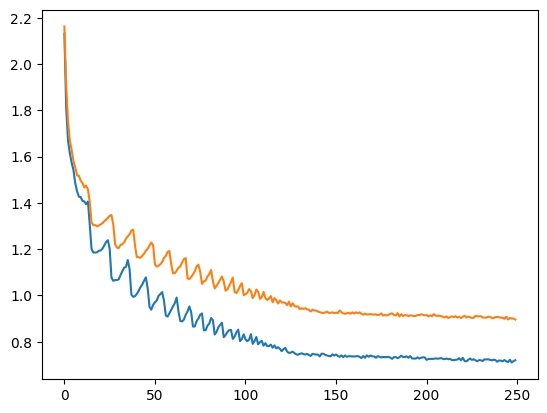

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.close()
plt.plot(weight_updater_affine.recorder.train_loss_line_per_epoch)
plt.plot(weight_updater_no_affine.recorder.train_loss_line_per_epoch)

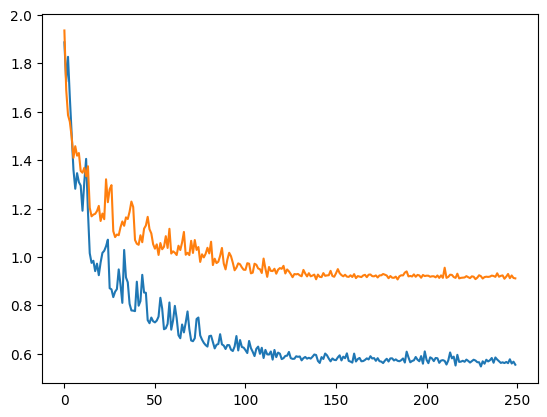

In [11]:
plt.close()
plt.plot(weight_updater_affine.recorder.test_loss_line_per_epoch)
plt.plot(weight_updater_no_affine.recorder.test_loss_line_per_epoch)

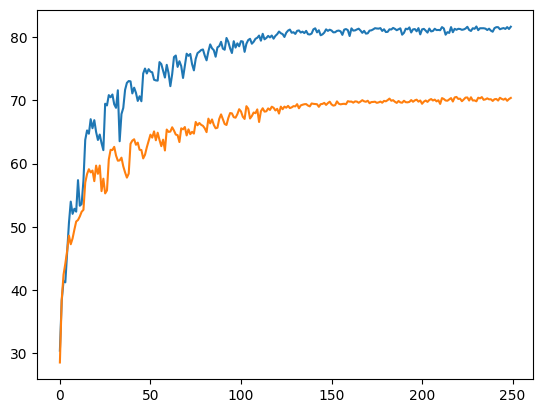

In [12]:
plt.close()
plt.plot(affine_acc)
plt.plot(no_affine_acc)

In [13]:
torch.save(model_affine.state_dict(),'vit_affine_end.weight')
torch.save(model_no_affine.state_dict(),'vit_no_affine_end.weight')